<font color="#CC3D3D"><p>
# ML Pipeline

- **`PROBLEM`**: 백화점 고객이 1년 동안 상품을 구매한 속성을 분석하여 `고객의 성별(0:여자, 1:남자)을 예측`하시오.
- **`INPUT`**: 학습용(`X_train.csv`, `y_train`)과 평가용(`X_test.csv`) 데이터 
- **`OUTPUT`**: 위 데이터를 이용하여 구축한 모형이 생성한 예측결과(`submission.csv`)

##### Imports

In [1]:
# Data Wrangling
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

# EDA
import klib

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile

# Hyperparameter Optimization
import optuna

# Modeling
from sklearn import ensemble
import lightgbm as lgb
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.base import ClassifierMixin
from catboost import CatBoostClassifier

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=4,random_state=0,shuffle=True)
from sklearn import model_selection

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm, tqdm_notebook
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

### 1. Read Data

In [2]:
# 학습용과 평가용(제출용) 데이터를 읽어들인다.
train = pd.read_csv('X_train.csv', encoding='cp949')
test = pd.read_csv('X_test.csv', encoding='cp949')

# 분석에 필요없는 ID 필드를 데이터에서 제거하고, 전처리 후 학습용과 제출용 데이터를 분리하기 위해 ID는 보관한다.
train_id = train['cust_id']
test_id = test['cust_id']
del train['cust_id'], test['cust_id']

# 학습용 정답 데이터를 읽는다.
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender

# 전처리를 동일하게 적용하기 위해 두 데이터를 합한다.
features = pd.concat([train, test]).reset_index(drop=True)
features

,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
0,68282840,11264000,6860000.0,기타,강남점,19,3.894737,0.527027,17
1,2136000,2136000,300000.0,스포츠,잠실점,2,1.500000,0.000000,1
2,3197000,1639000,NaN,남성 캐주얼,관악점,2,2.000000,0.000000,1
3,16077620,4935000,NaN,기타,광주점,18,2.444444,0.318182,16
4,29050000,24000000,NaN,보석,본 점,2,1.500000,0.000000,85
...,...,...,...,...,...,...,...,...,...
5977,82581500,23976000,NaN,골프,부산본점,8,1.750000,0.642857,40
5978,480000,480000,NaN,섬유잡화,광주점,1,1.000000,0.000000,0
5979,260003790,25750000,NaN,남성 캐주얼,본 점,19,3.736842,0.915493,18
5980,88991520,18120000,NaN,육류,본 점,5,3.600000,0.444444,60


### 2. EDA

In [3]:
#matplotlib 한글깨짐 지원

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)  


GridSpec(6, 6)

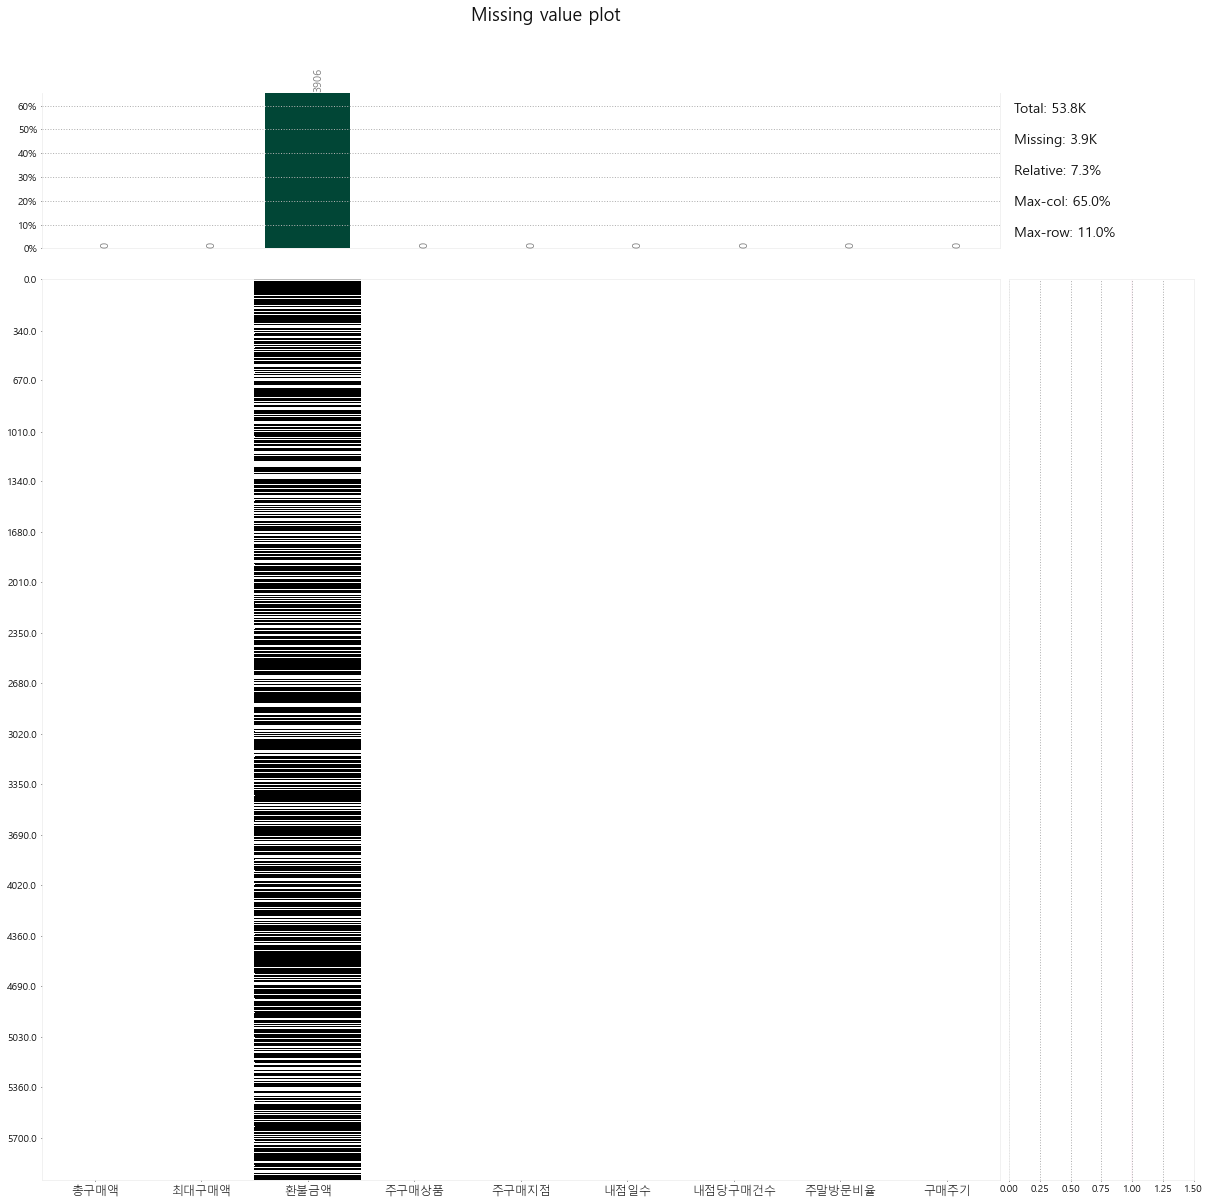

In [4]:
# 결측값 파악
klib.missingval_plot(features)

<AxesSubplot:xlabel='구매주기', ylabel='Density'>

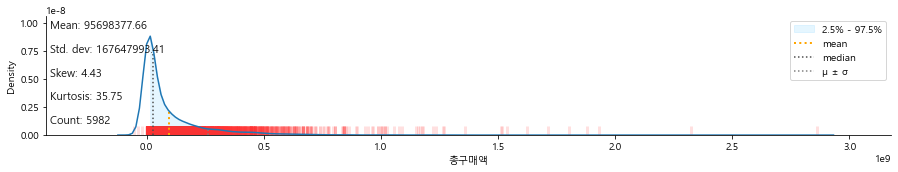

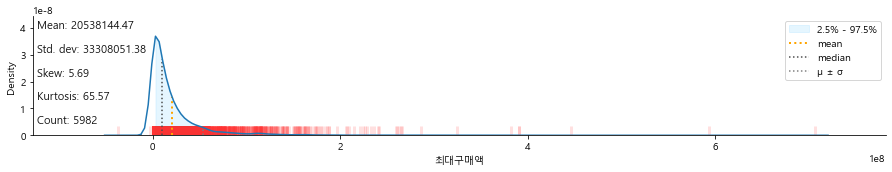

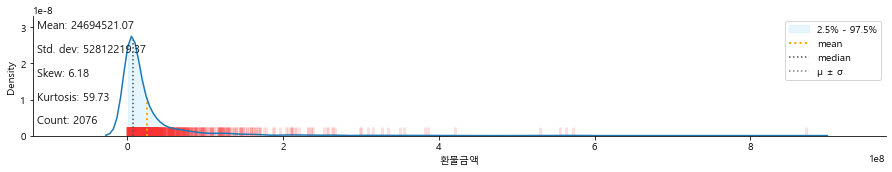

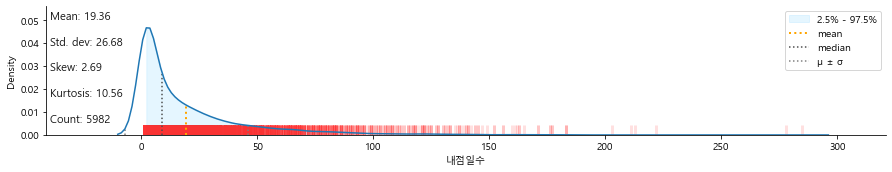

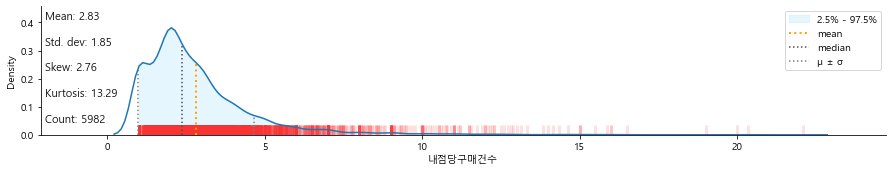

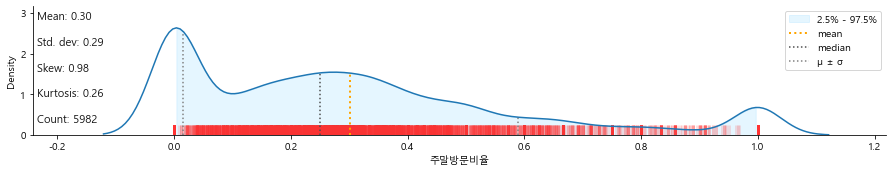

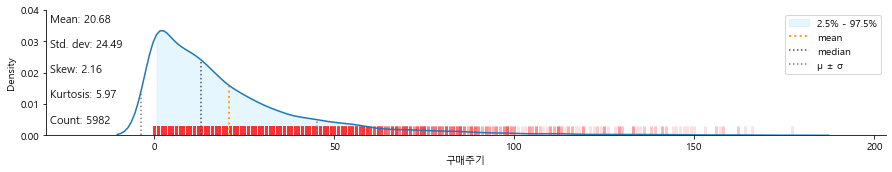

In [5]:
# 수치형 속성 파악

klib.dist_plot(features)

GridSpec(6, 2)

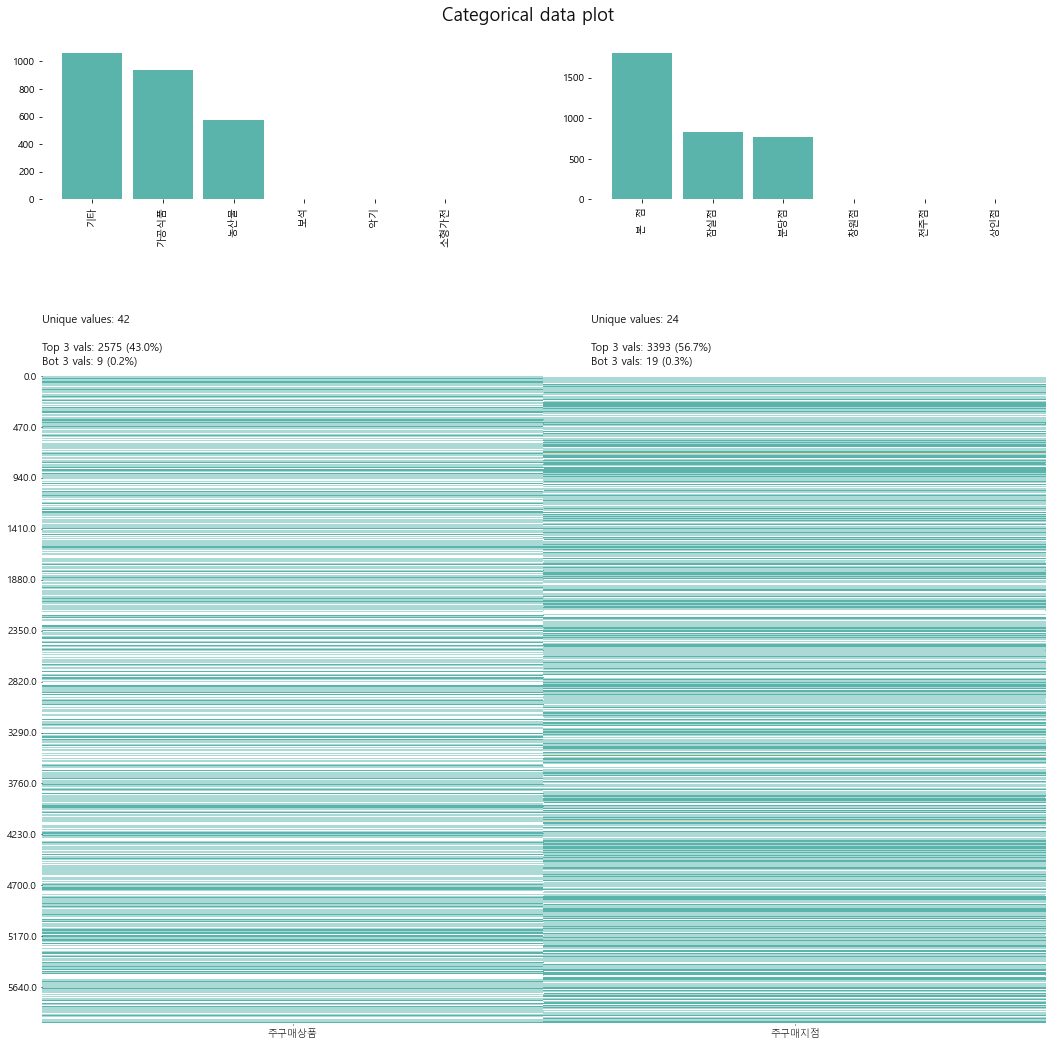

In [6]:
# 범주형 속성 파악

klib.cat_plot(features)

Displaying absolute correlations above the threshold (0.3). Specify a positive "threshold" to limit the results further.


<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

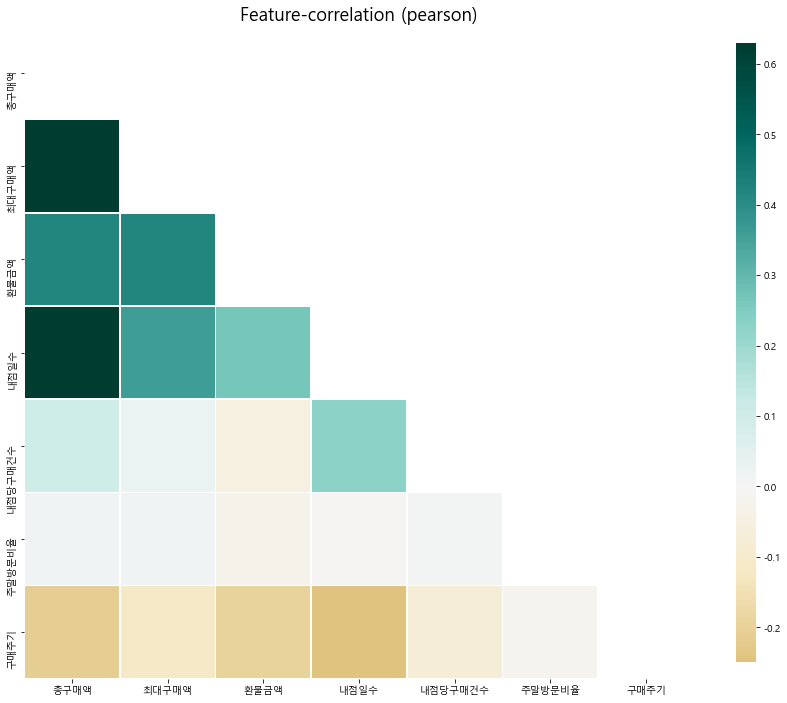

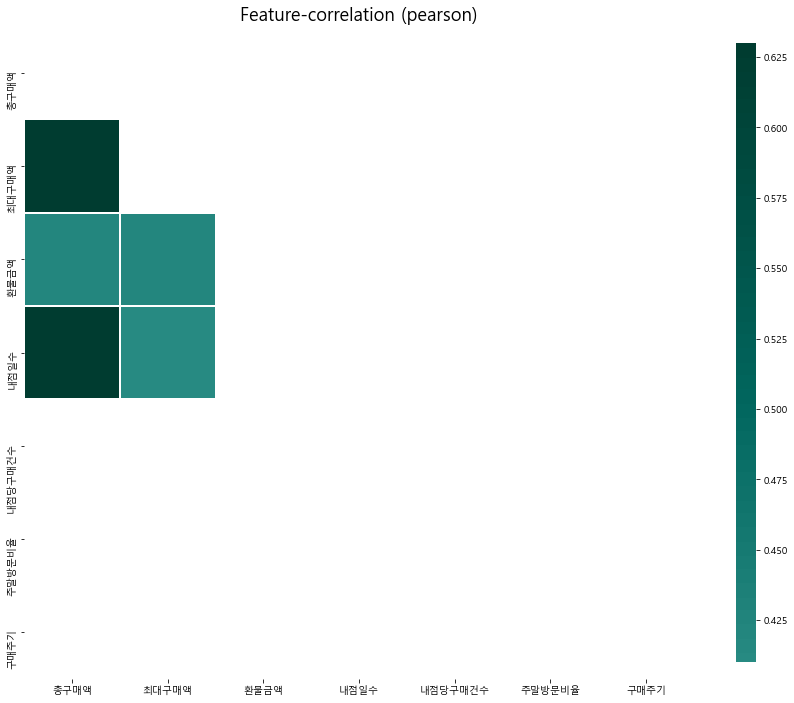

In [7]:
# 속성간 유사성 파악

klib.corr_plot(features, annot=False, figsize=(15,12))
klib.corr_plot(features, split='high', annot=False, figsize=(15,12))

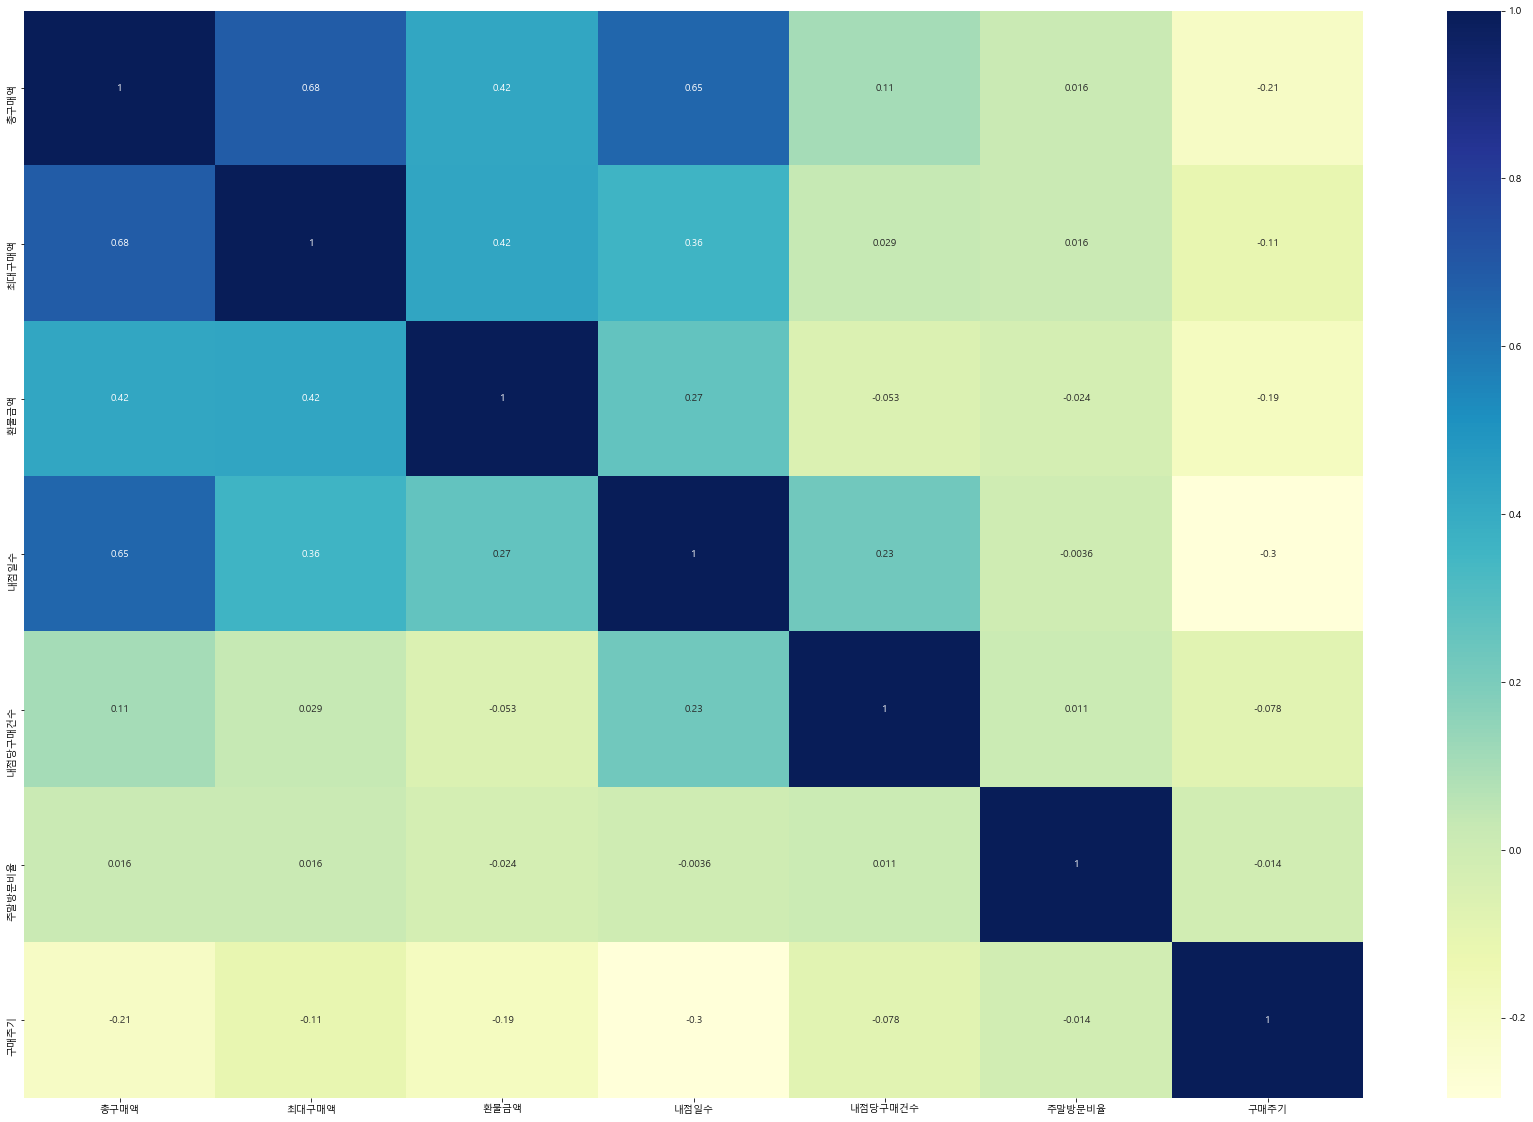

In [8]:
plt.figure(figsize=(30,20))
sns.heatmap(features.corr(), annot=True, cmap="YlGnBu")
plt.show()

# 다중공선성 탐색 결과 지나치게 상관계수가 높게 나타나는 피쳐는 없어서 모든 피쳐를 활용함.

<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

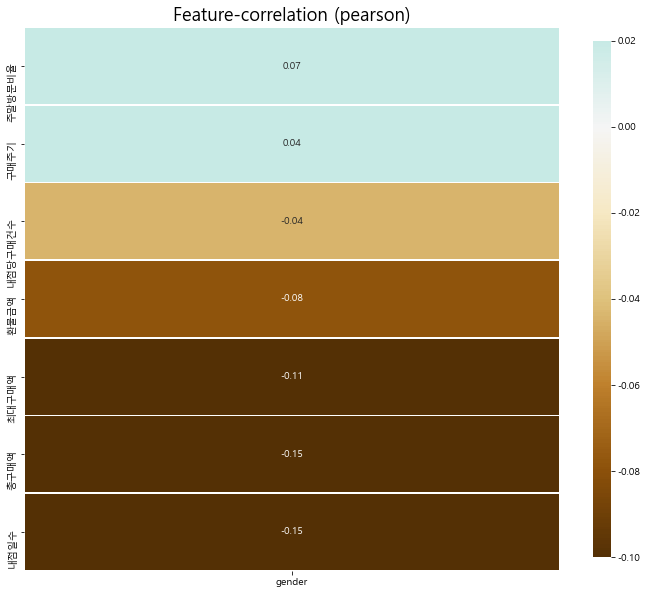

In [9]:
# 속성별 예측 능력 파악 
#train 데이터에서 피쳐들이 얼마나 gender를 잘예측하나를 보여줌

klib.corr_plot(pd.concat([train, y_train], axis=1), target='gender')

### 3. Data Cleansing & Feature Engineering

In [10]:
# 범주형 변수와 수치형 변수를 분리

cat_features = features.select_dtypes(include=['object']).columns.to_list()
num_features = features.select_dtypes(exclude='object').columns.to_list()

*Impute Missing Values*

In [11]:
#결측값 파악

features.isna().sum()

총구매액          0
최대구매액         0
환불금액       3906
주구매상품         0
주구매지점         0
내점일수          0
내점당구매건수       0
주말방문비율        0
구매주기          0
dtype: int64

In [12]:
# 결측값 처리: 결측값을 처리하는 방법 중에서 결측값이 있는 행을 제외하는 방법은 데이터 수의 부족으로 하지 않았습니다.
# 수치형 -> 평균값으로 대체
# 범주형 -> 범주형 데이터의 결측값을 처리하는 방법이 수치형 데이터의 결측값을 처리하는 방법에 비해 다양하지 않았는데, 데이터의 수도 적어 범주형 데이터는 most_frequent로 처리하기로 하였습니다

if len(num_features) > 0: 
    features[num_features] = SimpleImputer(strategy='mean', fill_value=0).fit_transform(features[num_features])
if len(cat_features) > 0:  
    features[cat_features] = SimpleImputer(strategy="most_frequent").fit_transform(features[cat_features])

features

,총구매액,최대구매액,환불금액,주구매상품,주구매지점,내점일수,내점당구매건수,주말방문비율,구매주기
0,68282840.0,11264000.0,6.860000e+06,기타,강남점,19.0,3.894737,0.527027,17.0
1,2136000.0,2136000.0,3.000000e+05,스포츠,잠실점,2.0,1.500000,0.000000,1.0
2,3197000.0,1639000.0,2.469452e+07,남성 캐주얼,관악점,2.0,2.000000,0.000000,1.0
3,16077620.0,4935000.0,2.469452e+07,기타,광주점,18.0,2.444444,0.318182,16.0
4,29050000.0,24000000.0,2.469452e+07,보석,본 점,2.0,1.500000,0.000000,85.0
...,...,...,...,...,...,...,...,...,...
5977,82581500.0,23976000.0,2.469452e+07,골프,부산본점,8.0,1.750000,0.642857,40.0
5978,480000.0,480000.0,2.469452e+07,섬유잡화,광주점,1.0,1.000000,0.000000,0.0
5979,260003790.0,25750000.0,2.469452e+07,남성 캐주얼,본 점,19.0,3.736842,0.915493,18.0
5980,88991520.0,18120000.0,2.469452e+07,육류,본 점,5.0,3.600000,0.444444,60.0


In [13]:
# 결측값 처리 완료 확인

features.isna().sum()

총구매액       0
최대구매액      0
환불금액       0
주구매상품      0
주구매지점      0
내점일수       0
내점당구매건수    0
주말방문비율     0
구매주기       0
dtype: int64

*Deal with Outliers*

In [14]:
# 이상치 처리가 필요한 피쳐를 리스트에 담음

need_out = ["주말방문비율","구매주기","내점일수","총구매액","최대구매액","환불금액","내점당구매건수"]

In [15]:
for i in need_out:
    features[[i]] = features[[i]].apply(lambda x: x.clip(x.quantile(.25)-1.5*(x.quantile(.75)-x.quantile(.25)), 
                                                         x.quantile(.75)+1.5*(x.quantile(.75)-x.quantile(.25))))
# IQR로 이상치제거
# 이상치를 제거할 때 IQR 이외에 Z-SCORE이나 ROBUST Z-SCORE과 같은 메소드를 활용하여 이상치에 해당하면 해당 열을 제거하는 방식으로 해보려고 하였으나, 데이터가 굉장히 부족한 상황에서 이상치를 제거해 버리니 성능이 0.55이하로 떨어지는 결과가 나왔습니다. 따라서 이런 방식은 제외하기로 결정하였습니다

이상치 제거 후


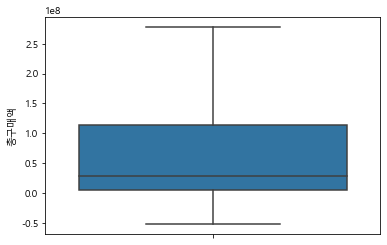

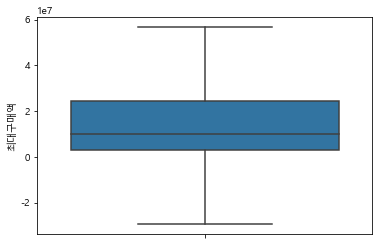

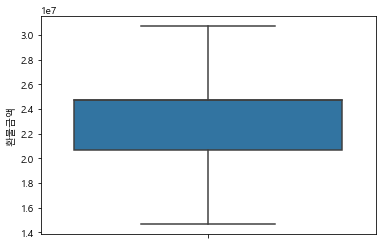

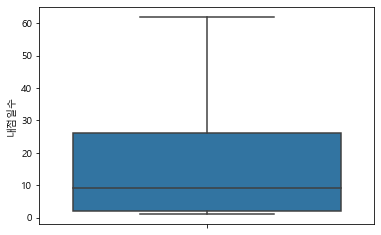

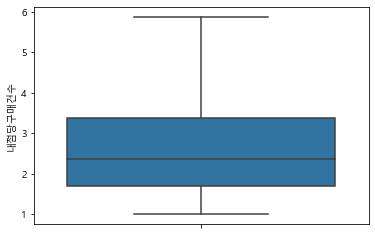

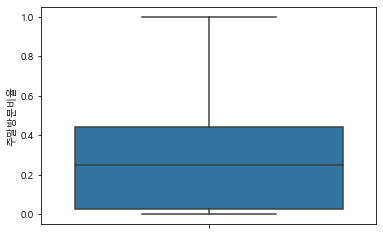

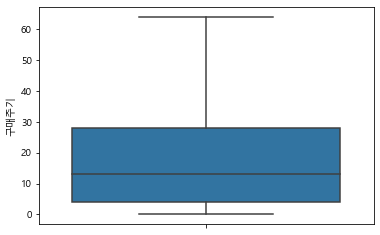

In [16]:
print("이상치 제거 후")
for i in num_features :
    sns.boxplot(data = features, y = i)
    plt.show()

*Encode Categorical Variables*

In [17]:
if len(cat_features) > 0:
    features = pd.concat([features[num_features], pd.get_dummies(features[cat_features])], axis=1)
else:
    features = features[num_features]

features
# 범주형 변수에 대해서는 원핫 인코딩을 사용하였습니다.

,총구매액,최대구매액,환불금액,내점일수,내점당구매건수,주말방문비율,구매주기,주구매상품_가공식품,주구매상품_가구,주구매상품_건강식품,...,주구매지점_안양점,주구매지점_영등포점,주구매지점_울산점,주구매지점_인천점,주구매지점_일산점,주구매지점_잠실점,주구매지점_전주점,주구매지점_창원점,주구매지점_청량리점,주구매지점_포항점
0,68282840.0,11264000.0,1.467759e+07,19.0,3.894737,0.527027,17.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2136000.0,2136000.0,1.467759e+07,2.0,1.500000,0.000000,1.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,3197000.0,1639000.0,2.469452e+07,2.0,2.000000,0.000000,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,16077620.0,4935000.0,2.469452e+07,18.0,2.444444,0.318182,16.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,29050000.0,24000000.0,2.469452e+07,2.0,1.500000,0.000000,64.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,82581500.0,23976000.0,2.469452e+07,8.0,1.750000,0.642857,40.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5978,480000.0,480000.0,2.469452e+07,1.0,1.000000,0.000000,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5979,260003790.0,25750000.0,2.469452e+07,19.0,3.736842,0.915493,18.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5980,88991520.0,18120000.0,2.469452e+07,5.0,3.600000,0.444444,60.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


*Select Features*

총구매액


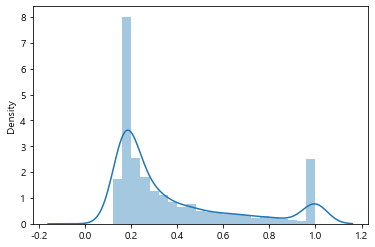

최대구매액


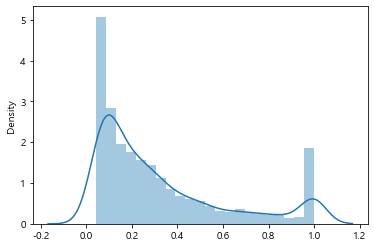

환불금액


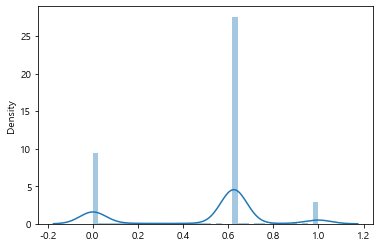

내점일수


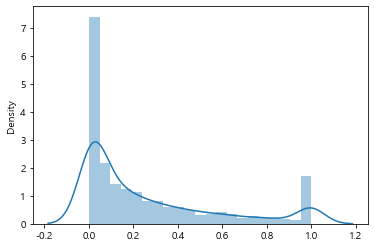

내점당구매건수


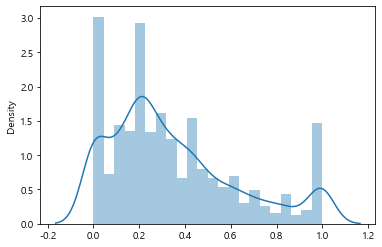

주말방문비율


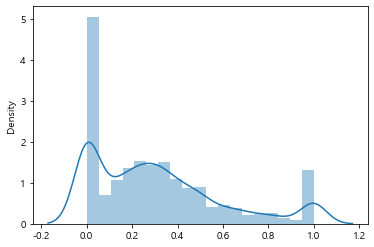

구매주기


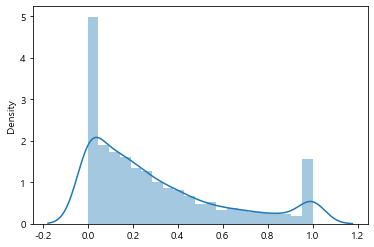

In [18]:
#학습용과 제출용 데이터로 분리
features = pd.concat([pd.concat([train_id, test_id]).reset_index(drop=True), features], axis=1)
X_train = features.query('cust_id in @train_id').drop('cust_id', axis=1)
X_test = features.query('cust_id in @test_id').drop('cust_id', axis=1)

# min-max scaling
# powertransform과 minmaxscaler의 logisticregression모델일 때 roc_auc_score를 비교해보면 powertransform 이 0.6827 , min-max가 0.686로 min-max scaling 채택함.
# 학습용과 제출용 데이터를 분리하기 전에 MinMaxScaler를 진행하면 test데이터로 다시 새로운 스케일링 기준 정보를 만들게 되어 학습데이터와 테스트 데이터의 스케일링 기준 정보가 서로 달라지는 문제가 발생하기 때문에 이를 방지하기 위해 학습데이터와 테스트데이터 분리 후 스케일링 진행하였습니다.

scaler = MinMaxScaler()

X_train_num = scaler.fit(X_train.iloc[:,:7]).transform(X_train.iloc[:,:7])
X_test_num = scaler.transform(X_test.iloc[:,:7]) 

X_train=pd.concat([pd.DataFrame(X_train_num),pd.DataFrame(X_train.iloc[:,7:])],axis=1)
X_test = pd.concat([pd.DataFrame(X_test_num),pd.DataFrame(X_test.iloc[:,7:]).reset_index()],axis=1)


for i,col in enumerate(num_features): 
    sns.distplot(pd.DataFrame(X_train[i]))
    print(col)
    plt.show()

In [19]:
X_test.drop(columns = ['index'], inplace=True)


(27, 0.6861728030430084)


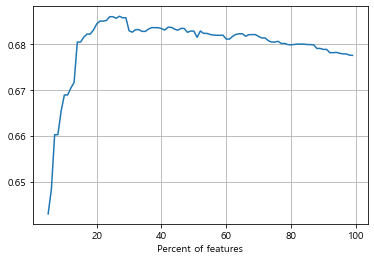

In [20]:
# 사용할 모델 설정 : 다른 알고리즘을 사용할 때보다 LR모델을 사용할 때가 가장 점수가 높게 나옴. 

model = LogisticRegression(random_state=0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법

cv_scores = []
for p in tqdm_notebook(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(X_train, y_train)    
    cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=5).mean()
    cv_scores.append((p,cv_score))

best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [21]:
# p에 따른 cv_score을 모두 출력해봄
cv_scores

[(5, 0.6429491968760688),
 (6, 0.6483941079917922),
 (7, 0.6602680591112037),
 (8, 0.6602680591112037),
 (9, 0.665416928286996),
 (10, 0.6689534515967706),
 (11, 0.6689534515967706),
 (12, 0.6704663467992921),
 (13, 0.6716703863139342),
 (14, 0.6805280726636657),
 (15, 0.6805280726636657),
 (16, 0.6816025476087528),
 (17, 0.6822757414556795),
 (18, 0.6822757414556795),
 (19, 0.6831814909799006),
 (20, 0.6844966592585642),
 (21, 0.6851156295637628),
 (22, 0.6851156295637628),
 (23, 0.6852540780581534),
 (24, 0.6860728267017867),
 (25, 0.6860728267017867),
 (26, 0.6857298920062291),
 (27, 0.6861728030430084),
 (28, 0.6858348037856571),
 (29, 0.6858348037856571),
 (30, 0.6829858956579784),
 (31, 0.68268860566621),
 (32, 0.6832413299196111),
 (33, 0.6832413299196111),
 (34, 0.6828617495556865),
 (35, 0.6828617495556865),
 (36, 0.6833746930326912),
 (37, 0.6836968345594997),
 (38, 0.6836724721159466),
 (39, 0.6836724721159466),
 (40, 0.683479189815324),
 (41, 0.6831501085140573),
 (42, 0.68

In [22]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택해보았으나 (27이 아닌 25), 최적의 p값을 사용했을 때의 성능이 더 좋았기 때문에 p=27로 했다.
fs = SelectPercentile(percentile=27).fit(X_train, y_train)
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

print(X_train.shape)
print(features.iloc[:,1:].columns[fs.get_support()].tolist())

(3500, 20)
['총구매액', '최대구매액', '환불금액', '내점일수', '내점당구매건수', '주말방문비율', '주구매상품_골프', '주구매상품_남성 캐주얼', '주구매상품_남성정장', '주구매상품_농산물', '주구매상품_디자이너', '주구매상품_섬유잡화', '주구매상품_셔츠', '주구매상품_스포츠', '주구매상품_시티웨어', '주구매상품_주류', '주구매상품_주방가전', '주구매상품_화장품', '주구매지점_강남점', '주구매지점_전주점']


### 4. Model Tuning (Hyperparameter Optimization)

In [23]:
# 학습데이터 70%, 평가데이터 30%로 데이터 분할함.
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [24]:
# 하이퍼파라미터 튜닝한 모델의 validation score를 담는 리스트를 만듦.
model_score = []

In [25]:
# Optuna를 이용한 Bayesian Optimization 사용
# penalty : 규제의 유형을 설정(l2,none)
# C :  규제 강도를 조절하는 alpha값의 역수
def LR(trial):
    param ={ 
    "C" : trial.suggest_float('C', 0.001, 0.5, log=True),
    "penalty" : trial.suggest_categorical("penalty", ['l2','none'])}

    LR = LogisticRegression(**param, random_state=0)
    LR.fit(X_train, y_train)
    pred = LR.predict_proba(X_dev)[:,1]
    score = roc_auc_score(y_dev, pred)
    score = score.mean()
    return score

LR_study = optuna.create_study(direction="maximize")
LR_study.optimize(LR, n_trials=100)
print("model_LR :" , LR_study.best_value)
model_score.append(LR_study.best_value)

[I 2021-11-23 22:21:34,496] A new study created in memory with name: no-name-ef7064a1-54f2-4499-9dc5-d2367e938bf6
[I 2021-11-23 22:21:34,504] Trial 0 finished with value: 0.6702412501321141 and parameters: {'C': 0.03875536604574869, 'penalty': 'l2'}. Best is trial 0 with value: 0.6702412501321141.
[I 2021-11-23 22:21:34,510] Trial 1 finished with value: 0.6714155976841866 and parameters: {'C': 0.05454726493318444, 'penalty': 'l2'}. Best is trial 1 with value: 0.6714155976841866.
[I 2021-11-23 22:21:34,529] Trial 2 finished with value: 0.6770759528851762 and parameters: {'C': 0.0012930915491170033, 'penalty': 'none'}. Best is trial 2 with value: 0.6770759528851762.
[I 2021-11-23 22:21:34,550] Trial 3 finished with value: 0.6770759528851762 and parameters: {'C': 0.1846268131934057, 'penalty': 'none'}. Best is trial 2 with value: 0.6770759528851762.
[I 2021-11-23 22:21:34,556] Trial 4 finished with value: 0.6694505227803853 and parameters: {'C': 0.03015769572409053, 'penalty': 'l2'}. Best

[I 2021-11-23 22:21:35,254] Trial 41 finished with value: 0.6770759528851762 and parameters: {'C': 0.007640753561835848, 'penalty': 'none'}. Best is trial 2 with value: 0.6770759528851762.
[I 2021-11-23 22:21:35,277] Trial 42 finished with value: 0.6770759528851762 and parameters: {'C': 0.010316836793983113, 'penalty': 'none'}. Best is trial 2 with value: 0.6770759528851762.
[I 2021-11-23 22:21:35,297] Trial 43 finished with value: 0.6770759528851762 and parameters: {'C': 0.002679543507238643, 'penalty': 'none'}. Best is trial 2 with value: 0.6770759528851762.
[I 2021-11-23 22:21:35,318] Trial 44 finished with value: 0.6770759528851762 and parameters: {'C': 0.0056019241389667004, 'penalty': 'none'}. Best is trial 2 with value: 0.6770759528851762.
[I 2021-11-23 22:21:35,325] Trial 45 finished with value: 0.6593393903570409 and parameters: {'C': 0.0026508629686125516, 'penalty': 'l2'}. Best is trial 2 with value: 0.6770759528851762.
[I 2021-11-23 22:21:35,345] Trial 46 finished with valu

[I 2021-11-23 22:21:36,095] Trial 82 finished with value: 0.6770759528851762 and parameters: {'C': 0.34979830690146835, 'penalty': 'none'}. Best is trial 2 with value: 0.6770759528851762.
[I 2021-11-23 22:21:36,116] Trial 83 finished with value: 0.6770759528851762 and parameters: {'C': 0.08563674571741406, 'penalty': 'none'}. Best is trial 2 with value: 0.6770759528851762.
[I 2021-11-23 22:21:36,135] Trial 84 finished with value: 0.6770759528851762 and parameters: {'C': 0.16188499318450073, 'penalty': 'none'}. Best is trial 2 with value: 0.6770759528851762.
[I 2021-11-23 22:21:36,156] Trial 85 finished with value: 0.6770759528851762 and parameters: {'C': 0.11954777779695801, 'penalty': 'none'}. Best is trial 2 with value: 0.6770759528851762.
[I 2021-11-23 22:21:36,167] Trial 86 finished with value: 0.6728678741569163 and parameters: {'C': 0.09545464769424045, 'penalty': 'l2'}. Best is trial 2 with value: 0.6770759528851762.
[I 2021-11-23 22:21:36,188] Trial 87 finished with value: 0.67

model_LR : 0.6770759528851762


In [26]:
# 모델을 확장하여 모델 간의 독립성을 확보함 (randomforest, lgbm, catboost, adaboost, knn, extratree 활용)

# n_estimators : 생성할 의사결정 나무 개수 
# max_depth : 나무의 깊이
# criterion : feature 중요도 측정 -> gini 혹은 entropy
# min_samples_leaf : 각 leaf 노드에서의 최소 데이터 갯수
# Min_samples_split : Leaf 가 아닌 노드(internal node)에서의 최소 데이터 갯수

def RandomForest(trial):
    param = {
      "n_estimators" : trial.suggest_int("n_estimators", 100, 700, step=100),
      "max_depth" : trial.suggest_int("max_depth", 2, 10),
      "criterion" : trial.suggest_categorical("criterion", ["gini", "entropy"]),
      "min_samples_leaf" :trial.suggest_int("min_samples_leaf", 2, 10),
      "min_samples_split" :trial.suggest_int("min_samples_split", 2,20)}
    
    RF = ensemble.RandomForestClassifier(**param, random_state=0)
    RF.fit(X_train, y_train)
    pred = RF.predict_proba(X_dev)[:,1]
    score = roc_auc_score(y_dev, pred)
    score = score.mean()
    return score

RF_study = optuna.create_study(direction="maximize")
RF_study.optimize(RandomForest, n_trials=100)
print("model_RF :", RF_study.best_value)
model_score.append(RF_study.best_value)

[I 2021-11-23 22:21:36,449] A new study created in memory with name: no-name-20128c6a-c960-472d-80f3-8144ddb025a8
[I 2021-11-23 22:21:37,206] Trial 0 finished with value: 0.6559044237672287 and parameters: {'n_estimators': 500, 'max_depth': 4, 'criterion': 'entropy', 'min_samples_leaf': 4, 'min_samples_split': 6}. Best is trial 0 with value: 0.6559044237672287.
[I 2021-11-23 22:21:38,521] Trial 1 finished with value: 0.6559181244886696 and parameters: {'n_estimators': 700, 'max_depth': 9, 'criterion': 'entropy', 'min_samples_leaf': 8, 'min_samples_split': 3}. Best is trial 1 with value: 0.6559181244886696.
[I 2021-11-23 22:21:39,049] Trial 2 finished with value: 0.6553563949095949 and parameters: {'n_estimators': 300, 'max_depth': 7, 'criterion': 'gini', 'min_samples_leaf': 4, 'min_samples_split': 15}. Best is trial 1 with value: 0.6559181244886696.
[I 2021-11-23 22:21:39,724] Trial 3 finished with value: 0.6585584492349126 and parameters: {'n_estimators': 400, 'max_depth': 5, 'criteri

[I 2021-11-23 22:22:06,370] Trial 31 finished with value: 0.660429576334548 and parameters: {'n_estimators': 600, 'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 13}. Best is trial 25 with value: 0.6612398761454782.
[I 2021-11-23 22:22:07,390] Trial 32 finished with value: 0.6598972054442753 and parameters: {'n_estimators': 600, 'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 14}. Best is trial 25 with value: 0.6612398761454782.
[I 2021-11-23 22:22:08,664] Trial 33 finished with value: 0.6613905840813274 and parameters: {'n_estimators': 700, 'max_depth': 7, 'criterion': 'entropy', 'min_samples_leaf': 3, 'min_samples_split': 11}. Best is trial 33 with value: 0.6613905840813274.
[I 2021-11-23 22:22:09,983] Trial 34 finished with value: 0.6613905840813274 and parameters: {'n_estimators': 700, 'max_depth': 7, 'criterion': 'entropy', 'min_samples_leaf': 3, 'min_samples_split': 11}. Best is trial 33 with value: 0.6613905

[I 2021-11-23 22:22:34,842] Trial 62 finished with value: 0.660231894496616 and parameters: {'n_estimators': 400, 'max_depth': 7, 'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 12}. Best is trial 52 with value: 0.6618603231021565.
[I 2021-11-23 22:22:35,577] Trial 63 finished with value: 0.6615628217222982 and parameters: {'n_estimators': 400, 'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 11}. Best is trial 52 with value: 0.6618603231021565.
[I 2021-11-23 22:22:36,269] Trial 64 finished with value: 0.6588637795984514 and parameters: {'n_estimators': 400, 'max_depth': 5, 'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 13}. Best is trial 52 with value: 0.6618603231021565.
[I 2021-11-23 22:22:36,839] Trial 65 finished with value: 0.6604882937121518 and parameters: {'n_estimators': 300, 'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 10}. Best is trial 52 with value: 0.6618603

[I 2021-11-23 22:22:58,714] Trial 93 finished with value: 0.6592552287824756 and parameters: {'n_estimators': 500, 'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 6, 'min_samples_split': 12}. Best is trial 52 with value: 0.6618603231021565.
[I 2021-11-23 22:22:59,593] Trial 94 finished with value: 0.6615667362141383 and parameters: {'n_estimators': 500, 'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 12}. Best is trial 52 with value: 0.6618603231021565.
[I 2021-11-23 22:23:00,559] Trial 95 finished with value: 0.6591749816997506 and parameters: {'n_estimators': 500, 'max_depth': 7, 'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 13}. Best is trial 52 with value: 0.6618603231021565.
[I 2021-11-23 22:23:01,485] Trial 96 finished with value: 0.6615667362141383 and parameters: {'n_estimators': 500, 'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 12}. Best is trial 52 with value: 0.661860

model_RF : 0.6618603231021565


In [27]:
# bagging_freq : iteration 몇번째에 해당하는 데이터를 업데이트 할것인지. (과적합방지)
# min_data_in_leaf : Leaf가 가지고 있는 최소한의 레코드 수 (과적합 방지)
# max_depth : 나무의 깊이(과적합 방지)
# learning_rate : 훈련량
# num_leaves : 잎사귀의 수 (과적합 방지)
# num_threads : 병렬처리시 처리할 thread
# min_sum_hessian_in_leaf : 잎에 있는 hessian의 합이 min_sum_hessian_in_leaf보다 작으면 성장을 멈춥(과적합 방지)
def LGBM(trial):
    
    param = {
    "bagging_freq" : trial.suggest_int('bagging_freq',1,10),
    "min_data_in_leaf" :  trial.suggest_int('min_data_in_leaf',2,100),
    "max_depth" : trial.suggest_int('max_depth',1,20),
    "learning_rate" :trial.suggest_loguniform('learning_rate',0.001,0.1),
    "num_leaves" :trial.suggest_int('num_leaves',2,70),
    "num_threads" :trial.suggest_int('num_threads',1,10),
    "min_sum_hessian_in_leaf" : trial.suggest_int('min_sum_hessian_in_leaf',1,10)}
    
    LGBM = lgb.LGBMClassifier(**param, random_state=0)
    LGBM.fit(X_train, y_train)
    pred = LGBM.predict_proba(X_dev)[:,1]
    score = roc_auc_score(y_dev, pred)
    score = score.mean()
    return score

LGBM_study = optuna.create_study(direction="maximize")
LGBM_study.optimize(LGBM, n_trials=100)
print("model_lgbm :", LGBM_study.best_value)
model_score.append(LGBM_study.best_value)

[I 2021-11-23 22:23:04,390] A new study created in memory with name: no-name-d1493446-0fc1-443a-bea7-61ccea5a9749
[I 2021-11-23 22:23:04,437] Trial 0 finished with value: 0.6169611016945835 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 73, 'max_depth': 13, 'learning_rate': 0.09945444270312827, 'num_leaves': 16, 'num_threads': 9, 'min_sum_hessian_in_leaf': 2}. Best is trial 0 with value: 0.6169611016945835.
[I 2021-11-23 22:23:04,475] Trial 1 finished with value: 0.6314916954055609 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 78, 'max_depth': 18, 'learning_rate': 0.002410846544925127, 'num_leaves': 22, 'num_threads': 4, 'min_sum_hessian_in_leaf': 8}. Best is trial 1 with value: 0.6314916954055609.
[I 2021-11-23 22:23:04,537] Trial 2 finished with value: 0.6243144746164777 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 35, 'max_depth': 12, 'learning_rate': 0.03535621562123201, 'num_leaves': 42, 'num_threads': 5, 'min_sum_hessian_in_leaf': 2}. Best is trial 1

[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 

[I 2021-11-23 22:23:04,577] Trial 3 finished with value: 0.6380171533032439 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 93, 'max_depth': 11, 'learning_rate': 0.012469498742837254, 'num_leaves': 55, 'num_threads': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 3 with value: 0.6380171533032439.
[I 2021-11-23 22:23:04,656] Trial 4 finished with value: 0.6151408629888712 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 2, 'max_depth': 9, 'learning_rate': 0.0911847325109509, 'num_leaves': 45, 'num_threads': 7, 'min_sum_hessian_in_leaf': 1}. Best is trial 3 with value: 0.6380171533032439.
[I 2021-11-23 22:23:04,674] Trial 5 finished with value: 0.6166812155280063 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 20, 'max_depth': 2, 'learning_rate': 0.001409681764113743, 'num_leaves': 34, 'num_threads': 4, 'min_sum_hessian_in_leaf': 7}. Best is trial 3 with value: 0.6380171533032439.
[I 2021-11-23 22:23:04,694] Trial 6 finished with value: 0.651183546607897 and param

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 wi

[I 2021-11-23 22:23:04,793] Trial 9 finished with value: 0.6342142244804491 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 55, 'max_depth': 13, 'learning_rate': 0.03471418512004445, 'num_leaves': 18, 'num_threads': 7, 'min_sum_hessian_in_leaf': 4}. Best is trial 7 with value: 0.6618309644133546.
[I 2021-11-23 22:23:04,852] Trial 10 finished with value: 0.6422878639009477 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 98, 'max_depth': 7, 'learning_rate': 0.03366102733530559, 'num_leaves': 70, 'num_threads': 1, 'min_sum_hessian_in_leaf': 10}. Best is trial 7 with value: 0.6618309644133546.
[I 2021-11-23 22:23:04,878] Trial 11 finished with value: 0.6374436802486485 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 40, 'max_depth': 1, 'learning_rate': 0.014403324021007307, 'num_leaves': 64, 'num_threads': 7, 'min_sum_hessian_in_leaf': 5}. Best is trial 7 with value: 0.6618309644133546.
[I 2021-11-23 22:23:04,955] Trial 12 finished with value: 0.6346761345175976 an

[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples

[I 2021-11-23 22:23:05,088] Trial 14 finished with value: 0.625291140330618 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 32, 'max_depth': 20, 'learning_rate': 0.006313416941374267, 'num_leaves': 35, 'num_threads': 6, 'min_sum_hessian_in_leaf': 10}. Best is trial 7 with value: 0.6618309644133546.
[I 2021-11-23 22:23:05,122] Trial 15 finished with value: 0.6579262588027135 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 86, 'max_depth': 1, 'learning_rate': 0.05257361255465686, 'num_leaves': 5, 'num_threads': 10, 'min_sum_hessian_in_leaf': 4}. Best is trial 7 with value: 0.6618309644133546.
[I 2021-11-23 22:23:05,182] Trial 16 finished with value: 0.6459361702960529 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 85, 'max_depth': 5, 'learning_rate': 0.04248830660951806, 'num_leaves': 27, 'num_threads': 10, 'min_sum_hessian_in_leaf': 4}. Best is trial 7 with value: 0.6618309644133546.


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples

[I 2021-11-23 22:23:05,222] Trial 17 finished with value: 0.6587013281870814 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 64, 'max_depth': 8, 'learning_rate': 0.057579508839918865, 'num_leaves': 2, 'num_threads': 9, 'min_sum_hessian_in_leaf': 3}. Best is trial 7 with value: 0.6618309644133546.
[I 2021-11-23 22:23:05,280] Trial 18 finished with value: 0.6227251909293394 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 65, 'max_depth': 9, 'learning_rate': 0.05775599748536745, 'num_leaves': 44, 'num_threads': 6, 'min_sum_hessian_in_leaf': 2}. Best is trial 7 with value: 0.6618309644133546.
[I 2021-11-23 22:23:05,315] Trial 19 finished with value: 0.6429533275137889 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 47, 'max_depth': 15, 'learning_rate': 0.019955930672129994, 'num_leaves': 2, 'num_threads': 8, 'min_sum_hessian_in_leaf': 3}. Best is trial 7 with value: 0.6618309644133546.
[I 2021-11-23 22:23:05,384] Trial 20 finished with value: 0.6354453321642051 and 

[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 

[I 2021-11-23 22:23:05,454] Trial 22 finished with value: 0.6523128775038068 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 81, 'max_depth': 3, 'learning_rate': 0.06759716991862401, 'num_leaves': 9, 'num_threads': 9, 'min_sum_hessian_in_leaf': 5}. Best is trial 7 with value: 0.6618309644133546.
[I 2021-11-23 22:23:05,519] Trial 23 finished with value: 0.6411800627101594 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 93, 'max_depth': 5, 'learning_rate': 0.07167548613475433, 'num_leaves': 10, 'num_threads': 8, 'min_sum_hessian_in_leaf': 3}. Best is trial 7 with value: 0.6618309644133546.
[I 2021-11-23 22:23:05,566] Trial 24 finished with value: 0.657934087786394 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 74, 'max_depth': 3, 'learning_rate': 0.02593088947030966, 'num_leaves': 5, 'num_threads': 9, 'min_sum_hessian_in_leaf': 7}. Best is trial 7 with value: 0.6618309644133546.


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 

[I 2021-11-23 22:23:05,621] Trial 25 finished with value: 0.632303952462411 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 88, 'max_depth': 7, 'learning_rate': 0.05089441110367388, 'num_leaves': 25, 'num_threads': 7, 'min_sum_hessian_in_leaf': 5}. Best is trial 7 with value: 0.6618309644133546.
[I 2021-11-23 22:23:05,686] Trial 26 finished with value: 0.6269136971983982 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 100, 'max_depth': 10, 'learning_rate': 0.07176411627018425, 'num_leaves': 62, 'num_threads': 9, 'min_sum_hessian_in_leaf': 3}. Best is trial 7 with value: 0.6618309644133546.
[I 2021-11-23 22:23:05,735] Trial 27 finished with value: 0.6465605317445716 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 64, 'max_depth': 6, 'learning_rate': 0.028992881553136358, 'num_leaves': 10, 'num_threads': 6, 'min_sum_hessian_in_leaf': 7}. Best is trial 7 with value: 0.6618309644133546.
[I 2021-11-23 22:23:05,814] Trial 28 finished with value: 0.6288572423970783 and

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=2

[I 2021-11-23 22:23:05,856] Trial 29 finished with value: 0.6524361839967745 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 72, 'max_depth': 3, 'learning_rate': 0.0931697562484123, 'num_leaves': 18, 'num_threads': 8, 'min_sum_hessian_in_leaf': 3}. Best is trial 7 with value: 0.6618309644133546.
[I 2021-11-23 22:23:05,889] Trial 30 finished with value: 0.6645045623402399 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 48, 'max_depth': 1, 'learning_rate': 0.09969131860028098, 'num_leaves': 39, 'num_threads': 5, 'min_sum_hessian_in_leaf': 5}. Best is trial 30 with value: 0.6645045623402399.
[I 2021-11-23 22:23:05,919] Trial 31 finished with value: 0.6644478022085564 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 46, 'max_depth': 1, 'learning_rate': 0.09242739454342992, 'num_leaves': 37, 'num_threads': 5, 'min_sum_hessian_in_leaf': 5}. Best is trial 30 with value: 0.6645045623402399.
[I 2021-11-23 22:23:05,950] Trial 32 finished with value: 0.6643832130931924 and 


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weig

[I 2021-11-23 22:23:06,027] Trial 34 finished with value: 0.6646454840464885 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 44, 'max_depth': 1, 'learning_rate': 0.09992634260653564, 'num_leaves': 39, 'num_threads': 4, 'min_sum_hessian_in_leaf': 5}. Best is trial 34 with value: 0.6646454840464885.
[I 2021-11-23 22:23:06,057] Trial 35 finished with value: 0.6695816582570333 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 30, 'max_depth': 1, 'learning_rate': 0.09586341047900138, 'num_leaves': 32, 'num_threads': 3, 'min_sum_hessian_in_leaf': 5}. Best is trial 35 with value: 0.6695816582570333.
[I 2021-11-23 22:23:06,101] Trial 36 finished with value: 0.6551900290063846 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 31, 'max_depth': 4, 'learning_rate': 0.08097271297764207, 'num_leaves': 31, 'num_threads': 3, 'min_sum_hessian_in_leaf': 4}. Best is trial 35 with value: 0.6695816582570333.
[I 2021-11-23 22:23:06,135] Trial 37 finished with value: 0.6700239958349807 an


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weig

[I 2021-11-23 22:23:06,251] Trial 40 finished with value: 0.6248507599985907 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 25, 'max_depth': 5, 'learning_rate': 0.0021981726974660246, 'num_leaves': 48, 'num_threads': 3, 'min_sum_hessian_in_leaf': 7}. Best is trial 37 with value: 0.6700239958349807.
[I 2021-11-23 22:23:06,284] Trial 41 finished with value: 0.6652424440521254 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 37, 'max_depth': 2, 'learning_rate': 0.04545634231351833, 'num_leaves': 42, 'num_threads': 2, 'min_sum_hessian_in_leaf': 8}. Best is trial 37 with value: 0.6700239958349807.
[I 2021-11-23 22:23:06,317] Trial 42 finished with value: 0.6641600870582987 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 36, 'max_depth': 2, 'learning_rate': 0.04272126934668669, 'num_leaves': 43, 'num_threads': 2, 'min_sum_hessian_in_leaf': 9}. Best is trial 37 with value: 0.6700239958349807.
[I 2021-11-23 22:23:06,356] Trial 43 finished with value: 0.6530135715432102 

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 

[I 2021-11-23 22:23:06,426] Trial 45 finished with value: 0.6610539377830668 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 4, 'max_depth': 4, 'learning_rate': 0.043335382585427094, 'num_leaves': 42, 'num_threads': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 37 with value: 0.6700239958349807.
[I 2021-11-23 22:23:06,461] Trial 46 finished with value: 0.6721182489695101 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 29, 'max_depth': 2, 'learning_rate': 0.07350645222114005, 'num_leaves': 57, 'num_threads': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 46 with value: 0.6721182489695101.
[I 2021-11-23 22:23:06,508] Trial 47 finished with value: 0.6625434019282788 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 27, 'max_depth': 4, 'learning_rate': 0.03586060159717344, 'num_leaves': 60, 'num_threads': 1, 'min_sum_hessian_in_leaf': 7}. Best is trial 46 with value: 0.6721182489695101.
[I 2021-11-23 22:23:06,540] Trial 48 finished with value: 0.6659137794027268 a

[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 

[I 2021-11-23 22:23:06,683] Trial 51 finished with value: 0.6667279937054972 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 38, 'max_depth': 2, 'learning_rate': 0.07448122874186026, 'num_leaves': 52, 'num_threads': 2, 'min_sum_hessian_in_leaf': 8}. Best is trial 46 with value: 0.6721182489695101.
[I 2021-11-23 22:23:06,725] Trial 52 finished with value: 0.6568693460058483 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 39, 'max_depth': 3, 'learning_rate': 0.07729163014025388, 'num_leaves': 66, 'num_threads': 1, 'min_sum_hessian_in_leaf': 9}. Best is trial 46 with value: 0.6721182489695101.
[I 2021-11-23 22:23:06,756] Trial 53 finished with value: 0.6707188181366236 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 28, 'max_depth': 2, 'learning_rate': 0.05102711229077755, 'num_leaves': 55, 'num_threads': 2, 'min_sum_hessian_in_leaf': 8}. Best is trial 46 with value: 0.6721182489695101.
[I 2021-11-23 22:23:06,785] Trial 54 finished with value: 0.6722572134298386 a

[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 

[I 2021-11-23 22:23:06,893] Trial 55 finished with value: 0.6222906823350727 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 8, 'max_depth': 12, 'learning_rate': 0.037091039167109, 'num_leaves': 56, 'num_threads': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 54 with value: 0.6722572134298386.
[I 2021-11-23 22:23:06,937] Trial 56 finished with value: 0.661707657920387 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 14, 'max_depth': 4, 'learning_rate': 0.06028147047160848, 'num_leaves': 68, 'num_threads': 4, 'min_sum_hessian_in_leaf': 7}. Best is trial 54 with value: 0.6722572134298386.
[I 2021-11-23 22:23:06,979] Trial 57 finished with value: 0.664539792766802 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 22, 'max_depth': 3, 'learning_rate': 0.0805991855745346, 'num_leaves': 48, 'num_threads': 1, 'min_sum_hessian_in_leaf': 6}. Best is trial 54 with value: 0.6722572134298386.
[I 2021-11-23 22:23:07,004] Trial 58 finished with value: 0.6484590602870888 and p

[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20

[I 2021-11-23 22:23:07,132] Trial 61 finished with value: 0.6730949146836503 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 19, 'max_depth': 2, 'learning_rate': 0.06334674280780737, 'num_leaves': 53, 'num_threads': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 61 with value: 0.6730949146836503.
[I 2021-11-23 22:23:07,171] Trial 62 finished with value: 0.6668473857066245 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 17, 'max_depth': 3, 'learning_rate': 0.06013955801884374, 'num_leaves': 53, 'num_threads': 4, 'min_sum_hessian_in_leaf': 7}. Best is trial 61 with value: 0.6730949146836503.
[I 2021-11-23 22:23:07,276] Trial 63 finished with value: 0.6164463460175917 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 33, 'max_depth': 20, 'learning_rate': 0.06715132661679728, 'num_leaves': 56, 'num_threads': 3, 'min_sum_hessian_in_leaf': 7}. Best is trial 61 with value: 0.6730949146836503.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 

[I 2021-11-23 22:23:07,324] Trial 64 finished with value: 0.6552702760891095 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 29, 'max_depth': 4, 'learning_rate': 0.08175962451442113, 'num_leaves': 45, 'num_threads': 1, 'min_sum_hessian_in_leaf': 8}. Best is trial 61 with value: 0.6730949146836503.
[I 2021-11-23 22:23:07,356] Trial 65 finished with value: 0.6703763001006025 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 13, 'max_depth': 2, 'learning_rate': 0.05443402152633177, 'num_leaves': 61, 'num_threads': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 61 with value: 0.6730949146836503.
[I 2021-11-23 22:23:07,390] Trial 66 finished with value: 0.670386086330203 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 5, 'max_depth': 2, 'learning_rate': 0.04977070413992521, 'num_leaves': 61, 'num_threads': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 61 with value: 0.6730949146836503.
[I 2021-11-23 22:23:07,428] Trial 67 finished with value: 0.6649723441151487 and

[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 w

[I 2021-11-23 22:23:07,601] Trial 69 finished with value: 0.6211398217340416 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 2, 'max_depth': 17, 'learning_rate': 0.032259059553029414, 'num_leaves': 69, 'num_threads': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 61 with value: 0.6730949146836503.
[I 2021-11-23 22:23:07,647] Trial 70 finished with value: 0.6508821307361985 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 7, 'max_depth': 4, 'learning_rate': 0.007330887789599732, 'num_leaves': 57, 'num_threads': 1, 'min_sum_hessian_in_leaf': 7}. Best is trial 61 with value: 0.6730949146836503.
[I 2021-11-23 22:23:07,675] Trial 71 finished with value: 0.6726251756628213 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 15, 'max_depth': 2, 'learning_rate': 0.06345723909329132, 'num_leaves': 50, 'num_threads': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 61 with value: 0.6730949146836503.
[I 2021-11-23 22:23:07,701] Trial 72 finished with value: 0.6640309088275705 

[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 wi

[I 2021-11-23 22:23:07,825] Trial 74 finished with value: 0.66661251619621 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 10, 'max_depth': 3, 'learning_rate': 0.052750851736024174, 'num_leaves': 51, 'num_threads': 1, 'min_sum_hessian_in_leaf': 6}. Best is trial 61 with value: 0.6730949146836503.
[I 2021-11-23 22:23:07,855] Trial 75 finished with value: 0.6437009954552749 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 21, 'max_depth': 2, 'learning_rate': 0.004656356409976822, 'num_leaves': 67, 'num_threads': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 61 with value: 0.6730949146836503.
[I 2021-11-23 22:23:07,882] Trial 76 finished with value: 0.6675324217786668 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 16, 'max_depth': 1, 'learning_rate': 0.08554847339254511, 'num_leaves': 64, 'num_threads': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 61 with value: 0.6730949146836503.
[I 2021-11-23 22:23:07,911] Trial 77 finished with value: 0.6729070190753187 an

[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 

[I 2021-11-23 22:23:08,046] Trial 81 finished with value: 0.6721965388063149 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 14, 'max_depth': 2, 'learning_rate': 0.05658917403488786, 'num_leaves': 59, 'num_threads': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 61 with value: 0.6730949146836503.
[I 2021-11-23 22:23:08,086] Trial 82 finished with value: 0.6644282297493551 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 5, 'max_depth': 3, 'learning_rate': 0.06465943799514298, 'num_leaves': 46, 'num_threads': 2, 'min_sum_hessian_in_leaf': 6}. Best is trial 61 with value: 0.6730949146836503.
[I 2021-11-23 22:23:08,185] Trial 83 finished with value: 0.607644611114808 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 23, 'max_depth': 19, 'learning_rate': 0.08736656186593197, 'num_leaves': 59, 'num_threads': 3, 'min_sum_hessian_in_leaf': 7}. Best is trial 61 with value: 0.6730949146836503.
[I 2021-11-23 22:23:08,221] Trial 84 finished with value: 0.6728737458946766 and

[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Cu

[I 2021-11-23 22:23:08,253] Trial 85 finished with value: 0.6613788406058068 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 19, 'max_depth': 1, 'learning_rate': 0.05783743637870647, 'num_leaves': 55, 'num_threads': 1, 'min_sum_hessian_in_leaf': 8}. Best is trial 61 with value: 0.6730949146836503.
[I 2021-11-23 22:23:08,296] Trial 86 finished with value: 0.6512031190670982 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 33, 'max_depth': 4, 'learning_rate': 0.07405740606597752, 'num_leaves': 52, 'num_threads': 1, 'min_sum_hessian_in_leaf': 9}. Best is trial 61 with value: 0.6730949146836503.
[I 2021-11-23 22:23:08,330] Trial 87 finished with value: 0.6672036044640866 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 14, 'max_depth': 1, 'learning_rate': 0.07919129057770945, 'num_leaves': 54, 'num_threads': 1, 'min_sum_hessian_in_leaf': 8}. Best is trial 61 with value: 0.6730949146836503.
[I 2021-11-23 22:23:08,408] Trial 88 finished with value: 0.6244671397982472 a

[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=2

[I 2021-11-23 22:23:08,446] Trial 89 finished with value: 0.663974148695887 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 27, 'max_depth': 2, 'learning_rate': 0.036648466070531946, 'num_leaves': 50, 'num_threads': 2, 'min_sum_hessian_in_leaf': 9}. Best is trial 61 with value: 0.6730949146836503.
[I 2021-11-23 22:23:08,480] Trial 90 finished with value: 0.6386708734405644 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 15, 'max_depth': 3, 'learning_rate': 0.0036398504822498425, 'num_leaves': 58, 'num_threads': 3, 'min_sum_hessian_in_leaf': 8}. Best is trial 61 with value: 0.6730949146836503.
[I 2021-11-23 22:23:08,510] Trial 91 finished with value: 0.669996594392099 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 11, 'max_depth': 2, 'learning_rate': 0.046770376368243015, 'num_leaves': 63, 'num_threads': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 61 with value: 0.6730949146836503.
[I 2021-11-23 22:23:08,551] Trial 92 finished with value: 0.6733102117348637

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=2

[I 2021-11-23 22:23:08,686] Trial 96 finished with value: 0.6741831434152376 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 20, 'max_depth': 2, 'learning_rate': 0.07089254383262789, 'num_leaves': 46, 'num_threads': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 96 with value: 0.6741831434152376.
[I 2021-11-23 22:23:08,741] Trial 97 finished with value: 0.6478014256579282 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 16, 'max_depth': 5, 'learning_rate': 0.07042003125107903, 'num_leaves': 44, 'num_threads': 3, 'min_sum_hessian_in_leaf': 5}. Best is trial 96 with value: 0.6741831434152376.
[I 2021-11-23 22:23:08,787] Trial 98 finished with value: 0.6554014115657576 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 10, 'max_depth': 4, 'learning_rate': 0.06223291859418839, 'num_leaves': 47, 'num_threads': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 96 with value: 0.6741831434152376.
[I 2021-11-23 22:23:08,819] Trial 99 finished with value: 0.6651191375591577

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples

In [28]:
#n_neighbors : 이웃 수 (작을수록 과적합이 심해지고 커지면 성능이 나빠짐)
#algorithm : 가장 가까운 이웃을 계산하는데 사용하는 알고리즘 (ball_tree, kd_tree)
#p : 거리를 재는 법 (1 : 맨하탄거리 , 2: 유클리디안 거리 (default))
#leaf-size : 트리에서 몇 대 몇으로 나눠서 뻗어 나갈지를 나타내는 값. Leaf size가 너무 작으면, 가지 수가 너무 많아 짐에 따라 노이즈가 끼기 쉽고 속도가 느리다. Leaf size가 너무 크면, 너무 대충 분류해서 예측 성능이 낮아짐
#weights : 예측에 사용하는 가중치 (uniform : 각 이웃에 동일한 가중치,distance : 가까운 이웃이 멀리 있는 이웃보다 더욱 큰 가중치)

def KNN(trial):
    param = {
        "n_neighbors" : trial.suggest_int("n_neighbors", 3, 10),
        "algorithm" : trial.suggest_categorical('algorithm', ['ball_tree', 'kd_tree']),
        "p" : trial.suggest_categorical('p', [1, 2]),
        "leaf_size" : trial.suggest_int("leaf_size",2 ,10),
        "weights" : trial.suggest_categorical('weights', ['uniform','distance'])}
    
    
    KNN = KNeighborsClassifier(**param)
    KNN.fit(X_train, y_train)
    pred = KNN.predict_proba(X_dev)[:,1]
    score = roc_auc_score(y_dev, pred)
    score = np.mean(score)
    return score

knn_study = optuna.create_study(direction="maximize")
knn_study.optimize(KNN, n_trials=100)
print("model_KNN :" , knn_study.best_value)
model_score.append(knn_study.best_value)

[I 2021-11-23 22:23:08,834] A new study created in memory with name: no-name-98cefece-07f1-4c67-ae59-a85a638200f9
[I 2021-11-23 22:23:08,894] Trial 0 finished with value: 0.6162682366388608 and parameters: {'n_neighbors': 8, 'algorithm': 'kd_tree', 'p': 2, 'leaf_size': 5, 'weights': 'distance'}. Best is trial 0 with value: 0.6162682366388608.
[I 2021-11-23 22:23:08,947] Trial 1 finished with value: 0.6093160991305914 and parameters: {'n_neighbors': 5, 'algorithm': 'ball_tree', 'p': 2, 'leaf_size': 9, 'weights': 'uniform'}. Best is trial 0 with value: 0.6162682366388608.
[I 2021-11-23 22:23:08,995] Trial 2 finished with value: 0.6140878646838459 and parameters: {'n_neighbors': 7, 'algorithm': 'kd_tree', 'p': 2, 'leaf_size': 6, 'weights': 'uniform'}. Best is trial 0 with value: 0.6162682366388608.
[I 2021-11-23 22:23:09,028] Trial 3 finished with value: 0.6045247611181355 and parameters: {'n_neighbors': 5, 'algorithm': 'kd_tree', 'p': 1, 'leaf_size': 8, 'weights': 'distance'}. Best is tr

[I 2021-11-23 22:23:10,625] Trial 33 finished with value: 0.6195975119489863 and parameters: {'n_neighbors': 9, 'algorithm': 'ball_tree', 'p': 1, 'leaf_size': 10, 'weights': 'distance'}. Best is trial 8 with value: 0.6222515374166703.
[I 2021-11-23 22:23:10,682] Trial 34 finished with value: 0.6176422232747855 and parameters: {'n_neighbors': 9, 'algorithm': 'kd_tree', 'p': 2, 'leaf_size': 5, 'weights': 'uniform'}. Best is trial 8 with value: 0.6222515374166703.
[I 2021-11-23 22:23:10,729] Trial 35 finished with value: 0.6034052164518264 and parameters: {'n_neighbors': 4, 'algorithm': 'ball_tree', 'p': 1, 'leaf_size': 7, 'weights': 'distance'}. Best is trial 8 with value: 0.6222515374166703.
[I 2021-11-23 22:23:10,789] Trial 36 finished with value: 0.6194722482100986 and parameters: {'n_neighbors': 10, 'algorithm': 'ball_tree', 'p': 2, 'leaf_size': 8, 'weights': 'distance'}. Best is trial 8 with value: 0.6222515374166703.
[I 2021-11-23 22:23:10,847] Trial 37 finished with value: 0.60910

[I 2021-11-23 22:23:12,549] Trial 67 finished with value: 0.6232869205084142 and parameters: {'n_neighbors': 10, 'algorithm': 'kd_tree', 'p': 2, 'leaf_size': 9, 'weights': 'uniform'}. Best is trial 39 with value: 0.6232869205084142.
[I 2021-11-23 22:23:12,609] Trial 68 finished with value: 0.6232869205084142 and parameters: {'n_neighbors': 10, 'algorithm': 'kd_tree', 'p': 2, 'leaf_size': 6, 'weights': 'uniform'}. Best is trial 39 with value: 0.6232869205084142.
[I 2021-11-23 22:23:12,651] Trial 69 finished with value: 0.6140878646838459 and parameters: {'n_neighbors': 7, 'algorithm': 'kd_tree', 'p': 2, 'leaf_size': 10, 'weights': 'uniform'}. Best is trial 39 with value: 0.6232869205084142.
[I 2021-11-23 22:23:12,695] Trial 70 finished with value: 0.6176422232747855 and parameters: {'n_neighbors': 9, 'algorithm': 'kd_tree', 'p': 2, 'leaf_size': 10, 'weights': 'uniform'}. Best is trial 39 with value: 0.6232869205084142.
[I 2021-11-23 22:23:12,753] Trial 71 finished with value: 0.62328692

model_KNN : 0.6232869205084142


In [29]:
#bagging_temperature : 객체에 임의의 가중치를 할당
def CAT(trial):
    param = {
          "random_state":42,
          'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
          'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
          "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
          "max_depth":trial.suggest_int("max_depth", 4, 16),
          'random_strength' :trial.suggest_int('random_strength', 0, 100),
          "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
          "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
          "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
          "max_bin": trial.suggest_int("max_bin", 200, 500),
          'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter'])}
        
    cat = CatBoostClassifier(**param)
    cat.fit(X_train, y_train,eval_set=[(X_train, y_train),(X_dev,y_dev)],early_stopping_rounds=35,verbose=100)
    pred = cat.predict_proba(X_dev)[:,1]
    score = roc_auc_score(y_dev, pred)
    score = np.mean(score)

    return score

cat_study = optuna.create_study(direction = 'maximize')
cat_study.optimize(CAT, n_trials=100)
print("model_cat :" , cat_study.best_value)
model_score.append(cat_study.best_value)

[I 2021-11-23 22:23:14,481] A new study created in memory with name: no-name-ec6fb810-6b2d-4bc1-b4bd-a073cac91c98


0:	learn: 0.6892647	test: 0.6892719	test1: 0.6902749	best: 0.6902749 (0)	total: 155ms	remaining: 12m 18s
100:	learn: 0.5762529	test: 0.5762796	test1: 0.6211932	best: 0.6211932 (100)	total: 520ms	remaining: 24s


[I 2021-11-23 22:23:15,506] Trial 0 finished with value: 0.662709767831489 and parameters: {'learning_rate': 0.014905179548411916, 'bagging_temperature': 0.20206743347232428, 'n_estimators': 4758, 'max_depth': 8, 'random_strength': 18, 'colsample_bylevel': 0.5652018262879143, 'l2_leaf_reg': 1.4774746765636117e-05, 'min_child_samples': 88, 'max_bin': 323, 'od_type': 'Iter'}. Best is trial 0 with value: 0.662709767831489.


200:	learn: 0.5362580	test: 0.5362879	test1: 0.6187772	best: 0.6173978 (169)	total: 919ms	remaining: 20.8s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6173977549
bestIteration = 169

Shrink model to first 170 iterations.
0:	learn: 0.6736058	test: 0.6736408	test1: 0.6738275	best: 0.6738275 (0)	total: 1.53ms	remaining: 8.94s
Stopped by overfitting detector  (35 iterations wait)


[I 2021-11-23 22:23:15,670] Trial 1 finished with value: 0.6712492317809764 and parameters: {'learning_rate': 0.13743622430151586, 'bagging_temperature': 0.014296935979317261, 'n_estimators': 5827, 'max_depth': 5, 'random_strength': 67, 'colsample_bylevel': 0.5765848876651972, 'l2_leaf_reg': 1.7780193190883696e-05, 'min_child_samples': 61, 'max_bin': 489, 'od_type': 'Iter'}. Best is trial 1 with value: 0.6712492317809764.
[I 2021-11-23 22:23:15,829] Trial 2 finished with value: 0.6624005229761099 and parameters: {'learning_rate': 0.15551123453885413, 'bagging_temperature': 0.06258210107886157, 'n_estimators': 4199, 'max_depth': 5, 'random_strength': 32, 'colsample_bylevel': 0.5587936477382318, 'l2_leaf_reg': 1.80461746367873e-05, 'min_child_samples': 66, 'max_bin': 368, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.6712492317809764.



bestTest = 0.62397366
bestIteration = 33

Shrink model to first 34 iterations.
0:	learn: 0.6774475	test: 0.6774862	test1: 0.6757737	best: 0.6757737 (0)	total: 1.34ms	remaining: 5.65s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6182124763
bestIteration = 20

Shrink model to first 21 iterations.
0:	learn: 0.6914735	test: 0.6914808	test1: 0.6914406	best: 0.6914406 (0)	total: 1.47ms	remaining: 12.1s
100:	learn: 0.6168723	test: 0.6168974	test1: 0.6285832	best: 0.6285832 (100)	total: 149ms	remaining: 12s
200:	learn: 0.5921998	test: 0.5922242	test1: 0.6202680	best: 0.6202680 (200)	total: 296ms	remaining: 11.8s
300:	learn: 0.5777300	test: 0.5777561	test1: 0.6183375	best: 0.6179348 (294)	total: 433ms	remaining: 11.4s
Stopped by overfitting detector  (35 iterations wait)


[I 2021-11-23 22:23:16,387] Trial 3 finished with value: 0.6617644180520705 and parameters: {'learning_rate': 0.012814179607496331, 'bagging_temperature': 0.023647777811344663, 'n_estimators': 8255, 'max_depth': 5, 'random_strength': 7, 'colsample_bylevel': 0.7636367512965803, 'l2_leaf_reg': 2.6174862315991992e-05, 'min_child_samples': 82, 'max_bin': 368, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.6712492317809764.



bestTest = 0.6179348339
bestIteration = 294

Shrink model to first 295 iterations.
0:	learn: 0.6835238	test: 0.6835368	test1: 0.6887346	best: 0.6887346 (0)	total: 243ms	remaining: 12m 56s


[I 2021-11-23 22:23:42,071] Trial 4 finished with value: 0.6353729140651607 and parameters: {'learning_rate': 0.024818659247470926, 'bagging_temperature': 0.5672680371551928, 'n_estimators': 3194, 'max_depth': 16, 'random_strength': 7, 'colsample_bylevel': 0.7628693990363355, 'l2_leaf_reg': 1.4191781557647719e-05, 'min_child_samples': 27, 'max_bin': 479, 'od_type': 'Iter'}. Best is trial 1 with value: 0.6712492317809764.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6344368366
bestIteration = 26

Shrink model to first 27 iterations.
0:	learn: 0.6909645	test: 0.6909678	test1: 0.6913073	best: 0.6913073 (0)	total: 2.26ms	remaining: 18.4s
100:	learn: 0.5888092	test: 0.5888330	test1: 0.6247078	best: 0.6247078 (100)	total: 238ms	remaining: 18.9s


[I 2021-11-23 22:23:42,603] Trial 5 finished with value: 0.6587639600565253 and parameters: {'learning_rate': 0.013079183661260204, 'bagging_temperature': 0.06752571185574312, 'n_estimators': 8151, 'max_depth': 6, 'random_strength': 1, 'colsample_bylevel': 0.6801506593019802, 'l2_leaf_reg': 2.081560612248435e-05, 'min_child_samples': 76, 'max_bin': 410, 'od_type': 'Iter'}. Best is trial 1 with value: 0.6712492317809764.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6211467467
bestIteration = 158

Shrink model to first 159 iterations.
0:	learn: 0.6811935	test: 0.6812124	test1: 0.6823368	best: 0.6823368 (0)	total: 4.86ms	remaining: 19.5s


[I 2021-11-23 22:24:06,698] Trial 6 finished with value: 0.630781215136557 and parameters: {'learning_rate': 0.07387248431032233, 'bagging_temperature': 0.012282802661822939, 'n_estimators': 4004, 'max_depth': 16, 'random_strength': 24, 'colsample_bylevel': 0.862675006223713, 'l2_leaf_reg': 2.1343141673613622e-05, 'min_child_samples': 57, 'max_bin': 465, 'od_type': 'Iter'}. Best is trial 1 with value: 0.6712492317809764.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6444048053
bestIteration = 10

Shrink model to first 11 iterations.
0:	learn: 0.6744470	test: 0.6745022	test1: 0.6722902	best: 0.6722902 (0)	total: 995us	remaining: 4.19s


[I 2021-11-23 22:24:17,374] Trial 7 finished with value: 0.6255455823002337 and parameters: {'learning_rate': 0.223201135836564, 'bagging_temperature': 0.025872719444505622, 'n_estimators': 4209, 'max_depth': 15, 'random_strength': 60, 'colsample_bylevel': 0.811071826467896, 'l2_leaf_reg': 2.0199325801292436e-05, 'min_child_samples': 73, 'max_bin': 482, 'od_type': 'Iter'}. Best is trial 1 with value: 0.6712492317809764.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6586031817
bestIteration = 4

Shrink model to first 5 iterations.
0:	learn: 0.6851942	test: 0.6852046	test1: 0.6879112	best: 0.6879112 (0)	total: 77.7ms	remaining: 6m 58s


[I 2021-11-23 22:24:21,587] Trial 8 finished with value: 0.6469265367316341 and parameters: {'learning_rate': 0.033392963775520756, 'bagging_temperature': 0.04362825845226711, 'n_estimators': 5391, 'max_depth': 13, 'random_strength': 5, 'colsample_bylevel': 0.47648190527065004, 'l2_leaf_reg': 1.7787740785754984e-05, 'min_child_samples': 35, 'max_bin': 480, 'od_type': 'Iter'}. Best is trial 1 with value: 0.6712492317809764.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6297333854
bestIteration = 33

Shrink model to first 34 iterations.
0:	learn: 0.6881026	test: 0.6881109	test1: 0.6884661	best: 0.6884661 (0)	total: 5.61ms	remaining: 5.82s


[I 2021-11-23 22:24:22,465] Trial 9 finished with value: 0.6518881551391407 and parameters: {'learning_rate': 0.029755564644342945, 'bagging_temperature': 3.6002561070158565, 'n_estimators': 1038, 'max_depth': 9, 'random_strength': 100, 'colsample_bylevel': 0.8725381545250585, 'l2_leaf_reg': 1.763782422777852e-05, 'min_child_samples': 94, 'max_bin': 472, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.6712492317809764.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6269800301
bestIteration = 58

Shrink model to first 59 iterations.
0:	learn: 0.6651463	test: 0.6651747	test1: 0.6799178	best: 0.6799178 (0)	total: 34ms	remaining: 3m 52s


[I 2021-11-23 22:24:23,714] Trial 10 finished with value: 0.6295246632558394 and parameters: {'learning_rate': 0.0967448325021387, 'bagging_temperature': 17.820285364726615, 'n_estimators': 6854, 'max_depth': 12, 'random_strength': 69, 'colsample_bylevel': 0.982230781933646, 'l2_leaf_reg': 4.512513842457994e-06, 'min_child_samples': 42, 'max_bin': 236, 'od_type': 'Iter'}. Best is trial 1 with value: 0.6712492317809764.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6435956065
bestIteration = 8

Shrink model to first 9 iterations.
0:	learn: 0.6419349	test: 0.6419749	test1: 0.6657140	best: 0.6657140 (0)	total: 8.43ms	remaining: 1m 24s
Stopped by overfitting detector  (35 iterations wait)


[I 2021-11-23 22:24:23,917] Trial 11 finished with value: 0.6294542024027152 and parameters: {'learning_rate': 0.27924904950549806, 'bagging_temperature': 0.4580758245599687, 'n_estimators': 9990, 'max_depth': 8, 'random_strength': 81, 'colsample_bylevel': 0.5955869546890401, 'l2_leaf_reg': 9.607237221555838e-06, 'min_child_samples': 100, 'max_bin': 278, 'od_type': 'Iter'}. Best is trial 1 with value: 0.6712492317809764.



bestTest = 0.6443820535
bestIteration = 3

Shrink model to first 4 iterations.
0:	learn: 0.6756681	test: 0.6756973	test1: 0.6746503	best: 0.6746503 (0)	total: 2.03ms	remaining: 12.4s
Stopped by overfitting detector  (35 iterations wait)


[I 2021-11-23 22:24:24,121] Trial 12 finished with value: 0.6682820469660731 and parameters: {'learning_rate': 0.12030026460629645, 'bagging_temperature': 0.16755681779449766, 'n_estimators': 6123, 'max_depth': 7, 'random_strength': 41, 'colsample_bylevel': 0.4140762541867276, 'l2_leaf_reg': 1.136666968795737e-05, 'min_child_samples': 5, 'max_bin': 303, 'od_type': 'Iter'}. Best is trial 1 with value: 0.6712492317809764.
[I 2021-11-23 22:24:24,268] Trial 13 finished with value: 0.6619092542501596 and parameters: {'learning_rate': 0.12525053143640094, 'bagging_temperature': 1.7648335257395982, 'n_estimators': 6614, 'max_depth': 4, 'random_strength': 47, 'colsample_bylevel': 0.41943944899413454, 'l2_leaf_reg': 8.763104421092311e-06, 'min_child_samples': 6, 'max_bin': 314, 'od_type': 'Iter'}. Best is trial 1 with value: 0.6712492317809764.



bestTest = 0.6196000582
bestIteration = 22

Shrink model to first 23 iterations.
0:	learn: 0.6819356	test: 0.6819636	test1: 0.6803663	best: 0.6803663 (0)	total: 1.05ms	remaining: 6.92s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6209717509
bestIteration = 27

Shrink model to first 28 iterations.
0:	learn: 0.6851335	test: 0.6851464	test1: 0.6854164	best: 0.6854164 (0)	total: 2.3ms	remaining: 14.9s


[I 2021-11-23 22:24:24,590] Trial 14 finished with value: 0.6610930827014692 and parameters: {'learning_rate': 0.05011317550333946, 'bagging_temperature': 0.15210309243511794, 'n_estimators': 6476, 'max_depth': 7, 'random_strength': 43, 'colsample_bylevel': 0.4068117779876062, 'l2_leaf_reg': 8.719917980154367e-07, 'min_child_samples': 7, 'max_bin': 419, 'od_type': 'Iter'}. Best is trial 1 with value: 0.6712492317809764.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6187100364
bestIteration = 51

Shrink model to first 52 iterations.
0:	learn: 0.6549934	test: 0.6550309	test1: 0.6714907	best: 0.6714907 (0)	total: 16.4ms	remaining: 44.9s


[I 2021-11-23 22:24:25,091] Trial 15 finished with value: 0.6456954290478781 and parameters: {'learning_rate': 0.16292523697888553, 'bagging_temperature': 0.010685102797304261, 'n_estimators': 2748, 'max_depth': 11, 'random_strength': 74, 'colsample_bylevel': 0.5085036515983881, 'l2_leaf_reg': 2.9139792886933783e-05, 'min_child_samples': 56, 'max_bin': 256, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.6712492317809764.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6440109603
bestIteration = 8

Shrink model to first 9 iterations.
0:	learn: 0.6862395	test: 0.6862573	test1: 0.6863412	best: 0.6863412 (0)	total: 1.03ms	remaining: 8.24s
100:	learn: 0.5891621	test: 0.5891879	test1: 0.6209546	best: 0.6192965 (75)	total: 103ms	remaining: 8.04s


[I 2021-11-23 22:24:25,289] Trial 16 finished with value: 0.6616234963458218 and parameters: {'learning_rate': 0.06536712273252909, 'bagging_temperature': 4.347410575289974, 'n_estimators': 7991, 'max_depth': 4, 'random_strength': 92, 'colsample_bylevel': 0.6488427916988109, 'l2_leaf_reg': 1.2270760632321349e-05, 'min_child_samples': 27, 'max_bin': 201, 'od_type': 'Iter'}. Best is trial 1 with value: 0.6712492317809764.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6192965397
bestIteration = 75

Shrink model to first 76 iterations.
0:	learn: 0.6659265	test: 0.6659583	test1: 0.6801234	best: 0.6801234 (0)	total: 13.5ms	remaining: 1m 19s


[I 2021-11-23 22:24:25,834] Trial 17 finished with value: 0.6498173889556528 and parameters: {'learning_rate': 0.11896004711764317, 'bagging_temperature': 0.1510182535089228, 'n_estimators': 5865, 'max_depth': 10, 'random_strength': 59, 'colsample_bylevel': 0.511440402444343, 'l2_leaf_reg': 8.749714658777786e-06, 'min_child_samples': 45, 'max_bin': 407, 'od_type': 'Iter'}. Best is trial 1 with value: 0.6712492317809764.
[I 2021-11-23 22:24:25,994] Trial 18 finished with value: 0.6471790214553298 and parameters: {'learning_rate': 0.2021607006504598, 'bagging_temperature': 30.910950814662087, 'n_estimators': 9464, 'max_depth': 6, 'random_strength': 36, 'colsample_bylevel': 0.6348777196310719, 'l2_leaf_reg': 3.8201326868982e-06, 'min_child_samples': 18, 'max_bin': 305, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.6712492317809764.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6361800472
bestIteration = 16

Shrink model to first 17 iterations.
0:	learn: 0.6642416	test: 0.6642858	test1: 0.6781098	best: 0.6781098 (0)	total: 17.4ms	remaining: 2m 45s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6392262142
bestIteration = 5

Shrink model to first 6 iterations.
0:	learn: 0.6872870	test: 0.6873008	test1: 0.6876520	best: 0.6876520 (0)	total: 16.9ms	remaining: 2m 3s


[I 2021-11-23 22:24:26,343] Trial 19 finished with value: 0.6632245235084807 and parameters: {'learning_rate': 0.044630803599454184, 'bagging_temperature': 0.49748196051331506, 'n_estimators': 7320, 'max_depth': 7, 'random_strength': 56, 'colsample_bylevel': 0.4626022611361667, 'l2_leaf_reg': 2.4435216510972446e-05, 'min_child_samples': 65, 'max_bin': 342, 'od_type': 'Iter'}. Best is trial 1 with value: 0.6712492317809764.


100:	learn: 0.5387468	test: 0.5387726	test1: 0.6260956	best: 0.6157254 (69)	total: 246ms	remaining: 17.6s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.615725437
bestIteration = 69

Shrink model to first 70 iterations.
0:	learn: 0.6820777	test: 0.6821001	test1: 0.6813685	best: 0.6813685 (0)	total: 1.53ms	remaining: 8.21s


[I 2021-11-23 22:24:26,734] Trial 20 finished with value: 0.6458324362622866 and parameters: {'learning_rate': 0.09388773672811208, 'bagging_temperature': 0.12378371793002921, 'n_estimators': 5373, 'max_depth': 9, 'random_strength': 84, 'colsample_bylevel': 0.5330148360914168, 'l2_leaf_reg': 1.0463932737889097e-05, 'min_child_samples': 47, 'max_bin': 434, 'od_type': 'Iter'}. Best is trial 1 with value: 0.6712492317809764.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6335311494
bestIteration = 17

Shrink model to first 18 iterations.
0:	learn: 0.6870870	test: 0.6871036	test1: 0.6874569	best: 0.6874569 (0)	total: 2.36ms	remaining: 16.9s


[I 2021-11-23 22:24:26,985] Trial 21 finished with value: 0.6578988573598319 and parameters: {'learning_rate': 0.0462592204241582, 'bagging_temperature': 1.0269361615512798, 'n_estimators': 7183, 'max_depth': 7, 'random_strength': 57, 'colsample_bylevel': 0.45588583350649625, 'l2_leaf_reg': 2.487479258557758e-05, 'min_child_samples': 65, 'max_bin': 344, 'od_type': 'Iter'}. Best is trial 1 with value: 0.6712492317809764.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6208027755
bestIteration = 38

Shrink model to first 39 iterations.
0:	learn: 0.6837006	test: 0.6837189	test1: 0.6842695	best: 0.6842695 (0)	total: 1.56ms	remaining: 11.7s
Stopped by overfitting detector  (35 iterations wait)


[I 2021-11-23 22:24:27,169] Trial 22 finished with value: 0.6522326304210819 and parameters: {'learning_rate': 0.07332875201443347, 'bagging_temperature': 0.40380022954633243, 'n_estimators': 7505, 'max_depth': 6, 'random_strength': 69, 'colsample_bylevel': 0.46293441932915774, 'l2_leaf_reg': 2.326611340357115e-05, 'min_child_samples': 64, 'max_bin': 285, 'od_type': 'Iter'}. Best is trial 1 with value: 0.6712492317809764.



bestTest = 0.6283082282
bestIteration = 29

Shrink model to first 30 iterations.
0:	learn: 0.6867423	test: 0.6867543	test1: 0.6865215	best: 0.6865215 (0)	total: 4.92ms	remaining: 29.3s


[I 2021-11-23 22:24:27,543] Trial 23 finished with value: 0.6669609059699915 and parameters: {'learning_rate': 0.039298765113368744, 'bagging_temperature': 2.175866005002791, 'n_estimators': 5959, 'max_depth': 7, 'random_strength': 52, 'colsample_bylevel': 0.40923653049786257, 'l2_leaf_reg': 2.845133021292178e-05, 'min_child_samples': 55, 'max_bin': 379, 'od_type': 'Iter'}. Best is trial 1 with value: 0.6712492317809764.


100:	learn: 0.5489989	test: 0.5490255	test1: 0.6195945	best: 0.6156547 (82)	total: 238ms	remaining: 13.8s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.615654734
bestIteration = 82

Shrink model to first 83 iterations.
0:	learn: 0.6898248	test: 0.6898328	test1: 0.6898312	best: 0.6898312 (0)	total: 1.26ms	remaining: 7.46s


[I 2021-11-23 22:24:27,950] Trial 24 finished with value: 0.6640700537459729 and parameters: {'learning_rate': 0.023958562906403243, 'bagging_temperature': 88.07077608916144, 'n_estimators': 5901, 'max_depth': 5, 'random_strength': 41, 'colsample_bylevel': 0.43242458526127725, 'l2_leaf_reg': 2.8701082662160342e-05, 'min_child_samples': 51, 'max_bin': 377, 'od_type': 'Iter'}. Best is trial 1 with value: 0.6712492317809764.


100:	learn: 0.6000022	test: 0.6000253	test1: 0.6191475	best: 0.6191475 (100)	total: 155ms	remaining: 8.9s
200:	learn: 0.5773128	test: 0.5773378	test1: 0.6166776	best: 0.6159208 (170)	total: 297ms	remaining: 8.43s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6159208491
bestIteration = 170

Shrink model to first 171 iterations.
0:	learn: 0.6736555	test: 0.6736822	test1: 0.6796928	best: 0.6796928 (0)	total: 4.57ms	remaining: 22.3s


[I 2021-11-23 22:24:28,314] Trial 25 finished with value: 0.6574467335522839 and parameters: {'learning_rate': 0.09691495599224359, 'bagging_temperature': 1.6902332532021767, 'n_estimators': 4873, 'max_depth': 8, 'random_strength': 50, 'colsample_bylevel': 0.583929095517297, 'l2_leaf_reg': 6.665673433079293e-06, 'min_child_samples': 36, 'max_bin': 447, 'od_type': 'Iter'}. Best is trial 1 with value: 0.6712492317809764.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6286742814
bestIteration = 18

Shrink model to first 19 iterations.
0:	learn: 0.6880900	test: 0.6880989	test1: 0.6904986	best: 0.6904986 (0)	total: 13.2ms	remaining: 1m 23s
100:	learn: 0.5397861	test: 0.5398150	test1: 0.6237280	best: 0.6237280 (100)	total: 832ms	remaining: 50.9s


[I 2021-11-23 22:24:29,616] Trial 26 finished with value: 0.6545363088690643 and parameters: {'learning_rate': 0.01890583256517468, 'bagging_temperature': 6.2003813576280695, 'n_estimators': 6279, 'max_depth': 10, 'random_strength': 27, 'colsample_bylevel': 0.5079272111295303, 'l2_leaf_reg': 1.3790533733760046e-05, 'min_child_samples': 15, 'max_bin': 394, 'od_type': 'Iter'}. Best is trial 1 with value: 0.6712492317809764.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6230663831
bestIteration = 108

Shrink model to first 109 iterations.
0:	learn: 0.6876034	test: 0.6876130	test1: 0.6882274	best: 0.6882274 (0)	total: 15.8ms	remaining: 50.6s


[I 2021-11-23 22:24:29,982] Trial 27 finished with value: 0.6668415139688642 and parameters: {'learning_rate': 0.03504904448615726, 'bagging_temperature': 11.021556751242684, 'n_estimators': 3197, 'max_depth': 6, 'random_strength': 66, 'colsample_bylevel': 0.6220197519662788, 'l2_leaf_reg': 2.731780846887945e-05, 'min_child_samples': 57, 'max_bin': 290, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.6712492317809764.


100:	learn: 0.5717924	test: 0.5718204	test1: 0.6168974	best: 0.6168144 (97)	total: 186ms	remaining: 5.71s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6152199633
bestIteration = 113

Shrink model to first 114 iterations.
0:	learn: 0.6861040	test: 0.6861195	test1: 0.6859381	best: 0.6859381 (0)	total: 1.23ms	remaining: 10.7s


[I 2021-11-23 22:24:30,195] Trial 28 finished with value: 0.6498956787924576 and parameters: {'learning_rate': 0.06174545970081871, 'bagging_temperature': 0.0247282626408677, 'n_estimators': 8661, 'max_depth': 4, 'random_strength': 51, 'colsample_bylevel': 0.711627404285873, 'l2_leaf_reg': 1.2184659318298007e-05, 'min_child_samples': 74, 'max_bin': 500, 'od_type': 'Iter'}. Best is trial 1 with value: 0.6712492317809764.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.624583548
bestIteration = 64

Shrink model to first 65 iterations.
0:	learn: 0.6623283	test: 0.6623610	test1: 0.6725971	best: 0.6725971 (0)	total: 4.77ms	remaining: 23s


[I 2021-11-23 22:24:30,551] Trial 29 finished with value: 0.65349701128548 and parameters: {'learning_rate': 0.14879164577032378, 'bagging_temperature': 0.291538555654639, 'n_estimators': 4832, 'max_depth': 9, 'random_strength': 20, 'colsample_bylevel': 0.5613133586830389, 'l2_leaf_reg': 1.5755334129456763e-05, 'min_child_samples': 85, 'max_bin': 332, 'od_type': 'Iter'}. Best is trial 1 with value: 0.6712492317809764.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6292122137
bestIteration = 7

Shrink model to first 8 iterations.
0:	learn: 0.6587478	test: 0.6587933	test1: 0.6672317	best: 0.6672317 (0)	total: 2.16ms	remaining: 12.4s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6376650927
bestIteration = 4

Shrink model to first 5 iterations.


[I 2021-11-23 22:24:30,728] Trial 30 finished with value: 0.6558828940621073 and parameters: {'learning_rate': 0.27985290673832414, 'bagging_temperature': 1.006258581387123, 'n_estimators': 5749, 'max_depth': 7, 'random_strength': 36, 'colsample_bylevel': 0.4278360495156907, 'l2_leaf_reg': 1.5725916612931447e-05, 'min_child_samples': 38, 'max_bin': 252, 'od_type': 'Iter'}. Best is trial 1 with value: 0.6712492317809764.


0:	learn: 0.6864092	test: 0.6864206	test1: 0.6879648	best: 0.6879648 (0)	total: 10.8ms	remaining: 20.4s
Stopped by overfitting detector  (35 iterations wait)


[I 2021-11-23 22:24:31,017] Trial 31 finished with value: 0.6511522306731751 and parameters: {'learning_rate': 0.03966338264821526, 'bagging_temperature': 13.432495800426706, 'n_estimators': 1893, 'max_depth': 6, 'random_strength': 66, 'colsample_bylevel': 0.6264940864411873, 'l2_leaf_reg': 2.6964112273652758e-05, 'min_child_samples': 58, 'max_bin': 300, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.6712492317809764.



bestTest = 0.6238770471
bestIteration = 59

Shrink model to first 60 iterations.
0:	learn: 0.6882101	test: 0.6882225	test1: 0.6886401	best: 0.6886401 (0)	total: 3.38ms	remaining: 11.8s


[I 2021-11-23 22:24:31,408] Trial 32 finished with value: 0.6453568255036972 and parameters: {'learning_rate': 0.037566735111678545, 'bagging_temperature': 8.687833025689491, 'n_estimators': 3484, 'max_depth': 8, 'random_strength': 77, 'colsample_bylevel': 0.6730098429642062, 'l2_leaf_reg': 2.961802923731829e-05, 'min_child_samples': 49, 'max_bin': 279, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.6712492317809764.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6326746537
bestIteration = 49

Shrink model to first 50 iterations.
0:	learn: 0.6909156	test: 0.6909199	test1: 0.6907108	best: 0.6907108 (0)	total: 1.31ms	remaining: 5.9s
100:	learn: 0.6088787	test: 0.6089032	test1: 0.6232117	best: 0.6232117 (100)	total: 139ms	remaining: 6.07s
200:	learn: 0.5866657	test: 0.5866910	test1: 0.6171747	best: 0.6166069 (182)	total: 283ms	remaining: 6.04s
Stopped by overfitting detector  (35 iterations wait)


[I 2021-11-23 22:24:31,815] Trial 33 finished with value: 0.6640954979429345 and parameters: {'learning_rate': 0.017779395742101436, 'bagging_temperature': 49.13987359352948, 'n_estimators': 4498, 'max_depth': 5, 'random_strength': 65, 'colsample_bylevel': 0.5455800863346673, 'l2_leaf_reg': 2.702394282904549e-05, 'min_child_samples': 61, 'max_bin': 362, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.6712492317809764.



bestTest = 0.6166069227
bestIteration = 182

Shrink model to first 183 iterations.
0:	learn: 0.6901316	test: 0.6901438	test1: 0.6901742	best: 0.6901742 (0)	total: 1.69ms	remaining: 8.63s


[I 2021-11-23 22:24:32,144] Trial 34 finished with value: 0.6516846015634481 and parameters: {'learning_rate': 0.024712455014348437, 'bagging_temperature': 2.742881729381009, 'n_estimators': 5105, 'max_depth': 5, 'random_strength': 53, 'colsample_bylevel': 0.7268418953499327, 'l2_leaf_reg': 2.3510507832408527e-05, 'min_child_samples': 69, 'max_bin': 323, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.6712492317809764.


100:	learn: 0.6001121	test: 0.6001374	test1: 0.6230882	best: 0.6229928 (99)	total: 150ms	remaining: 7.41s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6220482187
bestIteration = 114

Shrink model to first 115 iterations.
0:	learn: 0.6885672	test: 0.6885762	test1: 0.6892868	best: 0.6892868 (0)	total: 2.02ms	remaining: 5.22s


[I 2021-11-23 22:24:32,541] Trial 35 finished with value: 0.6598717612473137 and parameters: {'learning_rate': 0.02988100018541301, 'bagging_temperature': 0.06935827664747132, 'n_estimators': 2588, 'max_depth': 6, 'random_strength': 42, 'colsample_bylevel': 0.6184052668826356, 'l2_leaf_reg': 1.9355708993985093e-05, 'min_child_samples': 53, 'max_bin': 383, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.6712492317809764.


100:	learn: 0.5771148	test: 0.5771422	test1: 0.6197618	best: 0.6194055 (96)	total: 211ms	remaining: 5.21s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6185346238
bestIteration = 110

Shrink model to first 111 iterations.
0:	learn: 0.6917922	test: 0.6917974	test1: 0.6918762	best: 0.6918762 (0)	total: 6.81ms	remaining: 25.2s
100:	learn: 0.5988466	test: 0.5988756	test1: 0.6298773	best: 0.6298093 (99)	total: 276ms	remaining: 9.84s


[I 2021-11-23 22:24:33,350] Trial 36 finished with value: 0.6552585326135888 and parameters: {'learning_rate': 0.010194875843059868, 'bagging_temperature': 2.0000836863676703, 'n_estimators': 3707, 'max_depth': 8, 'random_strength': 63, 'colsample_bylevel': 0.4887583335269742, 'l2_leaf_reg': 2.611086563959825e-05, 'min_child_samples': 28, 'max_bin': 230, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.6712492317809764.


200:	learn: 0.5603147	test: 0.5603417	test1: 0.6232719	best: 0.6231906 (197)	total: 556ms	remaining: 9.7s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6223719287
bestIteration = 222

Shrink model to first 223 iterations.


[I 2021-11-23 22:24:33,550] Trial 37 finished with value: 0.655133268874701 and parameters: {'learning_rate': 0.08186248462322114, 'bagging_temperature': 11.720478617969704, 'n_estimators': 6292, 'max_depth': 5, 'random_strength': 31, 'colsample_bylevel': 0.581938951248482, 'l2_leaf_reg': 2.2033749110523152e-05, 'min_child_samples': 78, 'max_bin': 358, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.6712492317809764.


0:	learn: 0.6810914	test: 0.6811146	test1: 0.6815774	best: 0.6815774 (0)	total: 9.4ms	remaining: 59.1s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6225288018
bestIteration = 33

Shrink model to first 34 iterations.
0:	learn: 0.6865175	test: 0.6865328	test1: 0.6867180	best: 0.6867180 (0)	total: 2.29ms	remaining: 10.1s


[I 2021-11-23 22:24:33,810] Trial 38 finished with value: 0.6503928192561682 and parameters: {'learning_rate': 0.05512288661668396, 'bagging_temperature': 0.04459383973533669, 'n_estimators': 4390, 'max_depth': 7, 'random_strength': 75, 'colsample_bylevel': 0.7593620729394557, 'l2_leaf_reg': 2.7617269708665314e-05, 'min_child_samples': 69, 'max_bin': 291, 'od_type': 'Iter'}. Best is trial 1 with value: 0.6712492317809764.
[I 2021-11-23 22:24:33,943] Trial 39 finished with value: 0.6648607810977019 and parameters: {'learning_rate': 0.1910553580590866, 'bagging_temperature': 0.018648325460288512, 'n_estimators': 7837, 'max_depth': 4, 'random_strength': 86, 'colsample_bylevel': 0.40057192070390274, 'l2_leaf_reg': 6.852533134051803e-06, 'min_child_samples': 58, 'max_bin': 263, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.6712492317809764.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6252798516
bestIteration = 33

Shrink model to first 34 iterations.
0:	learn: 0.6767030	test: 0.6767439	test1: 0.6752567	best: 0.6752567 (0)	total: 1.05ms	remaining: 8.23s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6203351306
bestIteration = 17

Shrink model to first 18 iterations.


[I 2021-11-23 22:24:34,141] Trial 40 finished with value: 0.6555462477638465 and parameters: {'learning_rate': 0.11979013868070365, 'bagging_temperature': 0.27096034481565173, 'n_estimators': 8661, 'max_depth': 6, 'random_strength': 69, 'colsample_bylevel': 0.8206951459213766, 'l2_leaf_reg': 1.879597182000955e-05, 'min_child_samples': 81, 'max_bin': 326, 'od_type': 'Iter'}. Best is trial 1 with value: 0.6712492317809764.


0:	learn: 0.6819705	test: 0.6820010	test1: 0.6809528	best: 0.6809528 (0)	total: 985us	remaining: 8.53s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6231712351
bestIteration = 19

Shrink model to first 20 iterations.
0:	learn: 0.6761665	test: 0.6762070	test1: 0.6746212	best: 0.6746212 (0)	total: 1.11ms	remaining: 7.88s


[I 2021-11-23 22:24:34,265] Trial 41 finished with value: 0.6468756483377109 and parameters: {'learning_rate': 0.19717839993830777, 'bagging_temperature': 0.01662646339420279, 'n_estimators': 7103, 'max_depth': 4, 'random_strength': 85, 'colsample_bylevel': 0.40138971832537174, 'l2_leaf_reg': 5.51029976607679e-06, 'min_child_samples': 56, 'max_bin': 265, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.6712492317809764.
[I 2021-11-23 22:24:34,417] Trial 42 finished with value: 0.6671977327263261 and parameters: {'learning_rate': 0.1637573609470609, 'bagging_temperature': 0.08571191865539429, 'n_estimators': 7801, 'max_depth': 4, 'random_strength': 96, 'colsample_bylevel': 0.44079698378755067, 'l2_leaf_reg': 6.822100196302617e-06, 'min_child_samples': 61, 'max_bin': 224, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.6712492317809764.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6292966932
bestIteration = 11

Shrink model to first 12 iterations.
0:	learn: 0.6748737	test: 0.6749120	test1: 0.6752942	best: 0.6752942 (0)	total: 1.12ms	remaining: 8.72s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6258765399
bestIteration = 33

Shrink model to first 34 iterations.


[I 2021-11-23 22:24:34,567] Trial 43 finished with value: 0.6621049788421716 and parameters: {'learning_rate': 0.14510753697425624, 'bagging_temperature': 0.09083365964648905, 'n_estimators': 5526, 'max_depth': 5, 'random_strength': 97, 'colsample_bylevel': 0.44656024788443466, 'l2_leaf_reg': 2.9811976999529347e-06, 'min_child_samples': 41, 'max_bin': 202, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.6712492317809764.


0:	learn: 0.6754260	test: 0.6754610	test1: 0.6766346	best: 0.6766346 (0)	total: 1.19ms	remaining: 6.57s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6227722627
bestIteration = 23

Shrink model to first 24 iterations.
0:	learn: 0.6672705	test: 0.6673082	test1: 0.6651595	best: 0.6651595 (0)	total: 1.23ms	remaining: 8.29s


[I 2021-11-23 22:24:34,729] Trial 44 finished with value: 0.6745824215829421 and parameters: {'learning_rate': 0.24431024771493834, 'bagging_temperature': 0.03745503702308389, 'n_estimators': 6744, 'max_depth': 5, 'random_strength': 47, 'colsample_bylevel': 0.5349960951358925, 'l2_leaf_reg': 1.190460898706486e-05, 'min_child_samples': 69, 'max_bin': 227, 'od_type': 'IncToDec'}. Best is trial 44 with value: 0.6745824215829421.
[I 2021-11-23 22:24:34,870] Trial 45 finished with value: 0.6712453172891361 and parameters: {'learning_rate': 0.23497926452899304, 'bagging_temperature': 0.0371192441784939, 'n_estimators': 6740, 'max_depth': 4, 'random_strength': 44, 'colsample_bylevel': 0.48709677401194623, 'l2_leaf_reg': 1.157298284073952e-05, 'min_child_samples': 68, 'max_bin': 216, 'od_type': 'IncToDec'}. Best is trial 44 with value: 0.6745824215829421.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6165502259
bestIteration = 23

Shrink model to first 24 iterations.
0:	learn: 0.6719586	test: 0.6720051	test1: 0.6704615	best: 0.6704615 (0)	total: 1.23ms	remaining: 8.28s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6113822716
bestIteration = 22

Shrink model to first 23 iterations.
0:	learn: 0.6711423	test: 0.6711849	test1: 0.6699076	best: 0.6699076 (0)	total: 1.25ms	remaining: 8.53s


[I 2021-11-23 22:24:35,004] Trial 46 finished with value: 0.6774439151181588 and parameters: {'learning_rate': 0.23552977020418783, 'bagging_temperature': 0.04235232863397175, 'n_estimators': 6804, 'max_depth': 4, 'random_strength': 45, 'colsample_bylevel': 0.48275192820953233, 'l2_leaf_reg': 1.1423868599014746e-05, 'min_child_samples': 92, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 46 with value: 0.6774439151181588.
[I 2021-11-23 22:24:35,139] Trial 47 finished with value: 0.6615432492630969 and parameters: {'learning_rate': 0.2415922635320292, 'bagging_temperature': 0.037896264995841, 'n_estimators': 6864, 'max_depth': 5, 'random_strength': 46, 'colsample_bylevel': 0.4877910268509319, 'l2_leaf_reg': 1.129845580199501e-05, 'min_child_samples': 91, 'max_bin': 215, 'od_type': 'IncToDec'}. Best is trial 46 with value: 0.6774439151181588.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6173702023
bestIteration = 15

Shrink model to first 16 iterations.
0:	learn: 0.6712891	test: 0.6713346	test1: 0.6694466	best: 0.6694466 (0)	total: 1.19ms	remaining: 8.17s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6203089047
bestIteration = 10

Shrink model to first 11 iterations.
0:	learn: 0.6676699	test: 0.6677116	test1: 0.6652844	best: 0.6652844 (0)	total: 1.23ms	remaining: 8.26s


[I 2021-11-23 22:24:36,693] Trial 48 finished with value: 0.5962671405811455 and parameters: {'learning_rate': 0.2542593558068626, 'bagging_temperature': 0.03828491058106801, 'n_estimators': 6697, 'max_depth': 14, 'random_strength': 38, 'colsample_bylevel': 0.5316650459173133, 'l2_leaf_reg': 1.3879324818919426e-05, 'min_child_samples': 96, 'max_bin': 215, 'od_type': 'IncToDec'}. Best is trial 46 with value: 0.6774439151181588.
[I 2021-11-23 22:24:36,839] Trial 49 finished with value: 0.6612985935230817 and parameters: {'learning_rate': 0.22642354900871148, 'bagging_temperature': 0.01306763906944917, 'n_estimators': 6350, 'max_depth': 4, 'random_strength': 13, 'colsample_bylevel': 0.48766784879732084, 'l2_leaf_reg': 1.6852224012052967e-05, 'min_child_samples': 86, 'max_bin': 244, 'od_type': 'IncToDec'}. Best is trial 46 with value: 0.6774439151181588.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6652843667
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.6723567	test: 0.6724039	test1: 0.6720418	best: 0.6720418 (0)	total: 1.09ms	remaining: 6.96s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6224946719
bestIteration = 13

Shrink model to first 14 iterations.


[I 2021-11-23 22:24:36,983] Trial 50 finished with value: 0.6518979413687412 and parameters: {'learning_rate': 0.2958622140608404, 'bagging_temperature': 0.04973388272368499, 'n_estimators': 8503, 'max_depth': 5, 'random_strength': 30, 'colsample_bylevel': 0.9632233175522332, 'l2_leaf_reg': 1.26769239093052e-05, 'min_child_samples': 72, 'max_bin': 240, 'od_type': 'IncToDec'}. Best is trial 46 with value: 0.6774439151181588.


0:	learn: 0.6573089	test: 0.6573518	test1: 0.6598719	best: 0.6598719 (0)	total: 1.47ms	remaining: 12.5s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6249878597
bestIteration = 11

Shrink model to first 12 iterations.
0:	learn: 0.6767829	test: 0.6768164	test1: 0.6745135	best: 0.6745135 (0)	total: 1.09ms	remaining: 8.31s


[I 2021-11-23 22:24:37,142] Trial 51 finished with value: 0.6675343790245869 and parameters: {'learning_rate': 0.16669270145354786, 'bagging_temperature': 0.08236551437697333, 'n_estimators': 7589, 'max_depth': 4, 'random_strength': 46, 'colsample_bylevel': 0.5183405216856046, 'l2_leaf_reg': 9.575420403144779e-06, 'min_child_samples': 62, 'max_bin': 227, 'od_type': 'IncToDec'}. Best is trial 46 with value: 0.6774439151181588.
[I 2021-11-23 22:24:37,290] Trial 52 finished with value: 0.6570533271223397 and parameters: {'learning_rate': 0.18133491487741005, 'bagging_temperature': 0.029118940296229103, 'n_estimators': 7553, 'max_depth': 4, 'random_strength': 43, 'colsample_bylevel': 0.521242990587932, 'l2_leaf_reg': 8.736928333092492e-06, 'min_child_samples': 78, 'max_bin': 218, 'od_type': 'IncToDec'}. Best is trial 46 with value: 0.6774439151181588.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6166904986
bestIteration = 39

Shrink model to first 40 iterations.
0:	learn: 0.6760472	test: 0.6760853	test1: 0.6733905	best: 0.6733905 (0)	total: 1.12ms	remaining: 8.46s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6245104547
bestIteration = 18

Shrink model to first 19 iterations.


[I 2021-11-23 22:24:37,440] Trial 53 finished with value: 0.6696423328805571 and parameters: {'learning_rate': 0.1387474615740129, 'bagging_temperature': 0.118247133649011, 'n_estimators': 6864, 'max_depth': 5, 'random_strength': 46, 'colsample_bylevel': 0.5555985464060461, 'l2_leaf_reg': 1.0564262038957994e-05, 'min_child_samples': 69, 'max_bin': 202, 'od_type': 'IncToDec'}. Best is trial 46 with value: 0.6774439151181588.


0:	learn: 0.6800576	test: 0.6800867	test1: 0.6784614	best: 0.6784614 (0)	total: 1.23ms	remaining: 8.46s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6156778106
bestIteration = 17

Shrink model to first 18 iterations.
0:	learn: 0.6811608	test: 0.6811850	test1: 0.6794196	best: 0.6794196 (0)	total: 5.1ms	remaining: 35.7s


[I 2021-11-23 22:24:37,611] Trial 54 finished with value: 0.6580202066068792 and parameters: {'learning_rate': 0.12875923747185264, 'bagging_temperature': 0.12596623437890228, 'n_estimators': 6998, 'max_depth': 6, 'random_strength': 36, 'colsample_bylevel': 0.5523808035498814, 'l2_leaf_reg': 1.0651739421292824e-05, 'min_child_samples': 70, 'max_bin': 201, 'od_type': 'IncToDec'}. Best is trial 46 with value: 0.6774439151181588.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.622393368
bestIteration = 23

Shrink model to first 24 iterations.
0:	learn: 0.6676182	test: 0.6676603	test1: 0.6695581	best: 0.6695581 (0)	total: 1.33ms	remaining: 8.21s
Stopped by overfitting detector  (35 iterations wait)


[I 2021-11-23 22:24:37,788] Trial 55 finished with value: 0.6616841709693456 and parameters: {'learning_rate': 0.21464460272763478, 'bagging_temperature': 0.20839442385480228, 'n_estimators': 6170, 'max_depth': 5, 'random_strength': 55, 'colsample_bylevel': 0.6025225759634163, 'l2_leaf_reg': 1.47474584582415e-05, 'min_child_samples': 80, 'max_bin': 247, 'od_type': 'IncToDec'}. Best is trial 46 with value: 0.6774439151181588.



bestTest = 0.6225731574
bestIteration = 26

Shrink model to first 27 iterations.
0:	learn: 0.6805605	test: 0.6805837	test1: 0.6803774	best: 0.6803774 (0)	total: 16.1ms	remaining: 1m 46s


[I 2021-11-23 22:24:37,996] Trial 56 finished with value: 0.6652267860847645 and parameters: {'learning_rate': 0.10244978895840966, 'bagging_temperature': 0.019294391763461535, 'n_estimators': 6639, 'max_depth': 5, 'random_strength': 48, 'colsample_bylevel': 0.5693972083099881, 'l2_leaf_reg': 1.2315928625421114e-05, 'min_child_samples': 99, 'max_bin': 265, 'od_type': 'IncToDec'}. Best is trial 46 with value: 0.6774439151181588.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.619723836
bestIteration = 38

Shrink model to first 39 iterations.
0:	learn: 0.6610447	test: 0.6610789	test1: 0.6816375	best: 0.6816375 (0)	total: 29.3ms	remaining: 4m 1s


[I 2021-11-23 22:24:38,563] Trial 57 finished with value: 0.640512641851398 and parameters: {'learning_rate': 0.13877976098451525, 'bagging_temperature': 0.028781483243425866, 'n_estimators': 8240, 'max_depth': 12, 'random_strength': 61, 'colsample_bylevel': 0.47712933664866997, 'l2_leaf_reg': 8.171024492646077e-06, 'min_child_samples': 90, 'max_bin': 210, 'od_type': 'IncToDec'}. Best is trial 46 with value: 0.6774439151181588.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6528307531
bestIteration = 7

Shrink model to first 8 iterations.
0:	learn: 0.6796871	test: 0.6797134	test1: 0.6810735	best: 0.6810735 (0)	total: 1.62ms	remaining: 9.09s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6286335435
bestIteration = 23

Shrink model to first 24 iterations.


[I 2021-11-23 22:24:38,737] Trial 58 finished with value: 0.6569730800396146 and parameters: {'learning_rate': 0.10646014627130158, 'bagging_temperature': 0.057630699761698594, 'n_estimators': 5624, 'max_depth': 6, 'random_strength': 39, 'colsample_bylevel': 0.4992749606130815, 'l2_leaf_reg': 1.3323348954953689e-05, 'min_child_samples': 67, 'max_bin': 232, 'od_type': 'IncToDec'}. Best is trial 46 with value: 0.6774439151181588.
[I 2021-11-23 22:24:38,890] Trial 59 finished with value: 0.6728991900916382 and parameters: {'learning_rate': 0.24624737160060164, 'bagging_temperature': 0.010220250916431325, 'n_estimators': 5150, 'max_depth': 4, 'random_strength': 22, 'colsample_bylevel': 0.6657894655326273, 'l2_leaf_reg': 1.0570701908965306e-05, 'min_child_samples': 84, 'max_bin': 452, 'od_type': 'Iter'}. Best is trial 46 with value: 0.6774439151181588.


0:	learn: 0.6682909	test: 0.6683392	test1: 0.6679545	best: 0.6679545 (0)	total: 1.29ms	remaining: 6.62s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6258135905
bestIteration = 24

Shrink model to first 25 iterations.
0:	learn: 0.6672887	test: 0.6673371	test1: 0.6666999	best: 0.6666999 (0)	total: 1.34ms	remaining: 7.13s


[I 2021-11-23 22:24:39,025] Trial 60 finished with value: 0.6540548263727145 and parameters: {'learning_rate': 0.2531038319766595, 'bagging_temperature': 0.011877620867116216, 'n_estimators': 5335, 'max_depth': 4, 'random_strength': 23, 'colsample_bylevel': 0.6538662918458545, 'l2_leaf_reg': 1.712039814964128e-05, 'min_child_samples': 85, 'max_bin': 454, 'od_type': 'IncToDec'}. Best is trial 46 with value: 0.6774439151181588.
[I 2021-11-23 22:24:39,200] Trial 61 finished with value: 0.6585917224155546 and parameters: {'learning_rate': 0.18006658736138928, 'bagging_temperature': 0.010279137930576072, 'n_estimators': 6120, 'max_depth': 5, 'random_strength': 15, 'colsample_bylevel': 0.4627111427288556, 'l2_leaf_reg': 1.1468727465080031e-05, 'min_child_samples': 76, 'max_bin': 469, 'od_type': 'Iter'}. Best is trial 46 with value: 0.6774439151181588.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6236666824
bestIteration = 10

Shrink model to first 11 iterations.
0:	learn: 0.6716844	test: 0.6717279	test1: 0.6731004	best: 0.6731004 (0)	total: 1.38ms	remaining: 8.47s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.629438585
bestIteration = 18

Shrink model to first 19 iterations.


[I 2021-11-23 22:24:39,385] Trial 62 finished with value: 0.6646787572271305 and parameters: {'learning_rate': 0.22060159079994035, 'bagging_temperature': 0.015660367477157912, 'n_estimators': 6540, 'max_depth': 4, 'random_strength': 34, 'colsample_bylevel': 0.5387888705878875, 'l2_leaf_reg': 1.0266795334332659e-05, 'min_child_samples': 93, 'max_bin': 482, 'od_type': 'Iter'}. Best is trial 46 with value: 0.6774439151181588.


0:	learn: 0.6665693	test: 0.6666104	test1: 0.6677532	best: 0.6677532 (0)	total: 1.39ms	remaining: 9.11s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6168506587
bestIteration = 18

Shrink model to first 19 iterations.
0:	learn: 0.6553990	test: 0.6554379	test1: 0.6588997	best: 0.6588997 (0)	total: 1.92ms	remaining: 10s


[I 2021-11-23 22:24:39,525] Trial 63 finished with value: 0.6672701508253707 and parameters: {'learning_rate': 0.2655976472652359, 'bagging_temperature': 0.03305838402579708, 'n_estimators': 5211, 'max_depth': 4, 'random_strength': 0, 'colsample_bylevel': 0.59857413452311, 'l2_leaf_reg': 1.5671193289680383e-05, 'min_child_samples': 74, 'max_bin': 424, 'od_type': 'Iter'}. Best is trial 46 with value: 0.6774439151181588.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6165246149
bestIteration = 8

Shrink model to first 9 iterations.
0:	learn: 0.6617419	test: 0.6617853	test1: 0.6622619	best: 0.6622619 (0)	total: 1.71ms	remaining: 12.3s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6210203794
bestIteration = 17

Shrink model to first 18 iterations.


[I 2021-11-23 22:24:39,723] Trial 64 finished with value: 0.6634770082321764 and parameters: {'learning_rate': 0.23728666244164034, 'bagging_temperature': 0.022069380068716966, 'n_estimators': 7222, 'max_depth': 5, 'random_strength': 27, 'colsample_bylevel': 0.5705255839928144, 'l2_leaf_reg': 1.1520340846211605e-05, 'min_child_samples': 84, 'max_bin': 489, 'od_type': 'Iter'}. Best is trial 46 with value: 0.6774439151181588.
[I 2021-11-23 22:24:39,898] Trial 65 finished with value: 0.6702255921647531 and parameters: {'learning_rate': 0.2093808917928737, 'bagging_temperature': 0.11097910142457332, 'n_estimators': 5895, 'max_depth': 6, 'random_strength': 46, 'colsample_bylevel': 0.4273166108786159, 'l2_leaf_reg': 7.511925818729889e-06, 'min_child_samples': 11, 'max_bin': 454, 'od_type': 'Iter'}. Best is trial 46 with value: 0.6774439151181588.


0:	learn: 0.6673608	test: 0.6674045	test1: 0.6650519	best: 0.6650519 (0)	total: 1.58ms	remaining: 9.29s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6172389249
bestIteration = 10

Shrink model to first 11 iterations.
0:	learn: 0.6674100	test: 0.6674556	test1: 0.6671419	best: 0.6671419 (0)	total: 2.31ms	remaining: 13.7s


[I 2021-11-23 22:24:40,089] Trial 66 finished with value: 0.6474021474902236 and parameters: {'learning_rate': 0.20709851532036658, 'bagging_temperature': 0.11486001397116555, 'n_estimators': 5940, 'max_depth': 6, 'random_strength': 58, 'colsample_bylevel': 0.6809661998446979, 'l2_leaf_reg': 7.799420884312056e-06, 'min_child_samples': 65, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 46 with value: 0.6774439151181588.
[I 2021-11-23 22:24:40,228] Trial 67 finished with value: 0.6421097545222167 and parameters: {'learning_rate': 0.29536972423900165, 'bagging_temperature': 0.06473714530020422, 'n_estimators': 6821, 'max_depth': 5, 'random_strength': 48, 'colsample_bylevel': 0.46116077395912713, 'l2_leaf_reg': 5.210805893638646e-06, 'min_child_samples': 15, 'max_bin': 448, 'od_type': 'Iter'}. Best is trial 46 with value: 0.6774439151181588.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6357626851
bestIteration = 9

Shrink model to first 10 iterations.
0:	learn: 0.6606705	test: 0.6607188	test1: 0.6626553	best: 0.6626553 (0)	total: 1.35ms	remaining: 9.18s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6435453163
bestIteration = 6

Shrink model to first 7 iterations.
0:	learn: 0.6613367	test: 0.6613779	test1: 0.6682606	best: 0.6682606 (0)	total: 26.2ms	remaining: 3m 13s


[I 2021-11-23 22:24:53,104] Trial 68 finished with value: 0.6482281052685146 and parameters: {'learning_rate': 0.17651690574317278, 'bagging_temperature': 0.022782269007628884, 'n_estimators': 7375, 'max_depth': 16, 'random_strength': 9, 'colsample_bylevel': 0.42668841119115347, 'l2_leaf_reg': 9.538299517783066e-06, 'min_child_samples': 89, 'max_bin': 434, 'od_type': 'Iter'}. Best is trial 46 with value: 0.6774439151181588.
[I 2021-11-23 22:24:53,254] Trial 69 finished with value: 0.6666066444584496 and parameters: {'learning_rate': 0.15431351487345304, 'bagging_temperature': 0.6627208544074985, 'n_estimators': 4642, 'max_depth': 4, 'random_strength': 54, 'colsample_bylevel': 0.5019655373935387, 'l2_leaf_reg': 1.306047824198692e-05, 'min_child_samples': 71, 'max_bin': 405, 'od_type': 'Iter'}. Best is trial 46 with value: 0.6774439151181588.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6483226388
bestIteration = 2

Shrink model to first 3 iterations.
0:	learn: 0.6770216	test: 0.6770602	test1: 0.6768607	best: 0.6768607 (0)	total: 1.17ms	remaining: 5.45s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6187890567
bestIteration = 23

Shrink model to first 24 iterations.
0:	learn: 0.6627052	test: 0.6627561	test1: 0.6659371	best: 0.6659371 (0)	total: 2.77ms	remaining: 13.8s


[I 2021-11-23 22:24:54,010] Trial 70 finished with value: 0.638050426483886 and parameters: {'learning_rate': 0.2656438173005859, 'bagging_temperature': 0.04884140526544303, 'n_estimators': 4976, 'max_depth': 11, 'random_strength': 45, 'colsample_bylevel': 0.6553926133154708, 'l2_leaf_reg': 1.4608643640209015e-05, 'min_child_samples': 31, 'max_bin': 439, 'od_type': 'IncToDec'}. Best is trial 46 with value: 0.6774439151181588.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6396451726
bestIteration = 2

Shrink model to first 3 iterations.
0:	learn: 0.6737847	test: 0.6738208	test1: 0.6725570	best: 0.6725570 (0)	total: 2.52ms	remaining: 14.3s


[I 2021-11-23 22:24:54,252] Trial 71 finished with value: 0.6544012589005759 and parameters: {'learning_rate': 0.13753550432057407, 'bagging_temperature': 0.15646408131437814, 'n_estimators': 5681, 'max_depth': 7, 'random_strength': 50, 'colsample_bylevel': 0.4236766450234361, 'l2_leaf_reg': 1.0278752279673538e-05, 'min_child_samples': 10, 'max_bin': 490, 'od_type': 'Iter'}. Best is trial 46 with value: 0.6774439151181588.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6253843588
bestIteration = 19

Shrink model to first 20 iterations.
0:	learn: 0.6804054	test: 0.6804303	test1: 0.6800443	best: 0.6800443 (0)	total: 1.65ms	remaining: 10s
Stopped by overfitting detector  (35 iterations wait)


[I 2021-11-23 22:24:54,434] Trial 72 finished with value: 0.672004728706143 and parameters: {'learning_rate': 0.11174579831415181, 'bagging_temperature': 0.1825319937892666, 'n_estimators': 6089, 'max_depth': 6, 'random_strength': 41, 'colsample_bylevel': 0.47106799053437826, 'l2_leaf_reg': 7.84117149958675e-06, 'min_child_samples': 5, 'max_bin': 206, 'od_type': 'Iter'}. Best is trial 46 with value: 0.6774439151181588.
[I 2021-11-23 22:24:54,586] Trial 73 finished with value: 0.6613318667037238 and parameters: {'learning_rate': 0.19101790676415767, 'bagging_temperature': 0.2033755170571737, 'n_estimators': 6482, 'max_depth': 6, 'random_strength': 39, 'colsample_bylevel': 0.5261771888331735, 'l2_leaf_reg': 7.671262739021196e-06, 'min_child_samples': 10, 'max_bin': 207, 'od_type': 'Iter'}. Best is trial 46 with value: 0.6774439151181588.



bestTest = 0.6183794164
bestIteration = 24

Shrink model to first 25 iterations.
0:	learn: 0.6715118	test: 0.6715521	test1: 0.6713277	best: 0.6713277 (0)	total: 1.51ms	remaining: 9.8s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6218079851
bestIteration = 9

Shrink model to first 10 iterations.


[I 2021-11-23 22:24:54,749] Trial 74 finished with value: 0.6722709141512794 and parameters: {'learning_rate': 0.22871477006227053, 'bagging_temperature': 0.013999682479684552, 'n_estimators': 6075, 'max_depth': 4, 'random_strength': 45, 'colsample_bylevel': 0.47016642917966933, 'l2_leaf_reg': 9.17611780613533e-06, 'min_child_samples': 5, 'max_bin': 224, 'od_type': 'Iter'}. Best is trial 46 with value: 0.6774439151181588.


0:	learn: 0.6687550	test: 0.6688001	test1: 0.6691854	best: 0.6691854 (0)	total: 1.13ms	remaining: 6.88s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6208588252
bestIteration = 21

Shrink model to first 22 iterations.
0:	learn: 0.6718884	test: 0.6719286	test1: 0.6697473	best: 0.6697473 (0)	total: 16ms	remaining: 1m 5s


[I 2021-11-23 22:24:54,891] Trial 75 finished with value: 0.6546889740508337 and parameters: {'learning_rate': 0.22886176576580844, 'bagging_temperature': 0.01607292974143887, 'n_estimators': 4087, 'max_depth': 4, 'random_strength': 43, 'colsample_bylevel': 0.47064159716198833, 'l2_leaf_reg': 8.383547968861075e-06, 'min_child_samples': 12, 'max_bin': 221, 'od_type': 'Iter'}. Best is trial 46 with value: 0.6774439151181588.
[I 2021-11-23 22:24:55,042] Trial 76 finished with value: 0.6551215253991803 and parameters: {'learning_rate': 0.2035096944542742, 'bagging_temperature': 0.012229246308538505, 'n_estimators': 6003, 'max_depth': 5, 'random_strength': 50, 'colsample_bylevel': 0.44824892786523174, 'l2_leaf_reg': 9.380316088094822e-06, 'min_child_samples': 20, 'max_bin': 239, 'od_type': 'Iter'}. Best is trial 46 with value: 0.6774439151181588.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6251820874
bestIteration = 11

Shrink model to first 12 iterations.
0:	learn: 0.6692825	test: 0.6693261	test1: 0.6708265	best: 0.6708265 (0)	total: 1.35ms	remaining: 8.09s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6298468686
bestIteration = 18

Shrink model to first 19 iterations.


[I 2021-11-23 22:24:55,161] Trial 77 finished with value: 0.6592356563232744 and parameters: {'learning_rate': 0.2767053270152157, 'bagging_temperature': 0.026880741996921805, 'n_estimators': 5447, 'max_depth': 4, 'random_strength': 28, 'colsample_bylevel': 0.4778280346714674, 'l2_leaf_reg': 3.5838833068724193e-06, 'min_child_samples': 22, 'max_bin': 253, 'od_type': 'Iter'}. Best is trial 46 with value: 0.6774439151181588.


0:	learn: 0.6681700	test: 0.6682214	test1: 0.6681118	best: 0.6681118 (0)	total: 1.06ms	remaining: 5.79s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6269563281
bestIteration = 8

Shrink model to first 9 iterations.
0:	learn: 0.6819082	test: 0.6819323	test1: 0.6826212	best: 0.6826212 (0)	total: 2.19ms	remaining: 12.6s


[I 2021-11-23 22:24:55,441] Trial 78 finished with value: 0.6725488430719366 and parameters: {'learning_rate': 0.08768986007472845, 'bagging_temperature': 0.014394475718035838, 'n_estimators': 5750, 'max_depth': 6, 'random_strength': 33, 'colsample_bylevel': 0.44598726406982175, 'l2_leaf_reg': 6.559188883584432e-06, 'min_child_samples': 5, 'max_bin': 474, 'od_type': 'Iter'}. Best is trial 46 with value: 0.6774439151181588.


100:	learn: 0.5309886	test: 0.5310156	test1: 0.6369036	best: 0.6219680 (67)	total: 190ms	remaining: 10.6s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6219679797
bestIteration = 67

Shrink model to first 68 iterations.
0:	learn: 0.6835355	test: 0.6835574	test1: 0.6838667	best: 0.6838667 (0)	total: 1.17ms	remaining: 7.39s
100:	learn: 0.5795790	test: 0.5796045	test1: 0.6151711	best: 0.6125571 (90)	total: 122ms	remaining: 7.51s


[I 2021-11-23 22:24:55,679] Trial 79 finished with value: 0.6775202477090435 and parameters: {'learning_rate': 0.08695545324838246, 'bagging_temperature': 0.014715957252306436, 'n_estimators': 6317, 'max_depth': 4, 'random_strength': 33, 'colsample_bylevel': 0.5004276583269639, 'l2_leaf_reg': 5.606391012227413e-06, 'min_child_samples': 5, 'max_bin': 477, 'od_type': 'Iter'}. Best is trial 79 with value: 0.6775202477090435.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6125570936
bestIteration = 90

Shrink model to first 91 iterations.
0:	learn: 0.6827334	test: 0.6827585	test1: 0.6830963	best: 0.6830963 (0)	total: 1.57ms	remaining: 7.89s


[I 2021-11-23 22:24:55,867] Trial 80 finished with value: 0.6362595464669754 and parameters: {'learning_rate': 0.08459915985486938, 'bagging_temperature': 0.015815499837281016, 'n_estimators': 5031, 'max_depth': 5, 'random_strength': 33, 'colsample_bylevel': 0.7431848008138402, 'l2_leaf_reg': 5.763225520489595e-06, 'min_child_samples': 7, 'max_bin': 478, 'od_type': 'Iter'}. Best is trial 79 with value: 0.6775202477090435.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6331385188
bestIteration = 28

Shrink model to first 29 iterations.
0:	learn: 0.6854050	test: 0.6854234	test1: 0.6855323	best: 0.6855323 (0)	total: 1.2ms	remaining: 7.67s
100:	learn: 0.5845498	test: 0.5845761	test1: 0.6202997	best: 0.6153214 (82)	total: 122ms	remaining: 7.6s


[I 2021-11-23 22:24:56,106] Trial 81 finished with value: 0.6703351979362799 and parameters: {'learning_rate': 0.0690206629173083, 'bagging_temperature': 0.013900662571080956, 'n_estimators': 6416, 'max_depth': 4, 'random_strength': 20, 'colsample_bylevel': 0.5006720366069284, 'l2_leaf_reg': 6.058752493646284e-06, 'min_child_samples': 5, 'max_bin': 500, 'od_type': 'Iter'}. Best is trial 79 with value: 0.6775202477090435.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6153214278
bestIteration = 82

Shrink model to first 83 iterations.
0:	learn: 0.6832788	test: 0.6833002	test1: 0.6835885	best: 0.6835885 (0)	total: 1.21ms	remaining: 6.88s


[I 2021-11-23 22:24:56,307] Trial 82 finished with value: 0.6706366138079786 and parameters: {'learning_rate': 0.08364042076733996, 'bagging_temperature': 0.010499694550509238, 'n_estimators': 5689, 'max_depth': 4, 'random_strength': 41, 'colsample_bylevel': 0.44481544105268, 'l2_leaf_reg': 2.403450286100925e-06, 'min_child_samples': 8, 'max_bin': 464, 'od_type': 'Iter'}. Best is trial 79 with value: 0.6775202477090435.
[I 2021-11-23 22:24:56,454] Trial 83 finished with value: 0.665915736648647 and parameters: {'learning_rate': 0.10819982313418443, 'bagging_temperature': 0.019818224948690844, 'n_estimators': 6190, 'max_depth': 4, 'random_strength': 35, 'colsample_bylevel': 0.5168631230376902, 'l2_leaf_reg': 4.276928463871189e-06, 'min_child_samples': 15, 'max_bin': 474, 'od_type': 'Iter'}. Best is trial 79 with value: 0.6775202477090435.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6172783112
bestIteration = 62

Shrink model to first 63 iterations.
0:	learn: 0.6814998	test: 0.6815294	test1: 0.6814665	best: 0.6814665 (0)	total: 1.29ms	remaining: 8s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6181754731
bestIteration = 22

Shrink model to first 23 iterations.
0:	learn: 0.6861654	test: 0.6861825	test1: 0.6862429	best: 0.6862429 (0)	total: 1.73ms	remaining: 9.48s
100:	learn: 0.5721857	test: 0.5722125	test1: 0.6226506	best: 0.6172522 (80)	total: 167ms	remaining: 8.88s
Stopped by overfitting detector  (35 iterations wait)


[I 2021-11-23 22:24:56,741] Trial 84 finished with value: 0.6647296456210537 and parameters: {'learning_rate': 0.0606248153951268, 'bagging_temperature': 0.035663316515355994, 'n_estimators': 5470, 'max_depth': 5, 'random_strength': 24, 'colsample_bylevel': 0.4821690434182092, 'l2_leaf_reg': 7.093100787713896e-06, 'min_child_samples': 13, 'max_bin': 487, 'od_type': 'Iter'}. Best is trial 79 with value: 0.6775202477090435.
[I 2021-11-23 22:24:56,894] Trial 85 finished with value: 0.6595899178348162 and parameters: {'learning_rate': 0.08798725362543124, 'bagging_temperature': 0.022147704738728857, 'n_estimators': 7036, 'max_depth': 4, 'random_strength': 38, 'colsample_bylevel': 0.5438536123607212, 'l2_leaf_reg': 8.968114378446879e-06, 'min_child_samples': 5, 'max_bin': 232, 'od_type': 'Iter'}. Best is trial 79 with value: 0.6775202477090435.



bestTest = 0.6172521537
bestIteration = 80

Shrink model to first 81 iterations.
0:	learn: 0.6829438	test: 0.6829628	test1: 0.6815540	best: 0.6815540 (0)	total: 1.09ms	remaining: 7.64s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6191098519
bestIteration = 34

Shrink model to first 35 iterations.


[I 2021-11-23 22:24:57,148] Trial 86 finished with value: 0.6631775496063979 and parameters: {'learning_rate': 0.07676287595432454, 'bagging_temperature': 0.013547585945710847, 'n_estimators': 6584, 'max_depth': 5, 'random_strength': 25, 'colsample_bylevel': 0.8058906318702628, 'l2_leaf_reg': 4.90213646949287e-06, 'min_child_samples': 8, 'max_bin': 212, 'od_type': 'Iter'}. Best is trial 79 with value: 0.6775202477090435.


0:	learn: 0.6867956	test: 0.6868095	test1: 0.6859115	best: 0.6859115 (0)	total: 4.92ms	remaining: 32.4s
100:	learn: 0.5541710	test: 0.5541987	test1: 0.6256153	best: 0.6189196 (68)	total: 155ms	remaining: 9.96s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.618919617
bestIteration = 68

Shrink model to first 69 iterations.


[I 2021-11-23 22:24:57,294] Trial 87 finished with value: 0.6391151682644317 and parameters: {'learning_rate': 0.24506280298064306, 'bagging_temperature': 0.02870183744434177, 'n_estimators': 4735, 'max_depth': 6, 'random_strength': 44, 'colsample_bylevel': 0.5002482908834505, 'l2_leaf_reg': 2.0353190426166805e-05, 'min_child_samples': 62, 'max_bin': 222, 'od_type': 'Iter'}. Best is trial 79 with value: 0.6775202477090435.


0:	learn: 0.6654185	test: 0.6654641	test1: 0.6669198	best: 0.6669198 (0)	total: 1.61ms	remaining: 7.61s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6412512822
bestIteration = 2

Shrink model to first 3 iterations.
0:	learn: 0.6791988	test: 0.6792282	test1: 0.6801546	best: 0.6801546 (0)	total: 1.37ms	remaining: 7.22s


[I 2021-11-23 22:24:57,484] Trial 88 finished with value: 0.6617996484786327 and parameters: {'learning_rate': 0.11186717356728008, 'bagging_temperature': 0.04128684413461619, 'n_estimators': 5256, 'max_depth': 5, 'random_strength': 32, 'colsample_bylevel': 0.45844956101069884, 'l2_leaf_reg': 6.309643746344988e-06, 'min_child_samples': 97, 'max_bin': 495, 'od_type': 'Iter'}. Best is trial 79 with value: 0.6775202477090435.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6242807759
bestIteration = 31

Shrink model to first 32 iterations.
0:	learn: 0.6797164	test: 0.6797368	test1: 0.6783269	best: 0.6783269 (0)	total: 1.29ms	remaining: 7.52s


[I 2021-11-23 22:24:57,700] Trial 89 finished with value: 0.6668963168546276 and parameters: {'learning_rate': 0.11504279959976516, 'bagging_temperature': 0.018501865863159196, 'n_estimators': 5801, 'max_depth': 7, 'random_strength': 30, 'colsample_bylevel': 0.5333144403588773, 'l2_leaf_reg': 1.1597363469921035e-05, 'min_child_samples': 52, 'max_bin': 235, 'od_type': 'Iter'}. Best is trial 79 with value: 0.6775202477090435.
[I 2021-11-23 22:24:57,870] Trial 90 finished with value: 0.6577677218831838 and parameters: {'learning_rate': 0.09281782310974673, 'bagging_temperature': 0.051051165178783685, 'n_estimators': 6321, 'max_depth': 4, 'random_strength': 41, 'colsample_bylevel': 0.6098877708579319, 'l2_leaf_reg': 1.0741384726171103e-05, 'min_child_samples': 23, 'max_bin': 469, 'od_type': 'Iter'}. Best is trial 79 with value: 0.6775202477090435.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6181863503
bestIteration = 21

Shrink model to first 22 iterations.
0:	learn: 0.6820955	test: 0.6821201	test1: 0.6819482	best: 0.6819482 (0)	total: 1.25ms	remaining: 7.88s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6218290086
bestIteration = 36

Shrink model to first 37 iterations.


[I 2021-11-23 22:24:58,051] Trial 91 finished with value: 0.6670039653802342 and parameters: {'learning_rate': 0.0784134821434949, 'bagging_temperature': 0.012831137480904281, 'n_estimators': 5675, 'max_depth': 4, 'random_strength': 39, 'colsample_bylevel': 0.44315286700999523, 'l2_leaf_reg': 9.083086997853327e-07, 'min_child_samples': 7, 'max_bin': 463, 'od_type': 'Iter'}. Best is trial 79 with value: 0.6775202477090435.


0:	learn: 0.6838594	test: 0.6838811	test1: 0.6841589	best: 0.6841589 (0)	total: 1.21ms	remaining: 6.88s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6178295814
bestIteration = 36

Shrink model to first 37 iterations.
0:	learn: 0.6814987	test: 0.6815245	test1: 0.6818442	best: 0.6818442 (0)	total: 1.32ms	remaining: 8.1s


[I 2021-11-23 22:24:58,218] Trial 92 finished with value: 0.6646670137516099 and parameters: {'learning_rate': 0.09983336410139797, 'bagging_temperature': 0.011238737709816645, 'n_estimators': 6153, 'max_depth': 4, 'random_strength': 41, 'colsample_bylevel': 0.4414834101045916, 'l2_leaf_reg': 2.2845517006858543e-06, 'min_child_samples': 9, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 79 with value: 0.6775202477090435.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6174506372
bestIteration = 27

Shrink model to first 28 iterations.
0:	learn: 0.6854183	test: 0.6854345	test1: 0.6846586	best: 0.6846586 (0)	total: 1.29ms	remaining: 8.75s


[I 2021-11-23 22:24:58,498] Trial 93 finished with value: 0.6699457059981759 and parameters: {'learning_rate': 0.06815057701583478, 'bagging_temperature': 0.01009952450664606, 'n_estimators': 6785, 'max_depth': 5, 'random_strength': 37, 'colsample_bylevel': 0.41288947491871697, 'l2_leaf_reg': 1.365035905453198e-06, 'min_child_samples': 17, 'max_bin': 481, 'od_type': 'Iter'}. Best is trial 79 with value: 0.6775202477090435.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6142874379
bestIteration = 63

Shrink model to first 64 iterations.
0:	learn: 0.6835570	test: 0.6835771	test1: 0.6829638	best: 0.6829638 (0)	total: 1.14ms	remaining: 6.86s
Stopped by overfitting detector  (35 iterations wait)


[I 2021-11-23 22:24:58,701] Trial 94 finished with value: 0.6718833794590956 and parameters: {'learning_rate': 0.09242916488676424, 'bagging_temperature': 0.024809687091822675, 'n_estimators': 6016, 'max_depth': 4, 'random_strength': 48, 'colsample_bylevel': 0.49175079691556994, 'l2_leaf_reg': 1.8751023518120306e-05, 'min_child_samples': 13, 'max_bin': 314, 'od_type': 'Iter'}. Best is trial 79 with value: 0.6775202477090435.
[I 2021-11-23 22:24:58,854] Trial 95 finished with value: 0.6659783685180908 and parameters: {'learning_rate': 0.12927619063703635, 'bagging_temperature': 0.03244171033975899, 'n_estimators': 5980, 'max_depth': 4, 'random_strength': 52, 'colsample_bylevel': 0.49442331342385354, 'l2_leaf_reg': 1.9799105332830526e-05, 'min_child_samples': 5, 'max_bin': 334, 'od_type': 'Iter'}. Best is trial 79 with value: 0.6775202477090435.



bestTest = 0.6136525474
bestIteration = 64

Shrink model to first 65 iterations.
0:	learn: 0.6804051	test: 0.6804360	test1: 0.6801571	best: 0.6801571 (0)	total: 1.2ms	remaining: 7.18s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6192480045
bestIteration = 27

Shrink model to first 28 iterations.


[I 2021-11-23 22:24:59,055] Trial 96 finished with value: 0.6735078935727958 and parameters: {'learning_rate': 0.09383584575907675, 'bagging_temperature': 0.0727844696498909, 'n_estimators': 6461, 'max_depth': 5, 'random_strength': 56, 'colsample_bylevel': 0.46957401819157985, 'l2_leaf_reg': 1.908652908980382e-05, 'min_child_samples': 13, 'max_bin': 260, 'od_type': 'Iter'}. Best is trial 79 with value: 0.6775202477090435.


0:	learn: 0.6813217	test: 0.6813482	test1: 0.6821292	best: 0.6821292 (0)	total: 1.19ms	remaining: 7.69s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6158979551
bestIteration = 55

Shrink model to first 56 iterations.
0:	learn: 0.6810703	test: 0.6810944	test1: 0.6819691	best: 0.6819691 (0)	total: 1.94ms	remaining: 13.7s


[I 2021-11-23 22:24:59,268] Trial 97 finished with value: 0.6655164584809423 and parameters: {'learning_rate': 0.09023220317378716, 'bagging_temperature': 0.024699072286992453, 'n_estimators': 7028, 'max_depth': 6, 'random_strength': 60, 'colsample_bylevel': 0.4715621261274114, 'l2_leaf_reg': 1.775858458928977e-05, 'min_child_samples': 13, 'max_bin': 273, 'od_type': 'Iter'}. Best is trial 79 with value: 0.6775202477090435.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6172014819
bestIteration = 27

Shrink model to first 28 iterations.
0:	learn: 0.6849034	test: 0.6849204	test1: 0.6848303	best: 0.6848303 (0)	total: 1.53ms	remaining: 9.81s


[I 2021-11-23 22:24:59,487] Trial 98 finished with value: 0.6559827136040335 and parameters: {'learning_rate': 0.057765988551160975, 'bagging_temperature': 0.07102191102158799, 'n_estimators': 6413, 'max_depth': 5, 'random_strength': 56, 'colsample_bylevel': 0.583300932180912, 'l2_leaf_reg': 2.2104729744139272e-05, 'min_child_samples': 17, 'max_bin': 315, 'od_type': 'Iter'}. Best is trial 79 with value: 0.6775202477090435.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6197354113
bestIteration = 62

Shrink model to first 63 iterations.
0:	learn: 0.6537892	test: 0.6538047	test1: 0.6836399	best: 0.6836399 (0)	total: 244ms	remaining: 24m 47s


[I 2021-11-23 22:25:03,412] Trial 99 finished with value: 0.6194683337182584 and parameters: {'learning_rate': 0.0726858285592125, 'bagging_temperature': 0.0172076474377863, 'n_estimators': 6088, 'max_depth': 15, 'random_strength': 64, 'colsample_bylevel': 0.5119882333669081, 'l2_leaf_reg': 1.820465768166323e-05, 'min_child_samples': 14, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 79 with value: 0.6775202477090435.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6443084168
bestIteration = 11

Shrink model to first 12 iterations.
model_cat : 0.6775202477090435


In [30]:
def Ada(trial):
    param ={
        "n_estimators" : trial.suggest_int("n_estimators", 2, 150),
        "learning_rate" : trial.suggest_uniform('learning_rate', 0.0005, 1.0)}

    Ada = AdaBoostClassifier(**param, random_state=0)
    Ada.fit(X_train, y_train)
    pred = Ada.predict_proba(X_dev)[:,1]
    score = roc_auc_score(y_dev, pred)
    score = np.mean(score)

    return score

ada_study = optuna.create_study(direction = 'maximize')
ada_study.optimize(Ada, n_trials=100)
print("model_ada :" , ada_study.best_value)
model_score.append(ada_study.best_value)

[I 2021-11-23 22:25:03,426] A new study created in memory with name: no-name-a90672d5-6950-408c-bdd9-8152d5e06713
[I 2021-11-23 22:25:03,614] Trial 0 finished with value: 0.6712237875840148 and parameters: {'n_estimators': 84, 'learning_rate': 0.22244355714331762}. Best is trial 0 with value: 0.6712237875840148.
[I 2021-11-23 22:25:03,866] Trial 1 finished with value: 0.6675852674185101 and parameters: {'n_estimators': 114, 'learning_rate': 0.3896988173779017}. Best is trial 0 with value: 0.6712237875840148.
[I 2021-11-23 22:25:04,135] Trial 2 finished with value: 0.6715369469312342 and parameters: {'n_estimators': 122, 'learning_rate': 0.1433603232756279}. Best is trial 2 with value: 0.6715369469312342.
[I 2021-11-23 22:25:04,246] Trial 3 finished with value: 0.6679297427004514 and parameters: {'n_estimators': 47, 'learning_rate': 0.8098503402213348}. Best is trial 2 with value: 0.6715369469312342.
[I 2021-11-23 22:25:04,262] Trial 4 finished with value: 0.6477466227721649 and paramet

[I 2021-11-23 22:25:11,838] Trial 38 finished with value: 0.6523109202578868 and parameters: {'n_estimators': 117, 'learning_rate': 0.9874020726647726}. Best is trial 21 with value: 0.6724705532351318.
[I 2021-11-23 22:25:12,116] Trial 39 finished with value: 0.6720184294275839 and parameters: {'n_estimators': 129, 'learning_rate': 0.1300892009643885}. Best is trial 21 with value: 0.6724705532351318.
[I 2021-11-23 22:25:12,480] Trial 40 finished with value: 0.669656033601998 and parameters: {'n_estimators': 150, 'learning_rate': 0.26055674209961044}. Best is trial 21 with value: 0.6724705532351318.
[I 2021-11-23 22:25:12,832] Trial 41 finished with value: 0.6719949424765423 and parameters: {'n_estimators': 144, 'learning_rate': 0.16738388299152535}. Best is trial 21 with value: 0.6724705532351318.
[I 2021-11-23 22:25:13,126] Trial 42 finished with value: 0.6662132380285054 and parameters: {'n_estimators': 139, 'learning_rate': 0.06549110192026496}. Best is trial 21 with value: 0.672470

[I 2021-11-23 22:25:22,024] Trial 77 finished with value: 0.6602945263660598 and parameters: {'n_estimators': 115, 'learning_rate': 0.04563396716035975}. Best is trial 68 with value: 0.6729520357314814.
[I 2021-11-23 22:25:22,277] Trial 78 finished with value: 0.6722846148727203 and parameters: {'n_estimators': 110, 'learning_rate': 0.1395267777251066}. Best is trial 68 with value: 0.6729520357314814.
[I 2021-11-23 22:25:22,519] Trial 79 finished with value: 0.6715956643088378 and parameters: {'n_estimators': 108, 'learning_rate': 0.13322624647706377}. Best is trial 68 with value: 0.6729520357314814.
[I 2021-11-23 22:25:22,531] Trial 80 finished with value: 0.6180923898364135 and parameters: {'n_estimators': 2, 'learning_rate': 0.26250004170996866}. Best is trial 68 with value: 0.6729520357314814.
[I 2021-11-23 22:25:22,770] Trial 81 finished with value: 0.6720771468051876 and parameters: {'n_estimators': 112, 'learning_rate': 0.16546664986839013}. Best is trial 68 with value: 0.672952

model_ada : 0.6730714277326089


In [31]:
def ExtraTree(trial):
    param = {
    'max_depth' : trial.suggest_int("max_depth", 2, 10),
    'n_estimators' : trial.suggest_int("n_estimators", 10, 700, step=100),
    "criterion" : trial.suggest_categorical("criterion", ["gini", "entropy"]),
    'min_samples_split' : trial.suggest_int("min_samples_split", 2, 20),
    'min_samples_leaf' : trial.suggest_int("min_samples_leaf", 2, 10)}


    ExtraTree = ExtraTreesClassifier(**param , random_state=0, n_jobs=-1) 


      

    ExtraTree.fit(X_train, y_train)
    pred = ExtraTree.predict_proba(X_dev)[:,1]
    score = roc_auc_score(y_dev, pred)
    score = np.mean(score)

    return score

et_study = optuna.create_study(direction = 'maximize')
et_study.optimize(ExtraTree, n_trials=100)
print("model_et :" , et_study.best_value)
model_score.append(et_study.best_value)

[I 2021-11-23 22:25:28,077] A new study created in memory with name: no-name-460bea58-83da-4700-82b5-0021785c8fbd
[I 2021-11-23 22:25:28,622] Trial 0 finished with value: 0.668798759888985 and parameters: {'max_depth': 8, 'n_estimators': 610, 'criterion': 'gini', 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.668798759888985.
[I 2021-11-23 22:25:29,241] Trial 1 finished with value: 0.6597660699676271 and parameters: {'max_depth': 2, 'n_estimators': 610, 'criterion': 'entropy', 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.668798759888985.
[I 2021-11-23 22:25:29,817] Trial 2 finished with value: 0.6644673746677575 and parameters: {'max_depth': 4, 'n_estimators': 610, 'criterion': 'gini', 'min_samples_split': 17, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.668798759888985.
[I 2021-11-23 22:25:30,032] Trial 3 finished with value: 0.6686089070347333 and parameters: {'max_depth': 9, 'n_estimators': 210, 'criterion': '

[I 2021-11-23 22:25:40,872] Trial 31 finished with value: 0.6698732878991314 and parameters: {'max_depth': 7, 'n_estimators': 410, 'criterion': 'gini', 'min_samples_split': 15, 'min_samples_leaf': 3}. Best is trial 23 with value: 0.6700513972778623.
[I 2021-11-23 22:25:41,234] Trial 32 finished with value: 0.6697578103898443 and parameters: {'max_depth': 7, 'n_estimators': 410, 'criterion': 'gini', 'min_samples_split': 14, 'min_samples_leaf': 4}. Best is trial 23 with value: 0.6700513972778623.
[I 2021-11-23 22:25:41,680] Trial 33 finished with value: 0.6687106838225796 and parameters: {'max_depth': 8, 'n_estimators': 510, 'criterion': 'gini', 'min_samples_split': 16, 'min_samples_leaf': 2}. Best is trial 23 with value: 0.6700513972778623.
[I 2021-11-23 22:25:42,049] Trial 34 finished with value: 0.6679003840116494 and parameters: {'max_depth': 6, 'n_estimators': 410, 'criterion': 'gini', 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 23 with value: 0.6700513972778623.
[

[I 2021-11-23 22:25:53,526] Trial 63 finished with value: 0.6698732878991314 and parameters: {'max_depth': 7, 'n_estimators': 410, 'criterion': 'gini', 'min_samples_split': 15, 'min_samples_leaf': 3}. Best is trial 23 with value: 0.6700513972778623.
[I 2021-11-23 22:25:53,911] Trial 64 finished with value: 0.668199842637428 and parameters: {'max_depth': 8, 'n_estimators': 410, 'criterion': 'gini', 'min_samples_split': 14, 'min_samples_leaf': 2}. Best is trial 23 with value: 0.6700513972778623.
[I 2021-11-23 22:25:54,189] Trial 65 finished with value: 0.667162502299764 and parameters: {'max_depth': 6, 'n_estimators': 310, 'criterion': 'gini', 'min_samples_split': 13, 'min_samples_leaf': 4}. Best is trial 23 with value: 0.6700513972778623.
[I 2021-11-23 22:25:54,635] Trial 66 finished with value: 0.6686343512316948 and parameters: {'max_depth': 6, 'n_estimators': 510, 'criterion': 'gini', 'min_samples_split': 17, 'min_samples_leaf': 3}. Best is trial 23 with value: 0.6700513972778623.
[I

[I 2021-11-23 22:26:03,456] Trial 95 finished with value: 0.6700827132125843 and parameters: {'max_depth': 7, 'n_estimators': 210, 'criterion': 'gini', 'min_samples_split': 11, 'min_samples_leaf': 3}. Best is trial 89 with value: 0.6700827132125843.
[I 2021-11-23 22:26:03,670] Trial 96 finished with value: 0.6659118221568068 and parameters: {'max_depth': 6, 'n_estimators': 210, 'criterion': 'gini', 'min_samples_split': 11, 'min_samples_leaf': 9}. Best is trial 89 with value: 0.6700827132125843.
[I 2021-11-23 22:26:03,872] Trial 97 finished with value: 0.6691040902525238 and parameters: {'max_depth': 7, 'n_estimators': 210, 'criterion': 'gini', 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 89 with value: 0.6700827132125843.
[I 2021-11-23 22:26:03,989] Trial 98 finished with value: 0.6678338376503654 and parameters: {'max_depth': 8, 'n_estimators': 110, 'criterion': 'gini', 'min_samples_split': 11, 'min_samples_leaf': 4}. Best is trial 89 with value: 0.6700827132125843.


model_et : 0.6700827132125843


In [32]:
model_score

[0.6770759528851762,
 0.6618603231021565,
 0.6741831434152376,
 0.6232869205084142,
 0.6775202477090435,
 0.6730714277326089,
 0.6700827132125843]

In [33]:
#최적의 파라미터로 튜닝된 모델을 저장함.

model_LR = LogisticRegression(**LR_study.best_params, n_jobs=-1)
model_RF = RandomForestClassifier(**RF_study.best_params, n_jobs=-1)
model_LGBM = lgb.LGBMClassifier(**LGBM_study.best_params, n_jobs=-1)
model_KNN = KNeighborsClassifier(**knn_study.best_params, n_jobs=-1)
model_CAT = CatBoostClassifier(**cat_study.best_params)
model_Ada = AdaBoostClassifier(**ada_study.best_params)
model_ET = ExtraTreesClassifier(**et_study.best_params)

In [34]:
clfs_tuned = [model_LR,model_RF,model_LGBM,model_KNN,model_CAT,model_Ada,model_ET]

### 5. Model Ensemble

*Correlation between models*

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
0:	learn: 0.6852235	total: 1.35ms	remaining: 8.56s
1:	learn: 0.6762784	total: 2.78ms	remaining: 8.77s
2:	learn: 0.6705089	total: 4.36ms	remaining: 9.18s
3:	learn: 0.6655845	total: 5.61ms	remaining: 8.86s
4:	learn: 0.6592554	total: 7.19ms	remaining: 9.08s
5:	learn: 0.6543010	total: 8.91ms	remaining: 9.37s
6:	learn: 0.6515106	total: 10.4ms	remaining: 9.41s
7:	learn: 0.6475821	total: 11.8ms	remaining: 9.28s
8:	learn: 0.6454183	total: 13ms	remaining: 9.11s
9:	learn: 0.6405516	total: 14.2ms	remaining: 8.95s
10:	learn: 0.6374573	tota

166:	learn: 0.5387610	total: 219ms	remaining: 8.05s
167:	learn: 0.5368984	total: 220ms	remaining: 8.06s
168:	learn: 0.5361908	total: 222ms	remaining: 8.06s
169:	learn: 0.5354930	total: 223ms	remaining: 8.07s
170:	learn: 0.5347586	total: 225ms	remaining: 8.1s
171:	learn: 0.5337036	total: 227ms	remaining: 8.13s
172:	learn: 0.5331362	total: 230ms	remaining: 8.16s
173:	learn: 0.5321337	total: 232ms	remaining: 8.19s
174:	learn: 0.5315276	total: 234ms	remaining: 8.21s
175:	learn: 0.5306763	total: 237ms	remaining: 8.26s
176:	learn: 0.5299443	total: 239ms	remaining: 8.3s
177:	learn: 0.5293189	total: 241ms	remaining: 8.3s
178:	learn: 0.5279482	total: 243ms	remaining: 8.32s
179:	learn: 0.5267724	total: 244ms	remaining: 8.33s
180:	learn: 0.5256563	total: 246ms	remaining: 8.34s
181:	learn: 0.5247045	total: 248ms	remaining: 8.36s
182:	learn: 0.5240618	total: 250ms	remaining: 8.37s
183:	learn: 0.5234849	total: 251ms	remaining: 8.37s
184:	learn: 0.5228770	total: 253ms	remaining: 8.39s
185:	learn: 0.5

381:	learn: 0.3927678	total: 536ms	remaining: 8.33s
382:	learn: 0.3924655	total: 538ms	remaining: 8.33s
383:	learn: 0.3923884	total: 539ms	remaining: 8.32s
384:	learn: 0.3919484	total: 540ms	remaining: 8.31s
385:	learn: 0.3917737	total: 541ms	remaining: 8.31s
386:	learn: 0.3913757	total: 542ms	remaining: 8.3s
387:	learn: 0.3910280	total: 543ms	remaining: 8.3s
388:	learn: 0.3904040	total: 545ms	remaining: 8.3s
389:	learn: 0.3900853	total: 546ms	remaining: 8.29s
390:	learn: 0.3896270	total: 547ms	remaining: 8.29s
391:	learn: 0.3891232	total: 548ms	remaining: 8.29s
392:	learn: 0.3885752	total: 550ms	remaining: 8.28s
393:	learn: 0.3884644	total: 551ms	remaining: 8.28s
394:	learn: 0.3879107	total: 552ms	remaining: 8.28s
395:	learn: 0.3875983	total: 553ms	remaining: 8.27s
396:	learn: 0.3873891	total: 554ms	remaining: 8.27s
397:	learn: 0.3869461	total: 555ms	remaining: 8.26s
398:	learn: 0.3863806	total: 557ms	remaining: 8.26s
399:	learn: 0.3858710	total: 558ms	remaining: 8.25s
400:	learn: 0.3

641:	learn: 0.2803166	total: 863ms	remaining: 7.63s
642:	learn: 0.2802238	total: 864ms	remaining: 7.63s
643:	learn: 0.2797071	total: 865ms	remaining: 7.62s
644:	learn: 0.2794769	total: 866ms	remaining: 7.62s
645:	learn: 0.2790284	total: 868ms	remaining: 7.62s
646:	learn: 0.2788170	total: 869ms	remaining: 7.61s
647:	learn: 0.2784245	total: 870ms	remaining: 7.61s
648:	learn: 0.2780966	total: 871ms	remaining: 7.61s
649:	learn: 0.2778013	total: 873ms	remaining: 7.61s
650:	learn: 0.2772541	total: 874ms	remaining: 7.6s
651:	learn: 0.2770605	total: 875ms	remaining: 7.6s
652:	learn: 0.2764713	total: 876ms	remaining: 7.6s
653:	learn: 0.2761176	total: 877ms	remaining: 7.59s
654:	learn: 0.2759688	total: 878ms	remaining: 7.59s
655:	learn: 0.2752039	total: 879ms	remaining: 7.59s
656:	learn: 0.2743916	total: 881ms	remaining: 7.59s
657:	learn: 0.2740455	total: 882ms	remaining: 7.58s
658:	learn: 0.2738563	total: 883ms	remaining: 7.58s
659:	learn: 0.2737781	total: 885ms	remaining: 7.58s
660:	learn: 0.2

903:	learn: 0.2007362	total: 1.19s	remaining: 7.13s
904:	learn: 0.2004262	total: 1.19s	remaining: 7.13s
905:	learn: 0.2002217	total: 1.19s	remaining: 7.12s
906:	learn: 0.2000783	total: 1.19s	remaining: 7.12s
907:	learn: 0.1994059	total: 1.2s	remaining: 7.12s
908:	learn: 0.1991853	total: 1.2s	remaining: 7.12s
909:	learn: 0.1989524	total: 1.2s	remaining: 7.12s
910:	learn: 0.1985325	total: 1.2s	remaining: 7.11s
911:	learn: 0.1981828	total: 1.2s	remaining: 7.11s
912:	learn: 0.1979758	total: 1.2s	remaining: 7.11s
913:	learn: 0.1977651	total: 1.2s	remaining: 7.11s
914:	learn: 0.1975853	total: 1.2s	remaining: 7.11s
915:	learn: 0.1974326	total: 1.21s	remaining: 7.15s
916:	learn: 0.1972287	total: 1.21s	remaining: 7.15s
917:	learn: 0.1969075	total: 1.21s	remaining: 7.14s
918:	learn: 0.1968380	total: 1.22s	remaining: 7.14s
919:	learn: 0.1967627	total: 1.22s	remaining: 7.14s
920:	learn: 0.1965547	total: 1.22s	remaining: 7.14s
921:	learn: 0.1963148	total: 1.22s	remaining: 7.13s
922:	learn: 0.195982

1161:	learn: 0.1455765	total: 1.52s	remaining: 6.75s
1162:	learn: 0.1451611	total: 1.52s	remaining: 6.75s
1163:	learn: 0.1449458	total: 1.52s	remaining: 6.74s
1164:	learn: 0.1448466	total: 1.52s	remaining: 6.74s
1165:	learn: 0.1447253	total: 1.52s	remaining: 6.74s
1166:	learn: 0.1445449	total: 1.53s	remaining: 6.74s
1167:	learn: 0.1444880	total: 1.53s	remaining: 6.74s
1168:	learn: 0.1442330	total: 1.53s	remaining: 6.74s
1169:	learn: 0.1440165	total: 1.53s	remaining: 6.74s
1170:	learn: 0.1439146	total: 1.53s	remaining: 6.73s
1171:	learn: 0.1438461	total: 1.53s	remaining: 6.73s
1172:	learn: 0.1436867	total: 1.53s	remaining: 6.73s
1173:	learn: 0.1434493	total: 1.54s	remaining: 6.73s
1174:	learn: 0.1433009	total: 1.54s	remaining: 6.73s
1175:	learn: 0.1430950	total: 1.54s	remaining: 6.72s
1176:	learn: 0.1429251	total: 1.54s	remaining: 6.72s
1177:	learn: 0.1428415	total: 1.54s	remaining: 6.72s
1178:	learn: 0.1423912	total: 1.54s	remaining: 6.72s
1179:	learn: 0.1422149	total: 1.54s	remaining:

1434:	learn: 0.1044811	total: 1.85s	remaining: 6.3s
1435:	learn: 0.1043541	total: 1.85s	remaining: 6.3s
1436:	learn: 0.1042290	total: 1.85s	remaining: 6.3s
1437:	learn: 0.1041454	total: 1.85s	remaining: 6.29s
1438:	learn: 0.1040334	total: 1.86s	remaining: 6.29s
1439:	learn: 0.1039921	total: 1.86s	remaining: 6.29s
1440:	learn: 0.1039358	total: 1.86s	remaining: 6.29s
1441:	learn: 0.1038346	total: 1.86s	remaining: 6.29s
1442:	learn: 0.1036571	total: 1.86s	remaining: 6.29s
1443:	learn: 0.1034642	total: 1.86s	remaining: 6.28s
1444:	learn: 0.1033919	total: 1.86s	remaining: 6.28s
1445:	learn: 0.1033007	total: 1.86s	remaining: 6.28s
1446:	learn: 0.1032833	total: 1.86s	remaining: 6.28s
1447:	learn: 0.1030857	total: 1.87s	remaining: 6.28s
1448:	learn: 0.1029899	total: 1.87s	remaining: 6.28s
1449:	learn: 0.1029183	total: 1.87s	remaining: 6.27s
1450:	learn: 0.1027603	total: 1.87s	remaining: 6.28s
1451:	learn: 0.1026310	total: 1.88s	remaining: 6.29s
1452:	learn: 0.1025563	total: 1.89s	remaining: 6.

1670:	learn: 0.0784138	total: 2.18s	remaining: 6.07s
1671:	learn: 0.0782256	total: 2.18s	remaining: 6.07s
1672:	learn: 0.0781732	total: 2.18s	remaining: 6.06s
1673:	learn: 0.0780785	total: 2.19s	remaining: 6.06s
1674:	learn: 0.0780396	total: 2.19s	remaining: 6.06s
1675:	learn: 0.0779057	total: 2.19s	remaining: 6.06s
1676:	learn: 0.0776593	total: 2.19s	remaining: 6.06s
1677:	learn: 0.0776253	total: 2.19s	remaining: 6.05s
1678:	learn: 0.0775542	total: 2.19s	remaining: 6.05s
1679:	learn: 0.0775107	total: 2.19s	remaining: 6.05s
1680:	learn: 0.0774131	total: 2.19s	remaining: 6.05s
1681:	learn: 0.0773721	total: 2.19s	remaining: 6.05s
1682:	learn: 0.0772229	total: 2.19s	remaining: 6.04s
1683:	learn: 0.0771616	total: 2.2s	remaining: 6.04s
1684:	learn: 0.0770396	total: 2.2s	remaining: 6.04s
1685:	learn: 0.0769510	total: 2.2s	remaining: 6.04s
1686:	learn: 0.0768689	total: 2.2s	remaining: 6.04s
1687:	learn: 0.0767626	total: 2.2s	remaining: 6.04s
1688:	learn: 0.0766497	total: 2.2s	remaining: 6.04s

1949:	learn: 0.0553395	total: 2.51s	remaining: 5.62s
1950:	learn: 0.0552942	total: 2.51s	remaining: 5.62s
1951:	learn: 0.0552596	total: 2.51s	remaining: 5.62s
1952:	learn: 0.0551962	total: 2.51s	remaining: 5.62s
1953:	learn: 0.0550964	total: 2.52s	remaining: 5.62s
1954:	learn: 0.0550634	total: 2.52s	remaining: 5.62s
1955:	learn: 0.0549516	total: 2.52s	remaining: 5.62s
1956:	learn: 0.0548684	total: 2.52s	remaining: 5.61s
1957:	learn: 0.0548067	total: 2.52s	remaining: 5.61s
1958:	learn: 0.0547748	total: 2.52s	remaining: 5.61s
1959:	learn: 0.0546754	total: 2.52s	remaining: 5.61s
1960:	learn: 0.0546422	total: 2.52s	remaining: 5.61s
1961:	learn: 0.0546118	total: 2.52s	remaining: 5.61s
1962:	learn: 0.0545785	total: 2.53s	remaining: 5.6s
1963:	learn: 0.0544936	total: 2.53s	remaining: 5.6s
1964:	learn: 0.0543845	total: 2.53s	remaining: 5.6s
1965:	learn: 0.0543135	total: 2.53s	remaining: 5.6s
1966:	learn: 0.0542791	total: 2.53s	remaining: 5.6s
1967:	learn: 0.0541824	total: 2.53s	remaining: 5.6s

2229:	learn: 0.0397570	total: 2.84s	remaining: 5.21s
2230:	learn: 0.0397213	total: 2.84s	remaining: 5.21s
2231:	learn: 0.0396728	total: 2.84s	remaining: 5.2s
2232:	learn: 0.0396299	total: 2.84s	remaining: 5.2s
2233:	learn: 0.0395984	total: 2.85s	remaining: 5.2s
2234:	learn: 0.0395489	total: 2.85s	remaining: 5.2s
2235:	learn: 0.0395287	total: 2.85s	remaining: 5.2s
2236:	learn: 0.0395069	total: 2.85s	remaining: 5.2s
2237:	learn: 0.0394877	total: 2.85s	remaining: 5.19s
2238:	learn: 0.0394200	total: 2.85s	remaining: 5.19s
2239:	learn: 0.0393826	total: 2.85s	remaining: 5.19s
2240:	learn: 0.0393625	total: 2.85s	remaining: 5.19s
2241:	learn: 0.0392949	total: 2.85s	remaining: 5.19s
2242:	learn: 0.0392193	total: 2.86s	remaining: 5.19s
2243:	learn: 0.0391459	total: 2.86s	remaining: 5.18s
2244:	learn: 0.0391022	total: 2.86s	remaining: 5.18s
2245:	learn: 0.0390811	total: 2.86s	remaining: 5.18s
2246:	learn: 0.0390632	total: 2.86s	remaining: 5.18s
2247:	learn: 0.0389941	total: 2.86s	remaining: 5.18s

2497:	learn: 0.0297585	total: 3.17s	remaining: 4.84s
2498:	learn: 0.0296755	total: 3.17s	remaining: 4.84s
2499:	learn: 0.0295972	total: 3.17s	remaining: 4.84s
2500:	learn: 0.0295862	total: 3.17s	remaining: 4.84s
2501:	learn: 0.0295344	total: 3.17s	remaining: 4.84s
2502:	learn: 0.0295093	total: 3.17s	remaining: 4.83s
2503:	learn: 0.0294836	total: 3.17s	remaining: 4.83s
2504:	learn: 0.0294465	total: 3.17s	remaining: 4.83s
2505:	learn: 0.0293877	total: 3.18s	remaining: 4.83s
2506:	learn: 0.0293811	total: 3.18s	remaining: 4.83s
2507:	learn: 0.0293413	total: 3.18s	remaining: 4.83s
2508:	learn: 0.0292974	total: 3.18s	remaining: 4.83s
2509:	learn: 0.0292840	total: 3.18s	remaining: 4.83s
2510:	learn: 0.0292737	total: 3.18s	remaining: 4.82s
2511:	learn: 0.0292358	total: 3.18s	remaining: 4.82s
2512:	learn: 0.0292155	total: 3.19s	remaining: 4.82s
2513:	learn: 0.0292076	total: 3.19s	remaining: 4.82s
2514:	learn: 0.0291948	total: 3.19s	remaining: 4.82s
2515:	learn: 0.0291578	total: 3.19s	remaining:

2761:	learn: 0.0229156	total: 3.49s	remaining: 4.49s
2762:	learn: 0.0228527	total: 3.49s	remaining: 4.49s
2763:	learn: 0.0228358	total: 3.49s	remaining: 4.49s
2764:	learn: 0.0228238	total: 3.49s	remaining: 4.49s
2765:	learn: 0.0228074	total: 3.5s	remaining: 4.49s
2766:	learn: 0.0227914	total: 3.5s	remaining: 4.49s
2767:	learn: 0.0227776	total: 3.5s	remaining: 4.49s
2768:	learn: 0.0227290	total: 3.5s	remaining: 4.48s
2769:	learn: 0.0227163	total: 3.5s	remaining: 4.48s
2770:	learn: 0.0227060	total: 3.5s	remaining: 4.48s
2771:	learn: 0.0226771	total: 3.5s	remaining: 4.48s
2772:	learn: 0.0226709	total: 3.5s	remaining: 4.48s
2773:	learn: 0.0226471	total: 3.5s	remaining: 4.48s
2774:	learn: 0.0226250	total: 3.51s	remaining: 4.47s
2775:	learn: 0.0226089	total: 3.51s	remaining: 4.47s
2776:	learn: 0.0225602	total: 3.51s	remaining: 4.47s
2777:	learn: 0.0225418	total: 3.51s	remaining: 4.47s
2778:	learn: 0.0225303	total: 3.51s	remaining: 4.47s
2779:	learn: 0.0225161	total: 3.51s	remaining: 4.47s
27

3048:	learn: 0.0172137	total: 3.82s	remaining: 4.09s
3049:	learn: 0.0171832	total: 3.82s	remaining: 4.09s
3050:	learn: 0.0171719	total: 3.82s	remaining: 4.09s
3051:	learn: 0.0171586	total: 3.82s	remaining: 4.09s
3052:	learn: 0.0171487	total: 3.83s	remaining: 4.09s
3053:	learn: 0.0171440	total: 3.83s	remaining: 4.09s
3054:	learn: 0.0171183	total: 3.83s	remaining: 4.09s
3055:	learn: 0.0171047	total: 3.83s	remaining: 4.08s
3056:	learn: 0.0170868	total: 3.83s	remaining: 4.08s
3057:	learn: 0.0170604	total: 3.83s	remaining: 4.08s
3058:	learn: 0.0170402	total: 3.83s	remaining: 4.08s
3059:	learn: 0.0170327	total: 3.83s	remaining: 4.08s
3060:	learn: 0.0170280	total: 3.83s	remaining: 4.08s
3061:	learn: 0.0170198	total: 3.83s	remaining: 4.08s
3062:	learn: 0.0170111	total: 3.84s	remaining: 4.08s
3063:	learn: 0.0170000	total: 3.84s	remaining: 4.07s
3064:	learn: 0.0169688	total: 3.84s	remaining: 4.07s
3065:	learn: 0.0169654	total: 3.84s	remaining: 4.07s
3066:	learn: 0.0169628	total: 3.84s	remaining:

3334:	learn: 0.0134789	total: 4.15s	remaining: 3.71s
3335:	learn: 0.0134687	total: 4.15s	remaining: 3.71s
3336:	learn: 0.0134432	total: 4.15s	remaining: 3.71s
3337:	learn: 0.0134344	total: 4.15s	remaining: 3.7s
3338:	learn: 0.0134126	total: 4.15s	remaining: 3.7s
3339:	learn: 0.0134094	total: 4.15s	remaining: 3.7s
3340:	learn: 0.0133955	total: 4.15s	remaining: 3.7s
3341:	learn: 0.0133727	total: 4.16s	remaining: 3.7s
3342:	learn: 0.0133649	total: 4.16s	remaining: 3.7s
3343:	learn: 0.0133598	total: 4.16s	remaining: 3.7s
3344:	learn: 0.0133556	total: 4.16s	remaining: 3.69s
3345:	learn: 0.0133405	total: 4.16s	remaining: 3.69s
3346:	learn: 0.0133370	total: 4.16s	remaining: 3.69s
3347:	learn: 0.0133342	total: 4.16s	remaining: 3.69s
3348:	learn: 0.0133216	total: 4.16s	remaining: 3.69s
3349:	learn: 0.0133084	total: 4.17s	remaining: 3.69s
3350:	learn: 0.0132985	total: 4.17s	remaining: 3.69s
3351:	learn: 0.0132768	total: 4.17s	remaining: 3.69s
3352:	learn: 0.0132559	total: 4.17s	remaining: 3.69s


3614:	learn: 0.0106451	total: 4.47s	remaining: 3.34s
3615:	learn: 0.0106402	total: 4.47s	remaining: 3.34s
3616:	learn: 0.0106246	total: 4.48s	remaining: 3.34s
3617:	learn: 0.0106235	total: 4.48s	remaining: 3.34s
3618:	learn: 0.0106176	total: 4.48s	remaining: 3.34s
3619:	learn: 0.0106077	total: 4.48s	remaining: 3.34s
3620:	learn: 0.0105979	total: 4.48s	remaining: 3.34s
3621:	learn: 0.0105956	total: 4.48s	remaining: 3.33s
3622:	learn: 0.0105789	total: 4.48s	remaining: 3.33s
3623:	learn: 0.0105729	total: 4.48s	remaining: 3.33s
3624:	learn: 0.0105635	total: 4.49s	remaining: 3.33s
3625:	learn: 0.0105557	total: 4.49s	remaining: 3.33s
3626:	learn: 0.0105470	total: 4.49s	remaining: 3.33s
3627:	learn: 0.0105374	total: 4.49s	remaining: 3.33s
3628:	learn: 0.0105291	total: 4.49s	remaining: 3.33s
3629:	learn: 0.0105223	total: 4.49s	remaining: 3.32s
3630:	learn: 0.0105121	total: 4.49s	remaining: 3.32s
3631:	learn: 0.0105089	total: 4.49s	remaining: 3.32s
3632:	learn: 0.0104944	total: 4.5s	remaining: 

3890:	learn: 0.0086135	total: 4.8s	remaining: 3s
3891:	learn: 0.0086005	total: 4.81s	remaining: 3s
3892:	learn: 0.0086005	total: 4.81s	remaining: 2.99s
3893:	learn: 0.0085956	total: 4.81s	remaining: 2.99s
3894:	learn: 0.0085852	total: 4.81s	remaining: 2.99s
3895:	learn: 0.0085836	total: 4.81s	remaining: 2.99s
3896:	learn: 0.0085787	total: 4.82s	remaining: 2.99s
3897:	learn: 0.0085786	total: 4.82s	remaining: 2.99s
3898:	learn: 0.0085711	total: 4.82s	remaining: 2.99s
3899:	learn: 0.0085666	total: 4.82s	remaining: 2.99s
3900:	learn: 0.0085665	total: 4.82s	remaining: 2.99s
3901:	learn: 0.0085600	total: 4.82s	remaining: 2.99s
3902:	learn: 0.0085600	total: 4.83s	remaining: 2.98s
3903:	learn: 0.0085561	total: 4.83s	remaining: 2.98s
3904:	learn: 0.0085481	total: 4.83s	remaining: 2.98s
3905:	learn: 0.0085481	total: 4.83s	remaining: 2.98s
3906:	learn: 0.0085481	total: 4.83s	remaining: 2.98s
3907:	learn: 0.0085441	total: 4.83s	remaining: 2.98s
3908:	learn: 0.0085374	total: 4.83s	remaining: 2.98s


4152:	learn: 0.0072384	total: 5.13s	remaining: 2.67s
4153:	learn: 0.0072342	total: 5.13s	remaining: 2.67s
4154:	learn: 0.0072298	total: 5.13s	remaining: 2.67s
4155:	learn: 0.0072257	total: 5.13s	remaining: 2.67s
4156:	learn: 0.0072221	total: 5.13s	remaining: 2.67s
4157:	learn: 0.0072146	total: 5.13s	remaining: 2.67s
4158:	learn: 0.0072146	total: 5.13s	remaining: 2.66s
4159:	learn: 0.0072058	total: 5.13s	remaining: 2.66s
4160:	learn: 0.0072008	total: 5.14s	remaining: 2.66s
4161:	learn: 0.0071934	total: 5.14s	remaining: 2.66s
4162:	learn: 0.0071915	total: 5.14s	remaining: 2.66s
4163:	learn: 0.0071856	total: 5.14s	remaining: 2.66s
4164:	learn: 0.0071789	total: 5.14s	remaining: 2.66s
4165:	learn: 0.0071704	total: 5.14s	remaining: 2.65s
4166:	learn: 0.0071677	total: 5.14s	remaining: 2.65s
4167:	learn: 0.0071678	total: 5.14s	remaining: 2.65s
4168:	learn: 0.0071605	total: 5.14s	remaining: 2.65s
4169:	learn: 0.0071553	total: 5.15s	remaining: 2.65s
4170:	learn: 0.0071553	total: 5.15s	remaining:

4434:	learn: 0.0061618	total: 5.45s	remaining: 2.31s
4435:	learn: 0.0061574	total: 5.45s	remaining: 2.31s
4436:	learn: 0.0061574	total: 5.46s	remaining: 2.31s
4437:	learn: 0.0061565	total: 5.46s	remaining: 2.31s
4438:	learn: 0.0061513	total: 5.46s	remaining: 2.31s
4439:	learn: 0.0061513	total: 5.46s	remaining: 2.31s
4440:	learn: 0.0061477	total: 5.46s	remaining: 2.31s
4441:	learn: 0.0061441	total: 5.46s	remaining: 2.31s
4442:	learn: 0.0061390	total: 5.46s	remaining: 2.3s
4443:	learn: 0.0061389	total: 5.46s	remaining: 2.3s
4444:	learn: 0.0061358	total: 5.46s	remaining: 2.3s
4445:	learn: 0.0061358	total: 5.46s	remaining: 2.3s
4446:	learn: 0.0061359	total: 5.47s	remaining: 2.3s
4447:	learn: 0.0061307	total: 5.47s	remaining: 2.3s
4448:	learn: 0.0061273	total: 5.47s	remaining: 2.3s
4449:	learn: 0.0061260	total: 5.47s	remaining: 2.29s
4450:	learn: 0.0061242	total: 5.47s	remaining: 2.29s
4451:	learn: 0.0061242	total: 5.47s	remaining: 2.29s
4452:	learn: 0.0061208	total: 5.47s	remaining: 2.29s


4721:	learn: 0.0054372	total: 5.77s	remaining: 1.95s
4722:	learn: 0.0054372	total: 5.77s	remaining: 1.95s
4723:	learn: 0.0054371	total: 5.78s	remaining: 1.95s
4724:	learn: 0.0054344	total: 5.78s	remaining: 1.95s
4725:	learn: 0.0054344	total: 5.78s	remaining: 1.94s
4726:	learn: 0.0054344	total: 5.78s	remaining: 1.94s
4727:	learn: 0.0054297	total: 5.78s	remaining: 1.94s
4728:	learn: 0.0054296	total: 5.78s	remaining: 1.94s
4729:	learn: 0.0054290	total: 5.78s	remaining: 1.94s
4730:	learn: 0.0054290	total: 5.78s	remaining: 1.94s
4731:	learn: 0.0054290	total: 5.78s	remaining: 1.94s
4732:	learn: 0.0054262	total: 5.78s	remaining: 1.94s
4733:	learn: 0.0054199	total: 5.79s	remaining: 1.93s
4734:	learn: 0.0054199	total: 5.79s	remaining: 1.93s
4735:	learn: 0.0054199	total: 5.79s	remaining: 1.93s
4736:	learn: 0.0054167	total: 5.79s	remaining: 1.93s
4737:	learn: 0.0054167	total: 5.79s	remaining: 1.93s
4738:	learn: 0.0054137	total: 5.79s	remaining: 1.93s
4739:	learn: 0.0054137	total: 5.79s	remaining:

4879:	learn: 0.0051420	total: 5.94s	remaining: 1.75s
4880:	learn: 0.0051420	total: 5.94s	remaining: 1.75s
4881:	learn: 0.0051420	total: 5.94s	remaining: 1.75s
4882:	learn: 0.0051354	total: 5.94s	remaining: 1.74s
4883:	learn: 0.0051354	total: 5.94s	remaining: 1.74s
4884:	learn: 0.0051318	total: 5.94s	remaining: 1.74s
4885:	learn: 0.0051318	total: 5.94s	remaining: 1.74s
4886:	learn: 0.0051318	total: 5.94s	remaining: 1.74s
4887:	learn: 0.0051318	total: 5.94s	remaining: 1.74s
4888:	learn: 0.0051299	total: 5.95s	remaining: 1.74s
4889:	learn: 0.0051299	total: 5.95s	remaining: 1.74s
4890:	learn: 0.0051259	total: 5.95s	remaining: 1.73s
4891:	learn: 0.0051225	total: 5.95s	remaining: 1.73s
4892:	learn: 0.0051225	total: 5.95s	remaining: 1.73s
4893:	learn: 0.0051207	total: 5.95s	remaining: 1.73s
4894:	learn: 0.0051206	total: 5.95s	remaining: 1.73s
4895:	learn: 0.0051182	total: 5.95s	remaining: 1.73s
4896:	learn: 0.0051160	total: 5.95s	remaining: 1.73s
4897:	learn: 0.0051160	total: 5.95s	remaining:

5037:	learn: 0.0048863	total: 6.1s	remaining: 1.55s
5038:	learn: 0.0048828	total: 6.1s	remaining: 1.55s
5039:	learn: 0.0048814	total: 6.1s	remaining: 1.55s
5040:	learn: 0.0048787	total: 6.1s	remaining: 1.54s
5041:	learn: 0.0048786	total: 6.1s	remaining: 1.54s
5042:	learn: 0.0048786	total: 6.11s	remaining: 1.54s
5043:	learn: 0.0048786	total: 6.11s	remaining: 1.54s
5044:	learn: 0.0048786	total: 6.11s	remaining: 1.54s
5045:	learn: 0.0048786	total: 6.11s	remaining: 1.54s
5046:	learn: 0.0048786	total: 6.11s	remaining: 1.54s
5047:	learn: 0.0048786	total: 6.11s	remaining: 1.54s
5048:	learn: 0.0048786	total: 6.11s	remaining: 1.53s
5049:	learn: 0.0048786	total: 6.11s	remaining: 1.53s
5050:	learn: 0.0048785	total: 6.11s	remaining: 1.53s
5051:	learn: 0.0048785	total: 6.12s	remaining: 1.53s
5052:	learn: 0.0048786	total: 6.12s	remaining: 1.53s
5053:	learn: 0.0048785	total: 6.12s	remaining: 1.53s
5054:	learn: 0.0048785	total: 6.12s	remaining: 1.53s
5055:	learn: 0.0048785	total: 6.12s	remaining: 1.53

5329:	learn: 0.0045891	total: 6.42s	remaining: 1.19s
5330:	learn: 0.0045891	total: 6.43s	remaining: 1.19s
5331:	learn: 0.0045861	total: 6.43s	remaining: 1.19s
5332:	learn: 0.0045851	total: 6.43s	remaining: 1.19s
5333:	learn: 0.0045793	total: 6.43s	remaining: 1.18s
5334:	learn: 0.0045792	total: 6.43s	remaining: 1.18s
5335:	learn: 0.0045764	total: 6.43s	remaining: 1.18s
5336:	learn: 0.0045764	total: 6.43s	remaining: 1.18s
5337:	learn: 0.0045764	total: 6.43s	remaining: 1.18s
5338:	learn: 0.0045764	total: 6.43s	remaining: 1.18s
5339:	learn: 0.0045685	total: 6.43s	remaining: 1.18s
5340:	learn: 0.0045685	total: 6.44s	remaining: 1.18s
5341:	learn: 0.0045685	total: 6.44s	remaining: 1.17s
5342:	learn: 0.0045684	total: 6.44s	remaining: 1.17s
5343:	learn: 0.0045673	total: 6.44s	remaining: 1.17s
5344:	learn: 0.0045673	total: 6.44s	remaining: 1.17s
5345:	learn: 0.0045673	total: 6.44s	remaining: 1.17s
5346:	learn: 0.0045672	total: 6.44s	remaining: 1.17s
5347:	learn: 0.0045672	total: 6.44s	remaining:

5617:	learn: 0.0043873	total: 6.75s	remaining: 840ms
5618:	learn: 0.0043831	total: 6.75s	remaining: 839ms
5619:	learn: 0.0043831	total: 6.75s	remaining: 837ms
5620:	learn: 0.0043831	total: 6.75s	remaining: 836ms
5621:	learn: 0.0043831	total: 6.75s	remaining: 835ms
5622:	learn: 0.0043831	total: 6.75s	remaining: 834ms
5623:	learn: 0.0043814	total: 6.75s	remaining: 832ms
5624:	learn: 0.0043814	total: 6.76s	remaining: 831ms
5625:	learn: 0.0043814	total: 6.76s	remaining: 830ms
5626:	learn: 0.0043813	total: 6.76s	remaining: 829ms
5627:	learn: 0.0043814	total: 6.76s	remaining: 828ms
5628:	learn: 0.0043814	total: 6.76s	remaining: 826ms
5629:	learn: 0.0043814	total: 6.76s	remaining: 825ms
5630:	learn: 0.0043813	total: 6.76s	remaining: 824ms
5631:	learn: 0.0043813	total: 6.76s	remaining: 823ms
5632:	learn: 0.0043813	total: 6.76s	remaining: 821ms
5633:	learn: 0.0043792	total: 6.76s	remaining: 820ms
5634:	learn: 0.0043758	total: 6.77s	remaining: 819ms
5635:	learn: 0.0043758	total: 6.77s	remaining:

5920:	learn: 0.0041973	total: 7.07s	remaining: 473ms
5921:	learn: 0.0041966	total: 7.07s	remaining: 472ms
5922:	learn: 0.0041956	total: 7.08s	remaining: 471ms
5923:	learn: 0.0041956	total: 7.08s	remaining: 469ms
5924:	learn: 0.0041956	total: 7.08s	remaining: 468ms
5925:	learn: 0.0041956	total: 7.08s	remaining: 467ms
5926:	learn: 0.0041955	total: 7.08s	remaining: 466ms
5927:	learn: 0.0041918	total: 7.08s	remaining: 465ms
5928:	learn: 0.0041918	total: 7.08s	remaining: 463ms
5929:	learn: 0.0041918	total: 7.08s	remaining: 462ms
5930:	learn: 0.0041918	total: 7.08s	remaining: 461ms
5931:	learn: 0.0041871	total: 7.08s	remaining: 460ms
5932:	learn: 0.0041871	total: 7.08s	remaining: 459ms
5933:	learn: 0.0041851	total: 7.09s	remaining: 457ms
5934:	learn: 0.0041851	total: 7.09s	remaining: 456ms
5935:	learn: 0.0041851	total: 7.09s	remaining: 455ms
5936:	learn: 0.0041851	total: 7.09s	remaining: 454ms
5937:	learn: 0.0041851	total: 7.09s	remaining: 453ms
5938:	learn: 0.0041818	total: 7.09s	remaining:

6226:	learn: 0.0040443	total: 7.4s	remaining: 107ms
6227:	learn: 0.0040443	total: 7.4s	remaining: 106ms
6228:	learn: 0.0040443	total: 7.4s	remaining: 105ms
6229:	learn: 0.0040443	total: 7.4s	remaining: 103ms
6230:	learn: 0.0040443	total: 7.4s	remaining: 102ms
6231:	learn: 0.0040432	total: 7.4s	remaining: 101ms
6232:	learn: 0.0040407	total: 7.4s	remaining: 99.8ms
6233:	learn: 0.0040407	total: 7.4s	remaining: 98.6ms
6234:	learn: 0.0040407	total: 7.41s	remaining: 97.4ms
6235:	learn: 0.0040407	total: 7.41s	remaining: 96.2ms
6236:	learn: 0.0040407	total: 7.41s	remaining: 95ms
6237:	learn: 0.0040407	total: 7.41s	remaining: 93.8ms
6238:	learn: 0.0040407	total: 7.41s	remaining: 92.6ms
6239:	learn: 0.0040393	total: 7.41s	remaining: 91.4ms
6240:	learn: 0.0040393	total: 7.41s	remaining: 90.3ms
6241:	learn: 0.0040322	total: 7.41s	remaining: 89.1ms
6242:	learn: 0.0040322	total: 7.41s	remaining: 87.9ms
6243:	learn: 0.0040322	total: 7.41s	remaining: 86.7ms
6244:	learn: 0.0040322	total: 7.42s	remainin

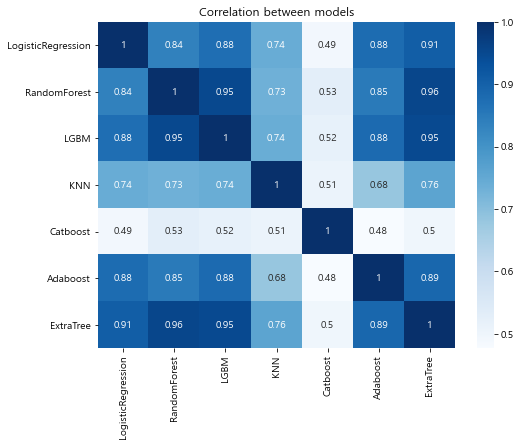

In [35]:
# 예측값 간의 상관관계를 파악해보았습니다.

pred_results = []
for clf in clfs_tuned:
    clf.fit(X_train,y_train)
    pred = clf.predict_proba(X_dev)[:,1]
    pred_results.append(pd.Series(pred))
ensemble_results = pd.concat(pred_results, axis=1)
ensemble_results.columns = ["LogisticRegression","RandomForest","LGBM","KNN","Catboost","Adaboost","ExtraTree"]


# 모형의 예측값 간의 상관관계를 보기 위해 hitmap을 도식함.
plt.figure(figsize = (8,6))
g = sns.heatmap(ensemble_results.corr(), annot=True, cmap='Blues')
g.set_title("Correlation between models")
plt.show()

*Mean agreement vs. Performance*

In [36]:
# Mean agreement

(ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)

LogisticRegression    0.789335
RandomForest          0.809897
LGBM                  0.819929
KNN                   0.695205
Catboost              0.504255
Adaboost              0.776760
ExtraTree             0.826571
dtype: float64

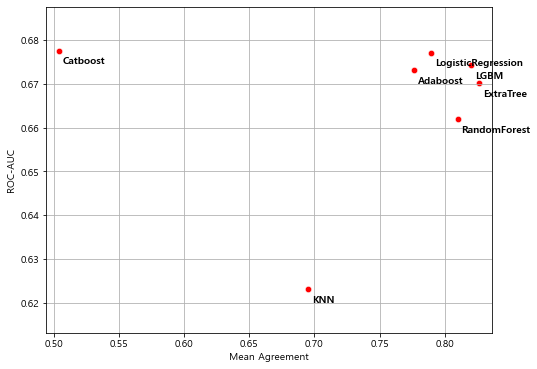

In [37]:
corr = (ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)

names = corr.index
aucs = np.array(model_score).astype(float)
df = pd.DataFrame({'model': names, 'auc': aucs, 'cor': corr})        


plt.figure(figsize=(8,6))
g = sns.scatterplot(x="cor", y="auc", data=df, s=40, color='red')
for line in range(0, df.shape[0]):
     g.text(df.cor[line]+0.003, df.auc[line]-0.003, 
            df.model[line], horizontalalignment='left', 
            size='medium', color='black', weight='semibold')
        
plt.xlim((df.cor.min()-0.01,df.cor.max()+0.01))
plt.ylim((df.auc.min()-0.01,df.auc.max()+0.01))
plt.xlabel('Mean Agreement')
plt.ylabel('ROC-AUC')
plt.grid()
plt.show()

In [38]:
model_name = ["LogisticRegression","RandomForest","LGBM","KNN","Catboost","Adaboost","ExtraTree"]
model_size = len(model_name)

In [39]:
#corr쌍 찾을 보기 쉽게 list로 정리함.

L=[]
for j in range(model_size):
    for i in range(j+1,model_size):
        corr_value=ensemble_results.corr().iloc[:,j][i]
        L.append([corr_value,(model_name[i],model_name[j])])
        
L.sort()

In [40]:
L

[[0.47725752807630667, ('Adaboost', 'Catboost')],
 [0.49345772695208995, ('Catboost', 'LogisticRegression')],
 [0.49802216761453166, ('ExtraTree', 'Catboost')],
 [0.5098006001433448, ('Catboost', 'KNN')],
 [0.5183147970677427, ('Catboost', 'LGBM')],
 [0.5286757214662046, ('Catboost', 'RandomForest')],
 [0.6823909758408454, ('Adaboost', 'KNN')],
 [0.732728994109901, ('KNN', 'RandomForest')],
 [0.7412873631890199, ('KNN', 'LGBM')],
 [0.7433070786422419, ('KNN', 'LogisticRegression')],
 [0.7617164869357247, ('ExtraTree', 'KNN')],
 [0.8381970663599198, ('RandomForest', 'LogisticRegression')],
 [0.8513664170773153, ('Adaboost', 'RandomForest')],
 [0.8754029230619096, ('LGBM', 'LogisticRegression')],
 [0.8794729339172155, ('Adaboost', 'LogisticRegression')],
 [0.8822137629371065, ('Adaboost', 'LGBM')],
 [0.8878576537203231, ('ExtraTree', 'Adaboost')],
 [0.9061728687177412, ('ExtraTree', 'LogisticRegression')],
 [0.9498019206893568, ('ExtraTree', 'LGBM')],
 [0.9525554873534436, ('LGBM', 'Rand

### ensemble (lr + lgbm) 성능 1위 / 3위

In [41]:
lrlgbm_averaging = VotingClassifier( estimators = [('lgbm', model_LGBM), ('lr',model_LR)], voting='soft',n_jobs=-1)
pred = lrlgbm_averaging.fit(X_train, y_train).predict_proba(X_dev)[:,1]
test_score = roc_auc_score(y_dev, pred)
print(test_score)

0.6807712331823644


### ensemble(lr+ada) 성능 1위 /2위 

In [42]:
# averaging = VotingClassifier( estimators = [('ada', model_Ada), ('lr',model_LR)], voting='soft',n_jobs=-1)
# pred = averaging.fit(X_train, y_train).predict_proba(X_dev)[:,1]
# test_score = roc_auc_score(y_dev, pred)
# print(test_score)

### ensemble (lr + et)

In [43]:
# averaging = VotingClassifier( estimators = [('lr', model_LR), ('et',model_ET)], voting='soft',n_jobs=-1)
# pred = averaging.fit(X_train, y_train).predict_proba(X_dev)[:,1]
# test_score = roc_auc_score(y_dev, pred)
# print(test_score)

### ensemble( ada+ et)

In [44]:
# averaging = VotingClassifier( estimators = [('ada', model_Ada), ('et',model_ET)], voting='soft',n_jobs=-1)
# pred = averaging.fit(X_train, y_train).predict_proba(X_dev)[:,1]
# test_score = roc_auc_score(y_dev, pred)
# print(test_score)

### emsemble(lgbm+Et)

In [45]:
# averaging = VotingClassifier( estimators = [('lgbm', model_LGBM), ('et',model_ET)], voting='soft',n_jobs=-1)
# pred = averaging.fit(X_train, y_train).predict_proba(X_dev)[:,1]
# test_score = roc_auc_score(y_dev, pred)
# print(test_score)

### ensemble(except knn, rf)

In [46]:
# averaging = VotingClassifier( estimators = [('lr', model_LR),('ada',model_Ada),('lgbm',model_LGBM),("et",model_ET),("cat",model_CAT)], voting='soft',n_jobs=-1)
# pred = averaging.fit(X_train, y_train).predict_proba(X_dev)[:,1]
# test_score = roc_auc_score(y_dev, pred)
# print(test_score)

### stacking (lr + lgbm -> lr) 2-layer로 진행

In [47]:
## 2-layer stacking
# stk_clf = StackingClassifier(
#     estimators = [('lgbm', model_LGBM),('lr',model_LR)], final_estimator=model_LR, cv=skf)

# stk_clf.fit(X_train, y_train)
# print(roc_auc_score(y_dev, stk_clf.predict_proba(X_dev)[:,1]))  

### stacking (et+ada -> lr)

In [48]:
## 2-layer stacking
# stk_clf = StackingClassifier(
#     estimators = [('et', model_ET),('ada',model_Ada)], final_estimator=model_LR, cv=10)

# stk_clf.fit(X_train, y_train)
# print(roc_auc_score(y_dev, stk_clf.predict_proba(X_dev)[:,1])) 

### 이중 스태킹

In [49]:
# 먼저 두번째에 들어갈 스태킹 층을 만들어줌, 최종적으로 메타모델이 될 모델은 model_LR
stk_layer2 = StackingClassifier(estimators = [('lr', model_LR), ('lgbm', model_LGBM)],
                            final_estimator = model_LR, cv=skf, n_jobs=-1)

# 메타 모델에 앞서 만든 두번 째 층 스태킹을 넣어줌
stk_f = StackingClassifier(estimators = [('lr', model_LR),('ada',model_Ada)],
                            final_estimator = stk_layer2, cv=skf, n_jobs=-1)


stk_f.fit(X_train, y_train)
print(roc_auc_score(y_dev, stk_f.predict_proba(X_dev)[:,1])) 

0.6778784237124258


### stacking after voting

In [50]:
# voting_layer2 = VotingClassifier(estimators = [('et', model_ET), ('Ada', model_Ada)], voting='soft', n_jobs=-1)
#     # 앞에서 훈련한 보팅 모델을 가져다 쓰는 방법

# stk_clf = StackingClassifier(estimators = [('lr', model_LR), ('lgbm', model_LGBM)],
#                             final_estimator = voting_layer2, cv=5, n_jobs=-1)

# stk_clf.fit(X_train, y_train)
# print(roc_auc_score(y_dev, stk_clf.predict_proba(X_dev)[:,1])) 

### 6. Deployment

In [51]:
# Averaging ensemble로 예측한 submission: (lr+lgbm)
pd.DataFrame({'cust_id': test_id, 'gender': lrlgbm_averaging.predict_proba(X_test)[:,1]}).to_csv('이현지-2차-submission-01.csv', index=False)
# Stacking ensemble로 예측한 submission : (이중 스태킹) 
pd.DataFrame({'cust_id': test_id, 'gender': stk_f.predict_proba(X_test)[:,1]}).to_csv('이현지-2차-submission-02.csv', index=False)

<font color="#CC3D3D"><p>
# End